<a href="https://colab.research.google.com/github/ChervonenkisD/TLab.RL/blob/main/TLab_2023_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TLab 2023. RL тестовое задание**
Здравствуйте! 

В данной работе будет произведено сравнение и выполнена реализация двух методов Offline-to-Online Reinforcement Learning (Reinforcement Learning Reusing Prior Data). Для выполнения работы я выбрала методы из статей:

1.  [Adaptive Behavior Cloning Regularization for Stable Offline-to-Online Reinforcement Learning](https://arxiv.org/abs/2210.13846)
2.  [A Minimalist Approach to Offline Reinforcement Learning](https://arxiv.org/abs/2106.06860)


# *Мотивация выбора методов*


Методы, представленные в этих статьях, базируются на [DDPG](https://arxiv.org/abs/1509.02971) (Deep Deterministic Policy Gradient) - алгоритме глубокого обучения с подкреплением, основной идеей которого является комбинация двух концепций: Actor-Critic архитектуры и метода глубокого Q-learning. Что стало одной из причин, почему я предпочла эти статьи, ведь

*   Сравнение двух модификаций одного метода очень удобно: нет необходимости дважды с нуля реализовывать алгоритмы, а достаточно единожды создать основной, а далее произвести небольшие (и как указано в обеих публикациях- простые) изменения.

*   Также их сравнение  может иметь практическое значение- мы можем сделать выводы о плюсах и минусах каждого, о том, как они улучшили/не изменили/ухудшили исходный метод и в каких случаях какая из модификаций подойдет лучше. 

*   Помимо вышеперечисленного еще одной причиной моего выбора стало то, что обеих статьх эксперименты проводятся на основе бенчмарка D4RL, что дает возможность, не уходя далеко от результатов приведенных в статьях, произвести их сравнения.

# *Мотивация выбора датасетов*

Как было отмечено выше, для анализа результата в обеих статьях использовался бенчмарк D4RL. Соотвественно, именно с помощью этой библиотеки можно провести сравнение результатов с публикациями и сделать выводы о том, насаколько хороша получилась реализация.

Для проведения экспериментов я выбрала датасеты hopper-medium-replay и walker2d-medium-replay. Так как на hopper-medium-replay для Adaptive Behavior Cloning были показаны наилучшие результаты, а для сравнения хотелось бы использовать разные датасеты, поэтому вторым был выбран Walker2d (основной анализ в публикациях был выполнен именно на walker2d и hopper). 

# Установка библиотек и систем (в том числе D4RL)

**Обратите внимание**, что внутри раздела необходимо также импортировать несколько файлов

In [3]:
#Include this at the top of your colab code
import os
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc 
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc 
  # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco-py<2.2,>=2.1'
  # run once
  !touch .mujoco_setup_complete

try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/usr/lib/nvidia'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  import mujoco_py
  _mujoco_run_once = True

Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 128293 files and directories currently installed.)
Preparing to unpack .../00-libgl1-mesa-glx_21.2.6-0ubuntu0.1~20.04.2_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (21.2.6-0ubuntu0.1~20.04.2) ...
Selecting previously unselected package libgles1:amd64.
Preparing to unpack .../01-libgles1_1.3.2-1~ubuntu0.20.04.2_amd64.deb ...
Unpacking libgles1:amd64 (1.3.2-1~ubuntu0.20.04.2) ...
Selecting previously unselected package libgles-dev:amd64.
Preparing to unpack .../02-libgles-dev_1.3.2-1~ubuntu0.20.04.2_amd64.deb ...
Unpacking libgles-dev:amd64 (1.3.2-1~ubuntu0.20.04.2) ...
Selecting previously unselected package libopengl-dev:amd64.
Preparing to unpack .../03-libopengl-dev_1.3.2-1~ubuntu0.20.04.2_amd64.deb ...
Unpacking libopengl-dev:amd64 (1.3.2-1~ubuntu0.20.04.2) ...
Selecting previously unselected package libglvnd-dev:amd64.
Preparing to unpack .../04-libglvnd-dev_1.3.2-1~ubuntu0.20.04.2_amd64.deb ...


In [4]:
!pip install git+https://github.com/tinkoff-ai/d4rl@master#egg=d4rl

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tinkoff-ai/d4rl (to revision master) to /tmp/pip-install-4bs_bxb3/d4rl_83c0a0917e294f1bacee7e4b0e04e8c4
  Running command git clone --filter=blob:none --quiet https://github.com/tinkoff-ai/d4rl /tmp/pip-install-4bs_bxb3/d4rl_83c0a0917e294f1bacee7e4b0e04e8c4
  Resolved https://github.com/tinkoff-ai/d4rl to commit db6e4b34bb5ce2a51dd3879177c0a0223208a614
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/aravindr93/mjrl (to revision master) to /tmp/pip-install-4bs_bxb3/mjrl_4b35f559d0d04c11a7d7e0338cc504c0
  Running command git clone --filter=blob:none --quiet https://github.com/aravindr93/mjrl /tmp/pip-install-4bs_bxb3/mjrl_4b35f559d0d04c11a7d7e0338cc504c0
  Resolved https://github.com/aravindr93/mjrl to commit 3871d93763d3b49c4741e6daeaebbc605fe140dc
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/6

In [5]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=19ffa860281d17e703dbad762a457a7d91a0c3f9266569f7220beb360315e569
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [6]:
import random
import numpy as np
import torch
import gym
import argparse
import os
import d4rl
import tqdm
import time
import wandb

import torch.nn.functional as F

No module named 'flow'
/usr/local/lib/python3.9/dist-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  # If this is the last item make sure we use the


Далее **необходимо импортировать несколько дополнительных файлов**, находящихся на гитхабе в папке "Methods"- по ссылке https://github.com/ChervonenkisD/TLab.RL/tree/main/Methods

Можно импортировать их с ПК, используя следующуюю ячейку
(необходимо загрузить utils.py, redq_bc.py, TD3_BC.py)

In [ ]:
from google.colab import files
files.upload()

Если вам удобнее подгрузить их в Colab или вы их уже импортировали с ПК (т.е. в любом случае :)), то необходимо запустить ячейку ниже

In [8]:
import utils
import redq_bc
import TD3_BC

# Реализация метода Adaptive Behavior Cloning Regularization

На основе hopper-medium-replay

Исходные значения модели я несколько уменьшила (по сравнению с указанными в статье) для того, чтобы код выполнялся не часы, а несколько минут. Безусловно это сильно скажется на точности методов, но и по таким результатам можено будет сделать выводы и сравнить методы.

P. S. Во втором методе используются точно такие же числа



In [15]:
# These values are used to replace the target_R
R_MAX_CHEETAH = 15.743
R_MAX_WALKER = 10.271
R_MAX_HOPPER = 6.918


parser = argparse.ArgumentParser()    # Experiment
parser.add_argument("-policy", "--policy", default="REDQ_BC")                      # Policy name

parser.add_argument("-env", "--env", default="hopper-medium-replay-v0")         # d4rl environment name
parser.add_argument("-seed", "--seed", default=0, type=int)                      # Random Seed
parser.add_argument("-eval_freq", "--eval_freq", default=5000, type=int)              # How often (time steps) we evaluate
parser.add_argument("-max_timesteps", "--max_timesteps", default=2500, type=int)       # Max finetuning timesteps to run
parser.add_argument("-pretrain_timesteps", "--pretrain_timesteps", default=10000, type=int)
parser.add_argument("-num_updates", "--num_updates", type=int, default=10, help='Num of update steps per data point.')
parser.add_argument("-save_model", "--save_model", action="store_true")                # Save model and optimizer parameters
parser.add_argument("-load_policy_id", "--load_policy_id", default="")                     # Load policy and optimizer with the given id
parser.add_argument("-episode_length", "--episode_length", default=1000, type=int)
# TD3
parser.add_argument("-expl_noise", "--expl_noise", default=0.1)                        # Std of Gaussian exploration noise
parser.add_argument("-batch_size", "--batch_size", default=256, type=int)              # Batch size for both actor and critic
parser.add_argument("-discount", "--discount", default=0.99)                         # Discount factor
parser.add_argument("-tau", "--tau", default=0.005)                             # Target network update rate
parser.add_argument("-policy_noise", "--policy_noise", default=0.2)                      # Noise added to target policy during critic update
parser.add_argument("-noise_clip", "--noise_clip", default=0.5)                        # Range to clip target policy noise
parser.add_argument("-policy_freq", "--policy_freq", default=2, type=int)               # Frequency of delayed policy updates
# ablation, dataset
parser.add_argument('-sample_method', '--sample_method', choices=['random', 'best'], default='random')
parser.add_argument('-sample_ratio', '--sample_ratio', type=float, default=0.05)
# ablation, q_update
parser.add_argument('-use_q_min', '--use_q_min', action='store_true')
# adaptive alpha
parser.add_argument('-Kp', '--Kp', type=float, default=0.00003)
parser.add_argument('-Kd', '--Kd', type=float, default=0.0001)
# ablation, avoid using the target_R
parser.add_argument("-use_r_max", "--use_r_max", action='store_true') # if True, the return will normalized by the R_MAX * T

args = parser.parse_args('')

In [16]:
# get task-specific args
if args.env == "walker2d-random-v0":
    args.alpha = 100
    args.alpha_finetune = 0.4
elif args.env in ['pen-expert-v0', 'door-expert-v0', 'hammer-expert-v0', 'relocate-expert-v0']:
    # these tasks need larger constraints during pretraining.
    args.alpha = 8.0
    args.alpha_finetune = 8.0
    # change the Kp and Kd accordingly
    args.Kp = (args.alpha / 0.4) * args.Kp # 0.4 is the default value for locomotion tasks
    args.Kd = (args.alpha / 0.4) * args.Kd
    # change the num_updates -- fix it to 1
    args.num_updates = 1
else: # default value for all locomotion tasks except the 'walker2d-random-v0'
    args.alpha = 0.4
    args.alpha_finetune = 0.4
print(args)    
    

# use R_MAX * T to normalize the reward, and as target return
# This is only needed when no target_R is available.
if args.use_r_max:
    domain = str(args.env).split('-')[0]
    if domain == "halfcheetah":
        max_R = R_MAX_CHEETAH * args.episode_length
    elif domain == "walker2d":
        max_R = R_MAX_WALKER * args.episode_length
    elif domain == "hopper":
        max_R = R_MAX_HOPPER * args.episode_length
    else:
        raise ValueError


run_id = int(time.time())
run_name = f"{args.policy}_{args.env}_{args.seed}_{run_id}"

if args.save_model:
    if not os.path.exists(f"./models/{args.env}/pretrain"):
        os.makedirs(f"./models/{args.env}/pretrain")
    if not os.path.exists(f"./models/{args.env}/finetune"):
        os.makedirs(f"./models/{args.env}/finetune")
    else:
        print(f"The pretrained model will be stored under path: ./models/{args.env}/pretrain; The finetuned model will be stored under path: ./models/{args.env}/finetune")

# seeding and setup env
env = gym.make(args.env)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

env.seed(args.seed)
env.action_space.seed(args.seed)
env.observation_space.seed(args.seed)


state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])
   

Namespace(policy='REDQ_BC', env='hopper-medium-replay-v0', seed=0, eval_freq=5000, max_timesteps=2500, pretrain_timesteps=10000, num_updates=10, save_model=False, load_policy_id='', episode_length=1000, expl_noise=0.1, batch_size=256, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2, sample_method='random', sample_ratio=0.05, use_q_min=False, Kp=3e-05, Kd=0.0001, use_r_max=False, alpha=0.4, alpha_finetune=0.4)


In [17]:
# init d4rl_buffer
d4rl_replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
d4rl_replay_buffer.convert_D4RL(d4rl.qlearning_dataset(env)) # fill buffer


# init policy
kwargs = {
    "state_dim": state_dim, 
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": args.discount,
    "tau": args.tau, 
    "policy_noise": args.policy_noise,
    "noise_clip": args.noise_clip,
    "policy_freq": args.policy_freq,
    "alpha": args.alpha,
    "use_q_min": args.use_q_min,
    "pretrain": True,
}
policy = redq_bc.REDQ_BC(**kwargs)

load datafile: 100%|██████████| 5/5 [00:00<00:00, 51.92it/s]


Далее необходимо использовать библиотеку wandb. Для этого **может потребовать регистрация** на https://wandb.ai/authorize. Также в случае необходимости ссылка выпадет при выполнении ячейки. 

In [18]:
########## Load or Pretrain the model with d4rl dataset. ##########
# load/pretrain policy
if args.load_policy_id != "":
    policy_file = f'{args.policy}_{args.env}' if args.load_policy_id == "default" else f'{args.policy}_{args.env}_{0}_{args.load_policy_id}'
    policy.load(f"./models/{args.env}/pretrain/{policy_file}")
    print(f"------ Load policy model {policy_file} ------")
else: # finetune
    with wandb.init(project='TLab', group=args.env, job_type="pretrain", name=run_name):
        wandb.config.update(args)
        for i in tqdm.tqdm(range(args.pretrain_timesteps)):
            batch = d4rl_replay_buffer.sample(args.batch_size)
            pretrain_info = policy.train(batch)
            wandb.log({"pretrain_training/": pretrain_info})
        
            if i % args.eval_freq == 0:
                pretrain_eval = utils.eval_policy(policy, args.env, args.seed)
                wandb.log({'pretrain_evaluation/': pretrain_eval})
        # save policy
        if args.save_model: policy.save(f'./models/{args.env}/pretrain/{run_name}') 

100%|██████████| 10000/10000 [01:20<00:00, 123.46it/s]


In [19]:
########## Begin to finetune the model ##########
state, done = env.reset(), False
episode_timesteps = 0
update_info, eval_info = {}, {}

# distill dataset
buffer = utils.ReplayBuffer(state_dim, action_dim, max_size=int(args.max_timesteps))
buffer.distill(d4rl.qlearning_dataset(env), args.env, args.sample_method, args.sample_ratio)
del d4rl_replay_buffer # to save memory


policy.alpha = args.alpha_finetune
policy.pretrain = False # set flag of pretrain

# finetune
with wandb.init(project='TLab', group=args.env, job_type="finetune", name=run_name):
    wandb.config.update(args)

    # init last_R, current_R and target_R
    # last_R ranges from 0 to 1
    if args.use_r_max:
        last_R = utils.eval_policy(policy, args.env, args.seed, eval_episodes=1)['evaluation'] / max_R
    else: 
        last_R  = utils.eval_policy(policy, args.env, args.seed, eval_episodes=1)['d4rl']*0.01 

    current_R = last_R
    target_R = 1.05


    episode_return = 0.
    for t in tqdm.tqdm(range(args.max_timesteps)):
        episode_timesteps += 1

        action = (policy.select_action(state) 
                + np.random.normal(0, scale=args.expl_noise, size=action_dim)
        ).clip(-max_action, max_action)

        next_state, reward, done, _ = env.step(action)

        episode_return += reward  # recore episode return

        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0. # important!
        buffer.add(state, action, next_state, reward, done_bool)

        state = next_state
            
        for _ in range(args.num_updates):
            update_info = policy.train(buffer.sample(args.batch_size))

        update_info.update({'current_R': current_R, 'last_R': last_R})

        wandb.log({'finetune_training/': update_info,
                        'finetune_training/alpha': policy.alpha})

        if done:
            state, done = env.reset(), False
                
          # update current_R and the alpha of policy
            if args.use_r_max:
                current_R = episode_return / max_R
            else:
                current_R = env.get_normalized_score(episode_return)

            policy.alpha += episode_timesteps * (- args.Kp * (target_R - last_R)
                              + args.Kd * max(0, last_R - current_R))
            # clip the alpha value between 0.0 and 0.4
            policy.alpha = max(0., min(policy.alpha, args.alpha_finetune))

            # moving average
            last_R = 0.05 * current_R + 0.95 * last_R
                
            episode_timesteps = 0
            episode_return = 0.
            
        # Evaluate episode
        if t % args.eval_freq == 0:
                eval_info = utils.eval_policy(policy, args.env, args.seed, eval_episodes=10)
                wandb.log({'finetune_evaluation/': eval_info})

                if args.save_model:
                    policy.save(f"./models/{args.env}/finetune/{run_name}")

load datafile: 100%|██████████| 5/5 [00:00<00:00, 36.18it/s]


100%|██████████| 2500/2500 [02:47<00:00, 14.88it/s]


# Реализация метода Twin Delayed Deep Deterministic Policy Gradient



In [9]:
parser = argparse.ArgumentParser()
# Experiment
parser.add_argument("--policy", default="TD3_BC")               # Policy name
parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
parser.add_argument("--env", default="hopper-medium-replay-v0")        # OpenAI gym environment name
parser.add_argument("--eval_freq", default=5000, type=int)       # How often (time steps) we evaluate
parser.add_argument("--max_timesteps", default=2500, type=int)   # Max time steps to run environment
parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
# TD3
parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
parser.add_argument("--batch_size", default=256, type=int)      # Batch size for both actor and critic
parser.add_argument("--discount", default=0.99)                 # Discount factor
parser.add_argument("--tau", default=0.005)                     # Target network update rate
parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
	# TD3 + BC
#parser.add_argument("--alpha", default=2.5)
parser.add_argument("--normalize", default=True)
parser.add_argument("--device", default='cuda',type=str)
parser.add_argument('-sample_method', '--sample_method', choices=['random', 'best'], default='random')
parser.add_argument('-sample_ratio', '--sample_ratio', type=float, default=0.05)
parser.add_argument("-pretrain_timesteps", "--pretrain_timesteps", default=10000, type=int)
parser.add_argument("--group", default='TD3_BC-D4RL',type=str)
parser.add_argument("--name", default='TD3_BC',type=str)
parser.add_argument("--project", default='TLab',type=str)
parser.add_argument("-num_updates", "--num_updates", type=int, default=10, help='Num of update steps per data point.')

args = parser.parse_args('')

file_name = f"{args.policy}_{args.env}_{args.seed}"

run_id = int(time.time())
run_name = f"{args.policy}_{args.env}_{args.seed}_{run_id}"

args.alpha = 0.4
args.alpha_finetune = 0.4

if args.save_model:
    if not os.path.exists(f"./models/{args.env}/pretrain"):
        os.makedirs(f"./models/{args.env}/pretrain")
    if not os.path.exists(f"./models/{args.env}/finetune"):
        os.makedirs(f"./models/{args.env}/finetune")
    else:
        print(f"The pretrained model will be stored under path: ./models/{args.env}/pretrain; The finetuned model will be stored under path: ./models/{args.env}/finetune")

env = gym.make(args.env)

# Set seeds
env.seed(args.seed)
env.action_space.seed(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)
	
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment hopper-medium-replay-v0 is out of date. You should consider upgrading to version `v2`.
  finally:
/usr/local/lib/python3.9/dist-packages/d4rl/gym_mujoco/gym_envs.py:13: UserWarning: This environment is deprecated. Please use the most recent version of this environment.
  offline_env.OfflineEnv.__init__(self, **kwargs)
/usr/local/lib/python3.9/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  upp_bounded = ~self.bounded_below & self.bounded_above
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  @abstractmethod
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning

In [10]:
kwargs = {
	"state_dim": state_dim,
	"action_dim": action_dim,
	"max_action": max_action,
	"discount": args.discount,
	"tau": args.tau,
	# TD3
	"policy_noise": args.policy_noise * max_action,
	"noise_clip": args.noise_clip * max_action,
	"policy_freq": args.policy_freq,
	# TD3 + BC
	"alpha": args.alpha
}

# Initialize policy
policy = TD3_BC.TD3_BC(**kwargs)


Далее необходимо использовать библиотеку wandb. Для этого может потребовать регистрация на https://wandb.ai/authorize. Также в случае необходимости ссылка выпадет при выполнении ячейки. 

In [11]:
d4rl_replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
d4rl_replay_buffer.convert_D4RL(d4rl.qlearning_dataset(env)) # fill buffer

if args.load_model != "":
    policy_file = f'{args.policy}_{args.env}' if args.load_policy_id == "default" else f'{args.policy}_{args.env}_{0}_{args.load_policy_id}'
    policy.load(f"./models/{args.env}/pretrain/{policy_file}")
    print(f"------ Load policy model {policy_file} ------")    
else: # finetune
    with wandb.init(project='TLab', group=args.env, job_type="pretrain", name=run_name):
        wandb.config.update(args)
        for i in tqdm.tqdm(range(args.pretrain_timesteps)):
            batch = d4rl_replay_buffer.sample(args.batch_size)
            pretrain_info = policy.train(batch)
            wandb.log({'pretrain_training/': pretrain_info})
        
            if i % args.eval_freq == 0:
                pretrain_eval = utils.eval_policy(policy, args.env, args.seed)
                wandb.log({'pretrain_evaluation/': pretrain_eval})
        # save policy
        if args.save_model: policy.save(f'./models/{args.env}/pretrain/{run_name}') 

state, done = env.reset(), False
episode_timesteps = 0
update_info, eval_info = {}, {}

buffer = utils.ReplayBuffer(state_dim, action_dim, max_size=int(args.max_timesteps))
buffer.distill(d4rl.qlearning_dataset(env), args.env, args.sample_method, args.sample_ratio)
del d4rl_replay_buffer # to save memory

if args.normalize:
	mean,std = buffer.normalize_states() 
else:
	mean,std = 0,1

load datafile: 100%|██████████| 5/5 [00:00<00:00, 40.63it/s]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 10000/10000 [03:54<00:00, 42.68it/s]


load datafile: 100%|██████████| 5/5 [00:00<00:00, 33.77it/s]


In [12]:
########## Begin to finetune the model ##########
state, done = env.reset(), False
episode_timesteps = 0
update_info, eval_info = {}, {}

policy.alpha = args.alpha_finetune
policy.pretrain = False # set flag of pretrain

evaluations = []

# finetune
with wandb.init(project='TLab', group=args.env, job_type="finetune", name=run_name):
    wandb.config.update(args)


    episode_return = 0.
    for t in tqdm.tqdm(range(args.max_timesteps)):
        episode_timesteps += 1
            
        for _ in range(args.num_updates):
            update_info = policy.train(buffer.sample(args.batch_size))

        wandb.log({'finetune_training/': update_info})
            
        # Evaluate episode
        if t % args.eval_freq == 0:
                eval_info = utils.eval_policy(policy, args.env, args.seed, eval_episodes=10)
                wandb.log({'finetune_evaluation/': eval_info})

                if args.save_model:
                    policy.save(f"./models/{args.env}/finetune/{run_name}")
        if (t + 1) % args.eval_freq == 0:
            normalized_score=eval_policy(policy, args.env, args.seed, mean, std)
            evaluations.append(normalized_score)
    
            np.save(f"./results/{file_name}", evaluations)
            eval_info = utils.eval_policy(policy, args.env, args.seed, eval_episodes=10)
            wandb.log({'finetune_evaluation/': eval_info})
            if args.save_model: policy.save(f"./models/{args.env}/finetune/{run_name}")
  
            wandb.log(
                {"d4rl_normalized_score": normalized_score},
                step=policy.total_it,
            )

wandb: Currently logged in as: dasha30050 (chedasha). Use `wandb login --relogin` to force relogin


100%|██████████| 2500/2500 [07:54<00:00,  5.27it/s]


# Обучение на втором датасете (walker2d-medium-replay)
Код с точностью до датасета совпадает с записанным в двух предыдущих разделах

In [25]:
# These values are used to replace the target_R
R_MAX_CHEETAH = 15.743
R_MAX_WALKER = 10.271
R_MAX_HOPPER = 6.918


parser = argparse.ArgumentParser()    # Experiment
parser.add_argument("-policy", "--policy", default="REDQ_BC")                      # Policy name

parser.add_argument("-env", "--env", default="walker2d-medium-replay-v0")         # d4rl environment name
parser.add_argument("-seed", "--seed", default=0, type=int)                      # Random Seed
parser.add_argument("-eval_freq", "--eval_freq", default=5000, type=int)              # How often (time steps) we evaluate
parser.add_argument("-max_timesteps", "--max_timesteps", default=2500, type=int)       # Max finetuning timesteps to run
parser.add_argument("-pretrain_timesteps", "--pretrain_timesteps", default=10000, type=int)
parser.add_argument("-num_updates", "--num_updates", type=int, default=10, help='Num of update steps per data point.')
parser.add_argument("-save_model", "--save_model", action="store_true")                # Save model and optimizer parameters
parser.add_argument("-load_policy_id", "--load_policy_id", default="")                     # Load policy and optimizer with the given id
parser.add_argument("-episode_length", "--episode_length", default=1000, type=int)
# TD3
parser.add_argument("-expl_noise", "--expl_noise", default=0.1)                        # Std of Gaussian exploration noise
parser.add_argument("-batch_size", "--batch_size", default=256, type=int)              # Batch size for both actor and critic
parser.add_argument("-discount", "--discount", default=0.99)                         # Discount factor
parser.add_argument("-tau", "--tau", default=0.005)                             # Target network update rate
parser.add_argument("-policy_noise", "--policy_noise", default=0.2)                      # Noise added to target policy during critic update
parser.add_argument("-noise_clip", "--noise_clip", default=0.5)                        # Range to clip target policy noise
parser.add_argument("-policy_freq", "--policy_freq", default=2, type=int)               # Frequency of delayed policy updates
# ablation, dataset
parser.add_argument('-sample_method', '--sample_method', choices=['random', 'best'], default='random')
parser.add_argument('-sample_ratio', '--sample_ratio', type=float, default=0.05)
# ablation, q_update
parser.add_argument('-use_q_min', '--use_q_min', action='store_true')
# adaptive alpha
parser.add_argument('-Kp', '--Kp', type=float, default=0.00003)
parser.add_argument('-Kd', '--Kd', type=float, default=0.0001)
# ablation, avoid using the target_R
parser.add_argument("-use_r_max", "--use_r_max", action='store_true') # if True, the return will normalized by the R_MAX * T

args = parser.parse_args('')

In [26]:
args.alpha = 0.4
args.alpha_finetune = 0.4  
    

# use R_MAX * T to normalize the reward, and as target return
# This is only needed when no target_R is available.
if args.use_r_max:
    domain = str(args.env).split('-')[0]
    if domain == "halfcheetah":
        max_R = R_MAX_CHEETAH * args.episode_length
    elif domain == "walker2d":
        max_R = R_MAX_WALKER * args.episode_length
    elif domain == "hopper":
        max_R = R_MAX_HOPPER * args.episode_length
    else:
        raise ValueError


run_id = int(time.time())
run_name = f"{args.policy}_{args.env}_{args.seed}_{run_id}"

if args.save_model:
    if not os.path.exists(f"./models/{args.env}/pretrain"):
        os.makedirs(f"./models/{args.env}/pretrain")
    if not os.path.exists(f"./models/{args.env}/finetune"):
        os.makedirs(f"./models/{args.env}/finetune")
    else:
        print(f"The pretrained model will be stored under path: ./models/{args.env}/pretrain; The finetuned model will be stored under path: ./models/{args.env}/finetune")

# seeding and setup env
env = gym.make(args.env)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

env.seed(args.seed)
env.action_space.seed(args.seed)
env.observation_space.seed(args.seed)


state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])
   

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment walker2d-medium-replay-v0 is out of date. You should consider upgrading to version `v2` with the environment ID `walker2d-medium-replay-v2`.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/d4rl/gym_mujoco/gym_envs.py:23: UserWarning: This environment is deprecated. Please use the most recent version of this environment.
  offline_env.OfflineEnv.__init__(self, **kwargs)


In [27]:
# init d4rl_buffer
d4rl_replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
d4rl_replay_buffer.convert_D4RL(d4rl.qlearning_dataset(env)) # fill buffer


# init policy
kwargs = {
    "state_dim": state_dim, 
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": args.discount,
    "tau": args.tau, 
    "policy_noise": args.policy_noise,
    "noise_clip": args.noise_clip,
    "policy_freq": args.policy_freq,
    "alpha": args.alpha,
    "use_q_min": args.use_q_min,
    "pretrain": True,
}
policy = redq_bc.REDQ_BC(**kwargs)

load datafile: 100%|██████████| 5/5 [00:00<00:00, 63.83it/s]


In [28]:
########## Load or Pretrain the model with d4rl dataset. ##########
# load/pretrain policy
if args.load_policy_id != "":
    policy_file = f'{args.policy}_{args.env}' if args.load_policy_id == "default" else f'{args.policy}_{args.env}_{0}_{args.load_policy_id}'
    policy.load(f"./models/{args.env}/pretrain/{policy_file}")
    print(f"------ Load policy model {policy_file} ------")
else: # finetune
    with wandb.init(project='TLab', group=args.env, job_type="pretrain", name=run_name):
        wandb.config.update(args)
        for i in tqdm.tqdm(range(args.pretrain_timesteps)):
            batch = d4rl_replay_buffer.sample(args.batch_size)
            pretrain_info = policy.train(batch)
            wandb.log({"pretrain_training/": pretrain_info})
        
            if i % args.eval_freq == 0:
                pretrain_eval = utils.eval_policy(policy, args.env, args.seed)
                wandb.log({'pretrain_evaluation/': pretrain_eval})
        # save policy
        if args.save_model: policy.save(f'./models/{args.env}/pretrain/{run_name}') 

100%|██████████| 10000/10000 [01:27<00:00, 114.04it/s]


In [29]:
########## Begin to finetune the model ##########
state, done = env.reset(), False
episode_timesteps = 0
update_info, eval_info = {}, {}

# distill dataset
buffer = utils.ReplayBuffer(state_dim, action_dim, max_size=int(args.max_timesteps))
buffer.distill(d4rl.qlearning_dataset(env), args.env, args.sample_method, args.sample_ratio)
del d4rl_replay_buffer # to save memory


policy.alpha = args.alpha_finetune
policy.pretrain = False # set flag of pretrain

# finetune
with wandb.init(project='TLab', group=args.env, job_type="finetune", name=run_name):
    wandb.config.update(args)

    # init last_R, current_R and target_R
    # last_R ranges from 0 to 1
    if args.use_r_max:
        last_R = utils.eval_policy(policy, args.env, args.seed, eval_episodes=1)['evaluation'] / max_R
    else: 
        last_R  = utils.eval_policy(policy, args.env, args.seed, eval_episodes=1)['d4rl']*0.01 

    current_R = last_R
    target_R = 1.05


    episode_return = 0.
    for t in tqdm.tqdm(range(args.max_timesteps)):
        episode_timesteps += 1

        action = (policy.select_action(state) 
                + np.random.normal(0, scale=args.expl_noise, size=action_dim)
        ).clip(-max_action, max_action)

        next_state, reward, done, _ = env.step(action)

        episode_return += reward  # recore episode return

        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0. # important!
        buffer.add(state, action, next_state, reward, done_bool)

        state = next_state
            
        for _ in range(args.num_updates):
            update_info = policy.train(buffer.sample(args.batch_size))

        update_info.update({'current_R': current_R, 'last_R': last_R})

        wandb.log({'finetune_training/': update_info,
                        'finetune_training/alpha': policy.alpha})

        if done:
            state, done = env.reset(), False
                
          # update current_R and the alpha of policy
            if args.use_r_max:
                current_R = episode_return / max_R
            else:
                current_R = env.get_normalized_score(episode_return)

            policy.alpha += episode_timesteps * (- args.Kp * (target_R - last_R)
                              + args.Kd * max(0, last_R - current_R))
            # clip the alpha value between 0.0 and 0.4
            policy.alpha = max(0., min(policy.alpha, args.alpha_finetune))

            # moving average
            last_R = 0.05 * current_R + 0.95 * last_R
                
            episode_timesteps = 0
            episode_return = 0.
            
        # Evaluate episode
        if t % args.eval_freq == 0:
                eval_info = utils.eval_policy(policy, args.env, args.seed, eval_episodes=10)
                wandb.log({'finetune_evaluation/': eval_info})

                if args.save_model:
                    policy.save(f"./models/{args.env}/finetune/{run_name}")

load datafile: 100%|██████████| 5/5 [00:00<00:00, 58.39it/s]


100%|██████████| 2500/2500 [02:29<00:00, 16.73it/s]


In [13]:
parser = argparse.ArgumentParser()
# Experiment
parser.add_argument("--policy", default="TD3_BC")               # Policy name
parser.add_argument("--seed", default=0, type=int)              # Sets Gym, PyTorch and Numpy seeds
parser.add_argument("--env", default="walker2d-medium-replay-v0")        # OpenAI gym environment name
parser.add_argument("--eval_freq", default=5000, type=int)       # How often (time steps) we evaluate
parser.add_argument("--max_timesteps", default=2500, type=int)   # Max time steps to run environment
parser.add_argument("--save_model", action="store_true")        # Save model and optimizer parameters
parser.add_argument("--load_model", default="")                 # Model load file name, "" doesn't load, "default" uses file_name
# TD3
parser.add_argument("--expl_noise", default=0.1)                # Std of Gaussian exploration noise
parser.add_argument("--batch_size", default=256, type=int)      # Batch size for both actor and critic
parser.add_argument("--discount", default=0.99)                 # Discount factor
parser.add_argument("--tau", default=0.005)                     # Target network update rate
parser.add_argument("--policy_noise", default=0.2)              # Noise added to target policy during critic update
parser.add_argument("--noise_clip", default=0.5)                # Range to clip target policy noise
parser.add_argument("--policy_freq", default=2, type=int)       # Frequency of delayed policy updates
	# TD3 + BC
#parser.add_argument("--alpha", default=2.5)
parser.add_argument("--normalize", default=True)
parser.add_argument("--device", default='cuda',type=str)
parser.add_argument('-sample_method', '--sample_method', choices=['random', 'best'], default='random')
parser.add_argument('-sample_ratio', '--sample_ratio', type=float, default=0.05)
parser.add_argument("-pretrain_timesteps", "--pretrain_timesteps", default=10000, type=int)
parser.add_argument("--group", default='TD3_BC-D4RL',type=str)
parser.add_argument("--name", default='TD3_BC',type=str)
parser.add_argument("--project", default='TLab',type=str)
parser.add_argument("-num_updates", "--num_updates", type=int, default=10, help='Num of update steps per data point.')

args = parser.parse_args('')

file_name = f"{args.policy}_{args.env}_{args.seed}"

run_id = int(time.time())
run_name = f"{args.policy}_{args.env}_{args.seed}_{run_id}"

args.alpha = 0.4
args.alpha_finetune = 0.4

if args.save_model:
    if not os.path.exists(f"./models/{args.env}/pretrain"):
        os.makedirs(f"./models/{args.env}/pretrain")
    if not os.path.exists(f"./models/{args.env}/finetune"):
        os.makedirs(f"./models/{args.env}/finetune")
    else:
        print(f"The pretrained model will be stored under path: ./models/{args.env}/pretrain; The finetuned model will be stored under path: ./models/{args.env}/finetune")

env = gym.make(args.env)

# Set seeds
env.seed(args.seed)
env.action_space.seed(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)
	
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment walker2d-medium-replay-v0 is out of date. You should consider upgrading to version `v2`.
  finally:
/usr/local/lib/python3.9/dist-packages/d4rl/gym_mujoco/gym_envs.py:23: UserWarning: This environment is deprecated. Please use the most recent version of this environment.
  offline_env.OfflineEnv.__init__(self, **kwargs)


In [14]:
kwargs = {
	"state_dim": state_dim,
	"action_dim": action_dim,
	"max_action": max_action,
	"discount": args.discount,
	"tau": args.tau,
	# TD3
	"policy_noise": args.policy_noise * max_action,
	"noise_clip": args.noise_clip * max_action,
	"policy_freq": args.policy_freq,
	# TD3 + BC
	"alpha": args.alpha
}

# Initialize policy
policy = TD3_BC.TD3_BC(**kwargs)


In [15]:
d4rl_replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
d4rl_replay_buffer.convert_D4RL(d4rl.qlearning_dataset(env)) # fill buffer

if args.load_model != "":
    policy_file = f'{args.policy}_{args.env}' if args.load_policy_id == "default" else f'{args.policy}_{args.env}_{0}_{args.load_policy_id}'
    policy.load(f"./models/{args.env}/pretrain/{policy_file}")
    print(f"------ Load policy model {policy_file} ------")    
else: # finetune
    with wandb.init(project='TLab', group=args.env, job_type="pretrain", name=run_name):
        wandb.config.update(args)
        for i in tqdm.tqdm(range(args.pretrain_timesteps)):
            batch = d4rl_replay_buffer.sample(args.batch_size)
            pretrain_info = policy.train(batch)
            wandb.log({'pretrain_training/': pretrain_info})
        
            if i % args.eval_freq == 0:
                pretrain_eval = utils.eval_policy(policy, args.env, args.seed)
                wandb.log({'pretrain_evaluation/': pretrain_eval})
        # save policy
        if args.save_model: policy.save(f'./models/{args.env}/pretrain/{run_name}') 

state, done = env.reset(), False
episode_timesteps = 0
update_info, eval_info = {}, {}

buffer = utils.ReplayBuffer(state_dim, action_dim, max_size=int(args.max_timesteps))
buffer.distill(d4rl.qlearning_dataset(env), args.env, args.sample_method, args.sample_ratio)
del d4rl_replay_buffer # to save memory

if args.normalize:
	mean,std = buffer.normalize_states() 
else:
	mean,std = 0,1

load datafile: 100%|██████████| 5/5 [00:00<00:00, 51.59it/s]


100%|██████████| 10000/10000 [03:40<00:00, 45.45it/s]


load datafile: 100%|██████████| 5/5 [00:00<00:00, 49.92it/s]


In [16]:
########## Begin to finetune the model ##########
state, done = env.reset(), False
episode_timesteps = 0
update_info, eval_info = {}, {}

policy.alpha = args.alpha_finetune
policy.pretrain = False # set flag of pretrain

evaluations = []

# finetune
with wandb.init(project='TLab', group=args.env, job_type="finetune", name=run_name):
    wandb.config.update(args)


    episode_return = 0.
    for t in tqdm.tqdm(range(args.max_timesteps)):
        episode_timesteps += 1
            
        for _ in range(args.num_updates):
            update_info = policy.train(buffer.sample(args.batch_size))

        wandb.log({'finetune_training/': update_info})
            
        # Evaluate episode
        if t % args.eval_freq == 0:
                eval_info = utils.eval_policy(policy, args.env, args.seed, eval_episodes=10)
                wandb.log({'finetune_evaluation/': eval_info})

                if args.save_model:
                    policy.save(f"./models/{args.env}/finetune/{run_name}")
        if (t + 1) % args.eval_freq == 0:
            normalized_score=eval_policy(policy, args.env, args.seed, mean, std)
            evaluations.append(normalized_score)
    
            np.save(f"./results/{file_name}", evaluations)
            eval_info = utils.eval_policy(policy, args.env, args.seed, eval_episodes=10)
            wandb.log({'finetune_evaluation/': eval_info})
            if args.save_model: policy.save(f"./models/{args.env}/finetune/{run_name}")
  
            wandb.log(
                {"d4rl_normalized_score": normalized_score},
                step=policy.total_it,
            )

100%|██████████| 2500/2500 [08:05<00:00,  5.15it/s]


# Сравнение моделей

1. *На датасете hopper-medium-replay*

Для начала рассмотрим оффлайн обучение. На следующих графиках представлены
*   Сritic_loss: функция потерь между текущими оценками Q-функции и целевыми значениями Q-функции. Для этого используется функция среднеквадратичной ошибки (MSE) из библиотеки PyTorch.
*   Critic: значения Q-функции для текущего мини-батча в моменты обучения

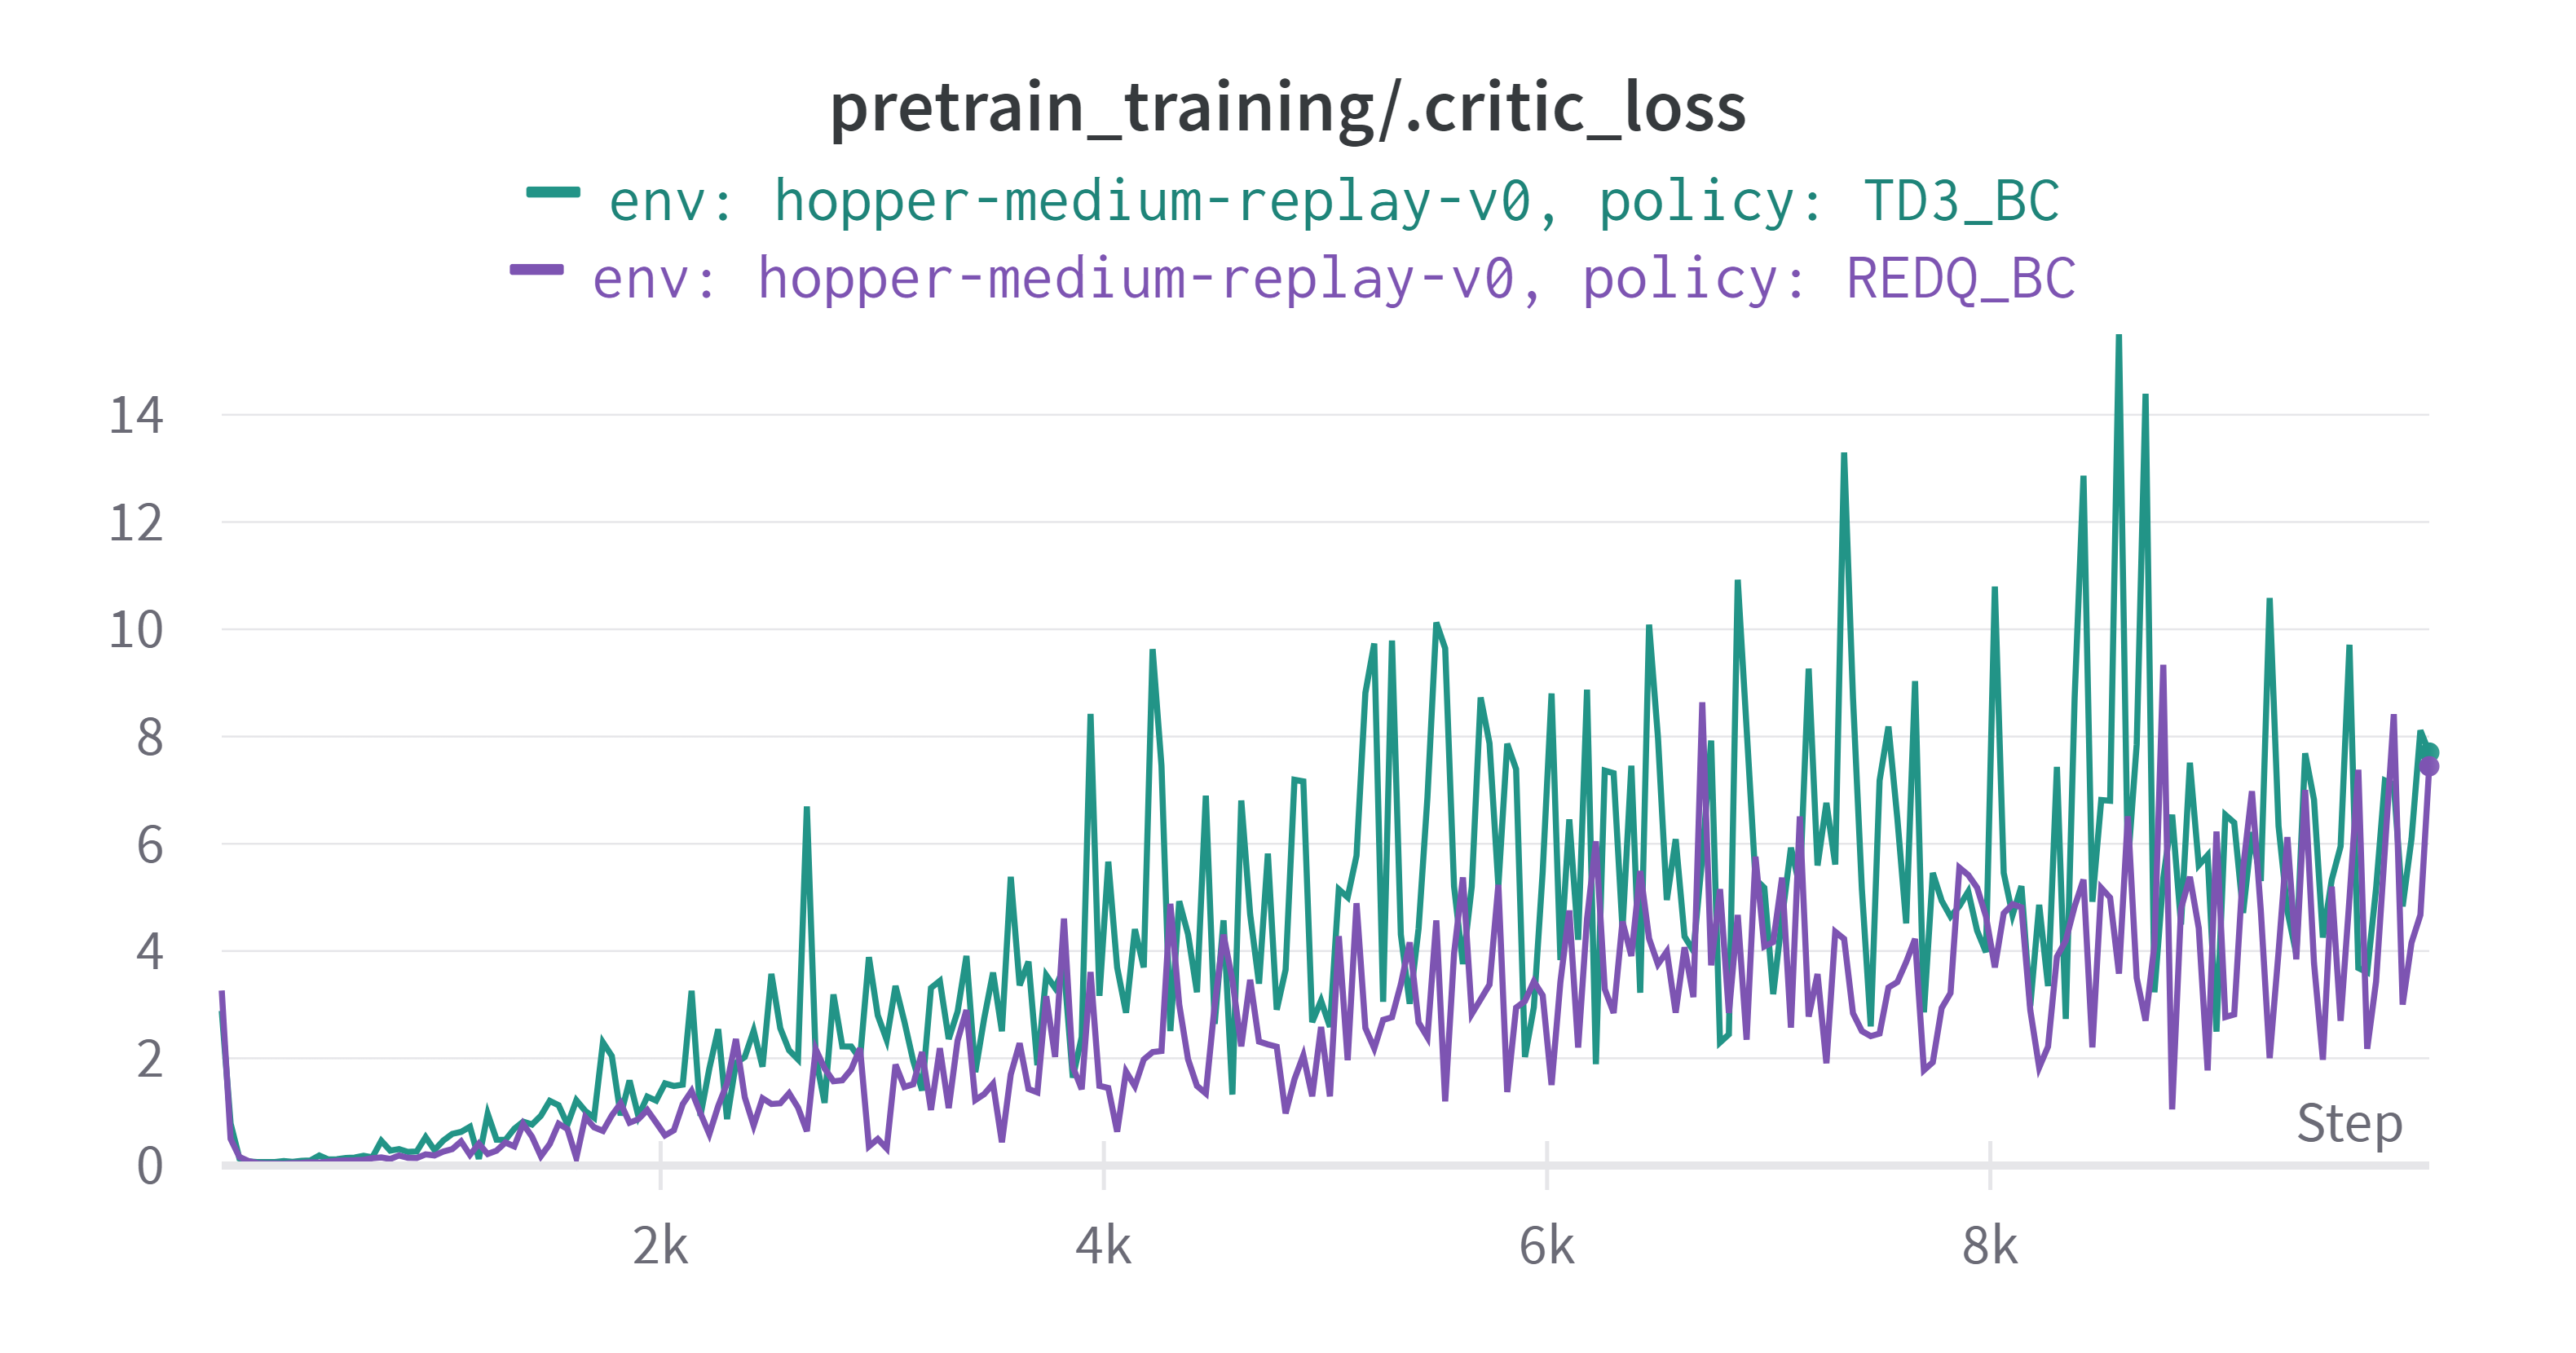

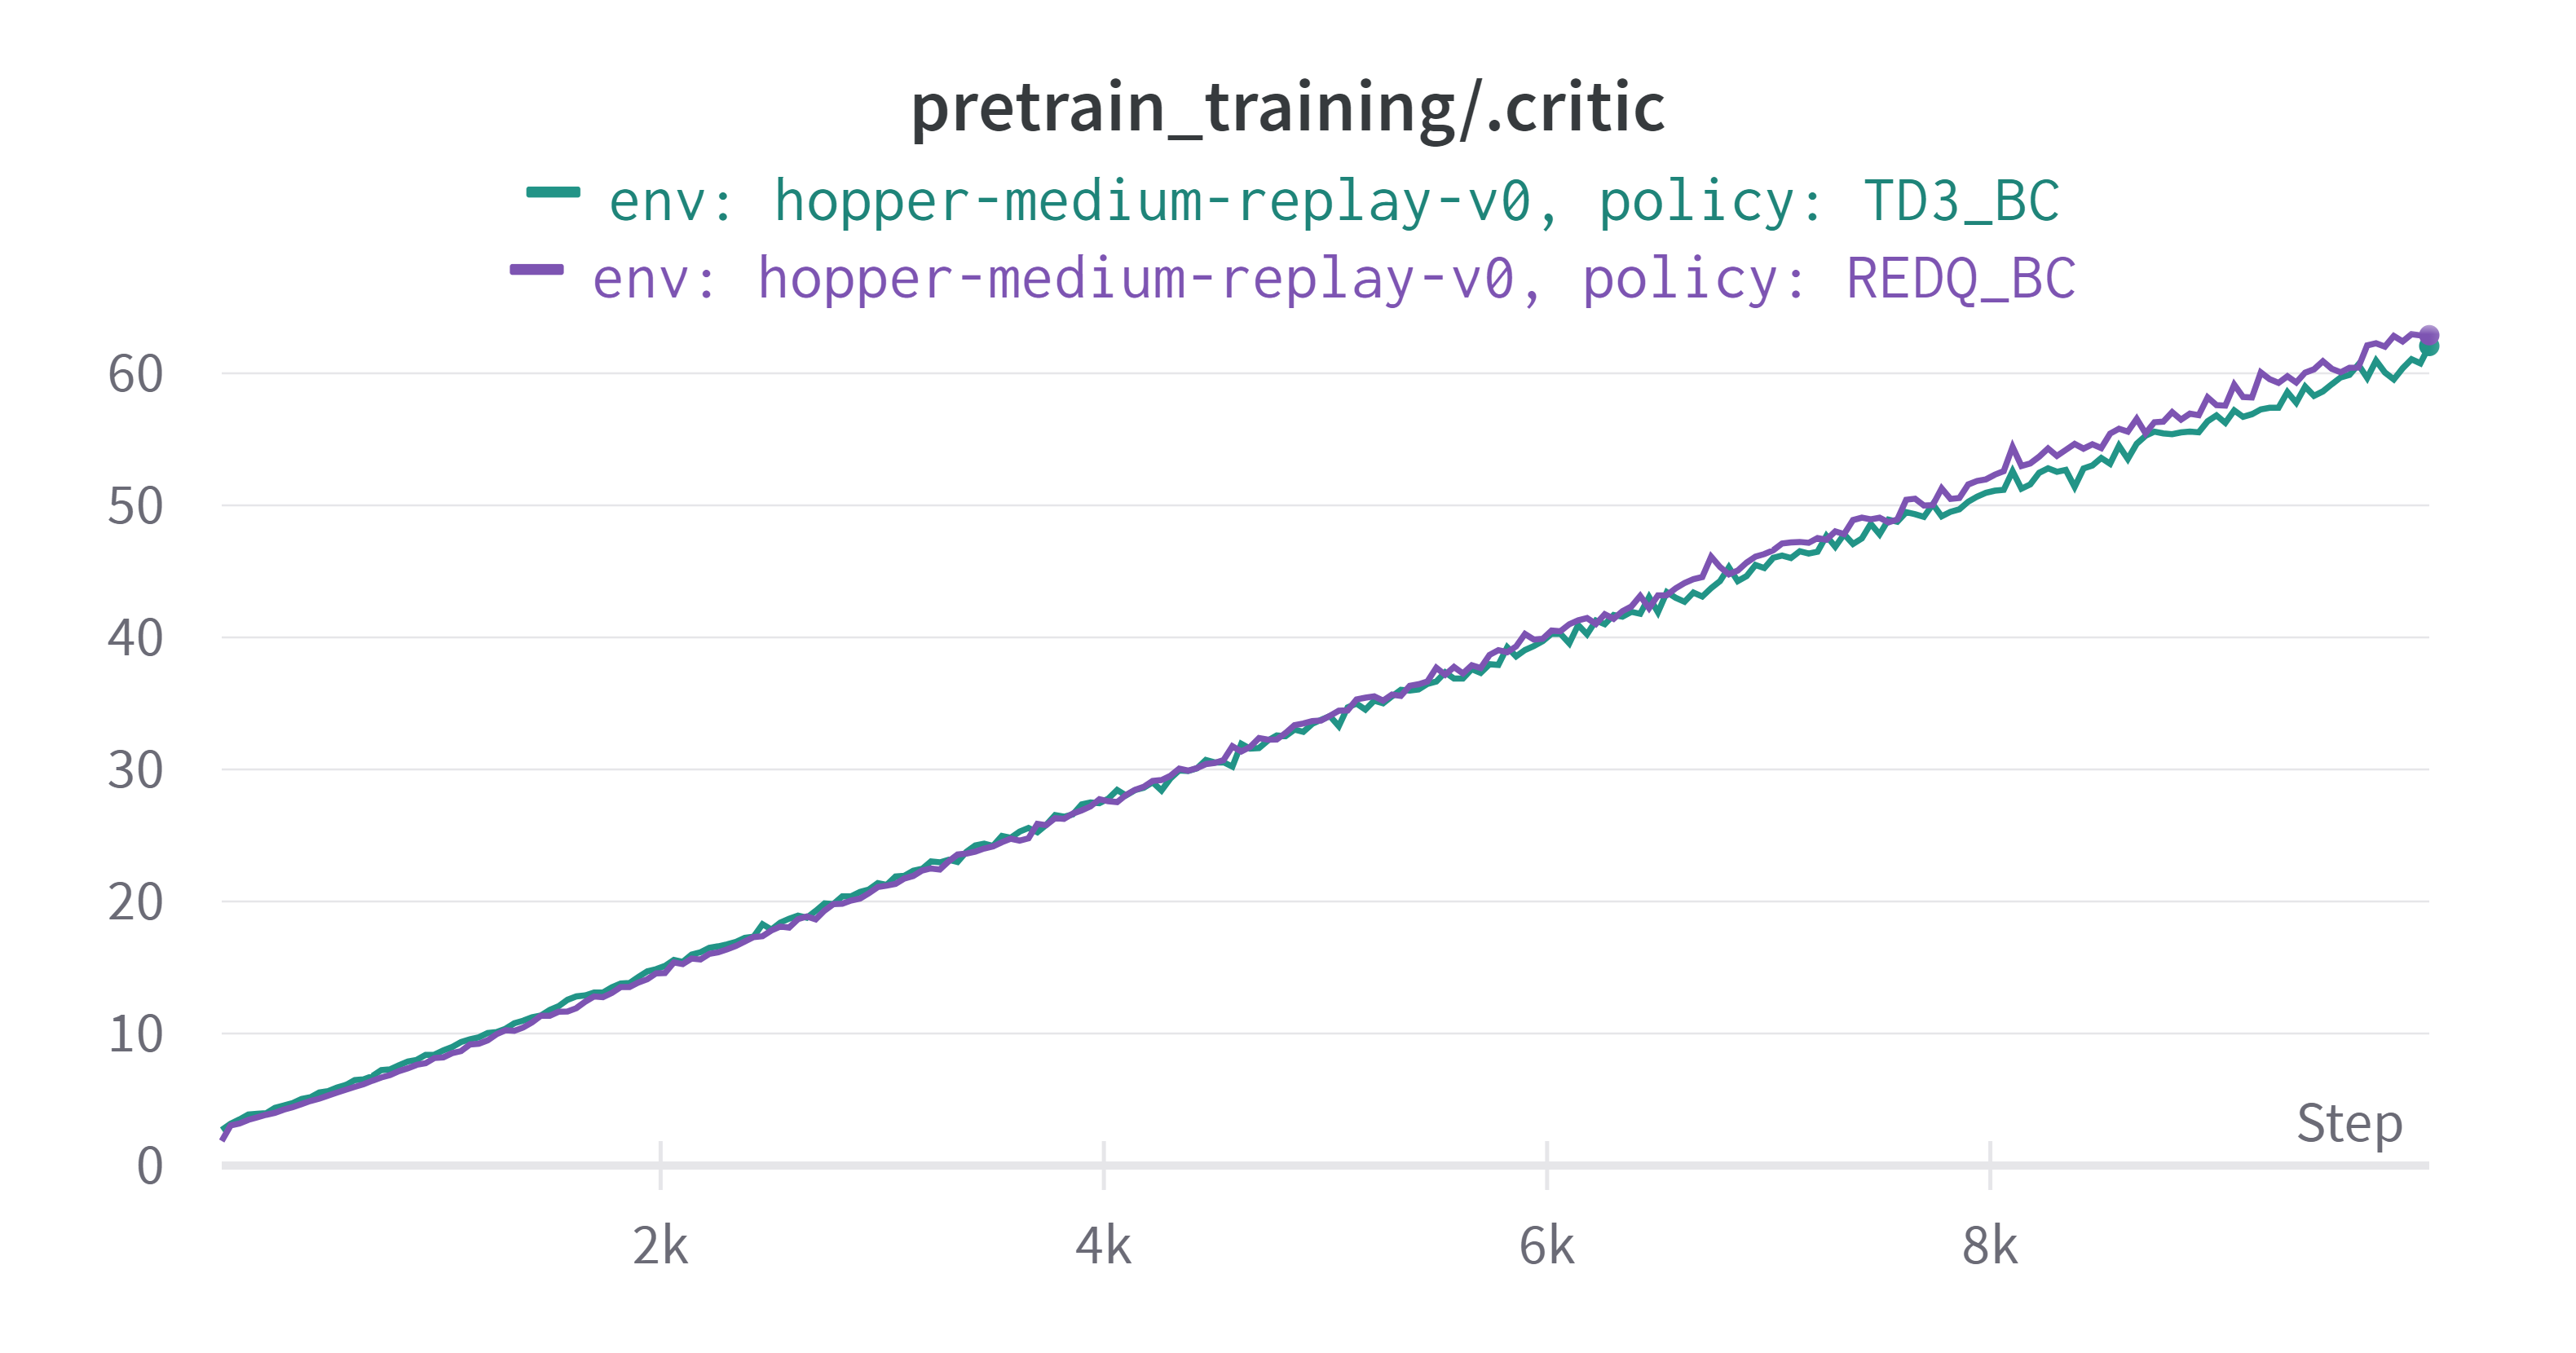

Из графика для функции потерь видно, что в среднем ее значение для метода TD3-BC (статья [A Minimalist Approach to Offline Reinforcement Learning](https://arxiv.org/abs/2106.06860)) лежат выше. Соответвенно качество обучение этого метода несколько хуже (т.к MSE-ошибка между текущими и желаемыми действиями практически все время получается больше).

К этому же выводу можно прийти и из занчений Q-функции. Пусть и не сильно, но к концу обучения можно заметить, что кривая для метода REDQ-BC (статья- [Adaptive Behavior Cloning Regularization for Stable Offline-to-Online Reinforcement Learning](https://arxiv.org/abs/2210.13846)) становится выше. Но при том хочется отметить, что на датасете такого размера отличия Q-функций 2-х методов при автономном обучении не велико.

Теперь сравним эти модели с помощью значений среднего вознаграждения (evaluation) и нормализованного оценочного балла (d4rl). Чем выше будут эти показатели, тем лучше обучение модели (ведь цель обучения агента в среде - максимизировать награду). Также мы следили за изменением средней длины эпизода (length)- еще одного качества обучения, но в данной работе, мне кажется, что достаточно остановиться на первых двух зависимостях 

P.s. Далее также буду производить сравнения опираясь именно на эти два критерия.

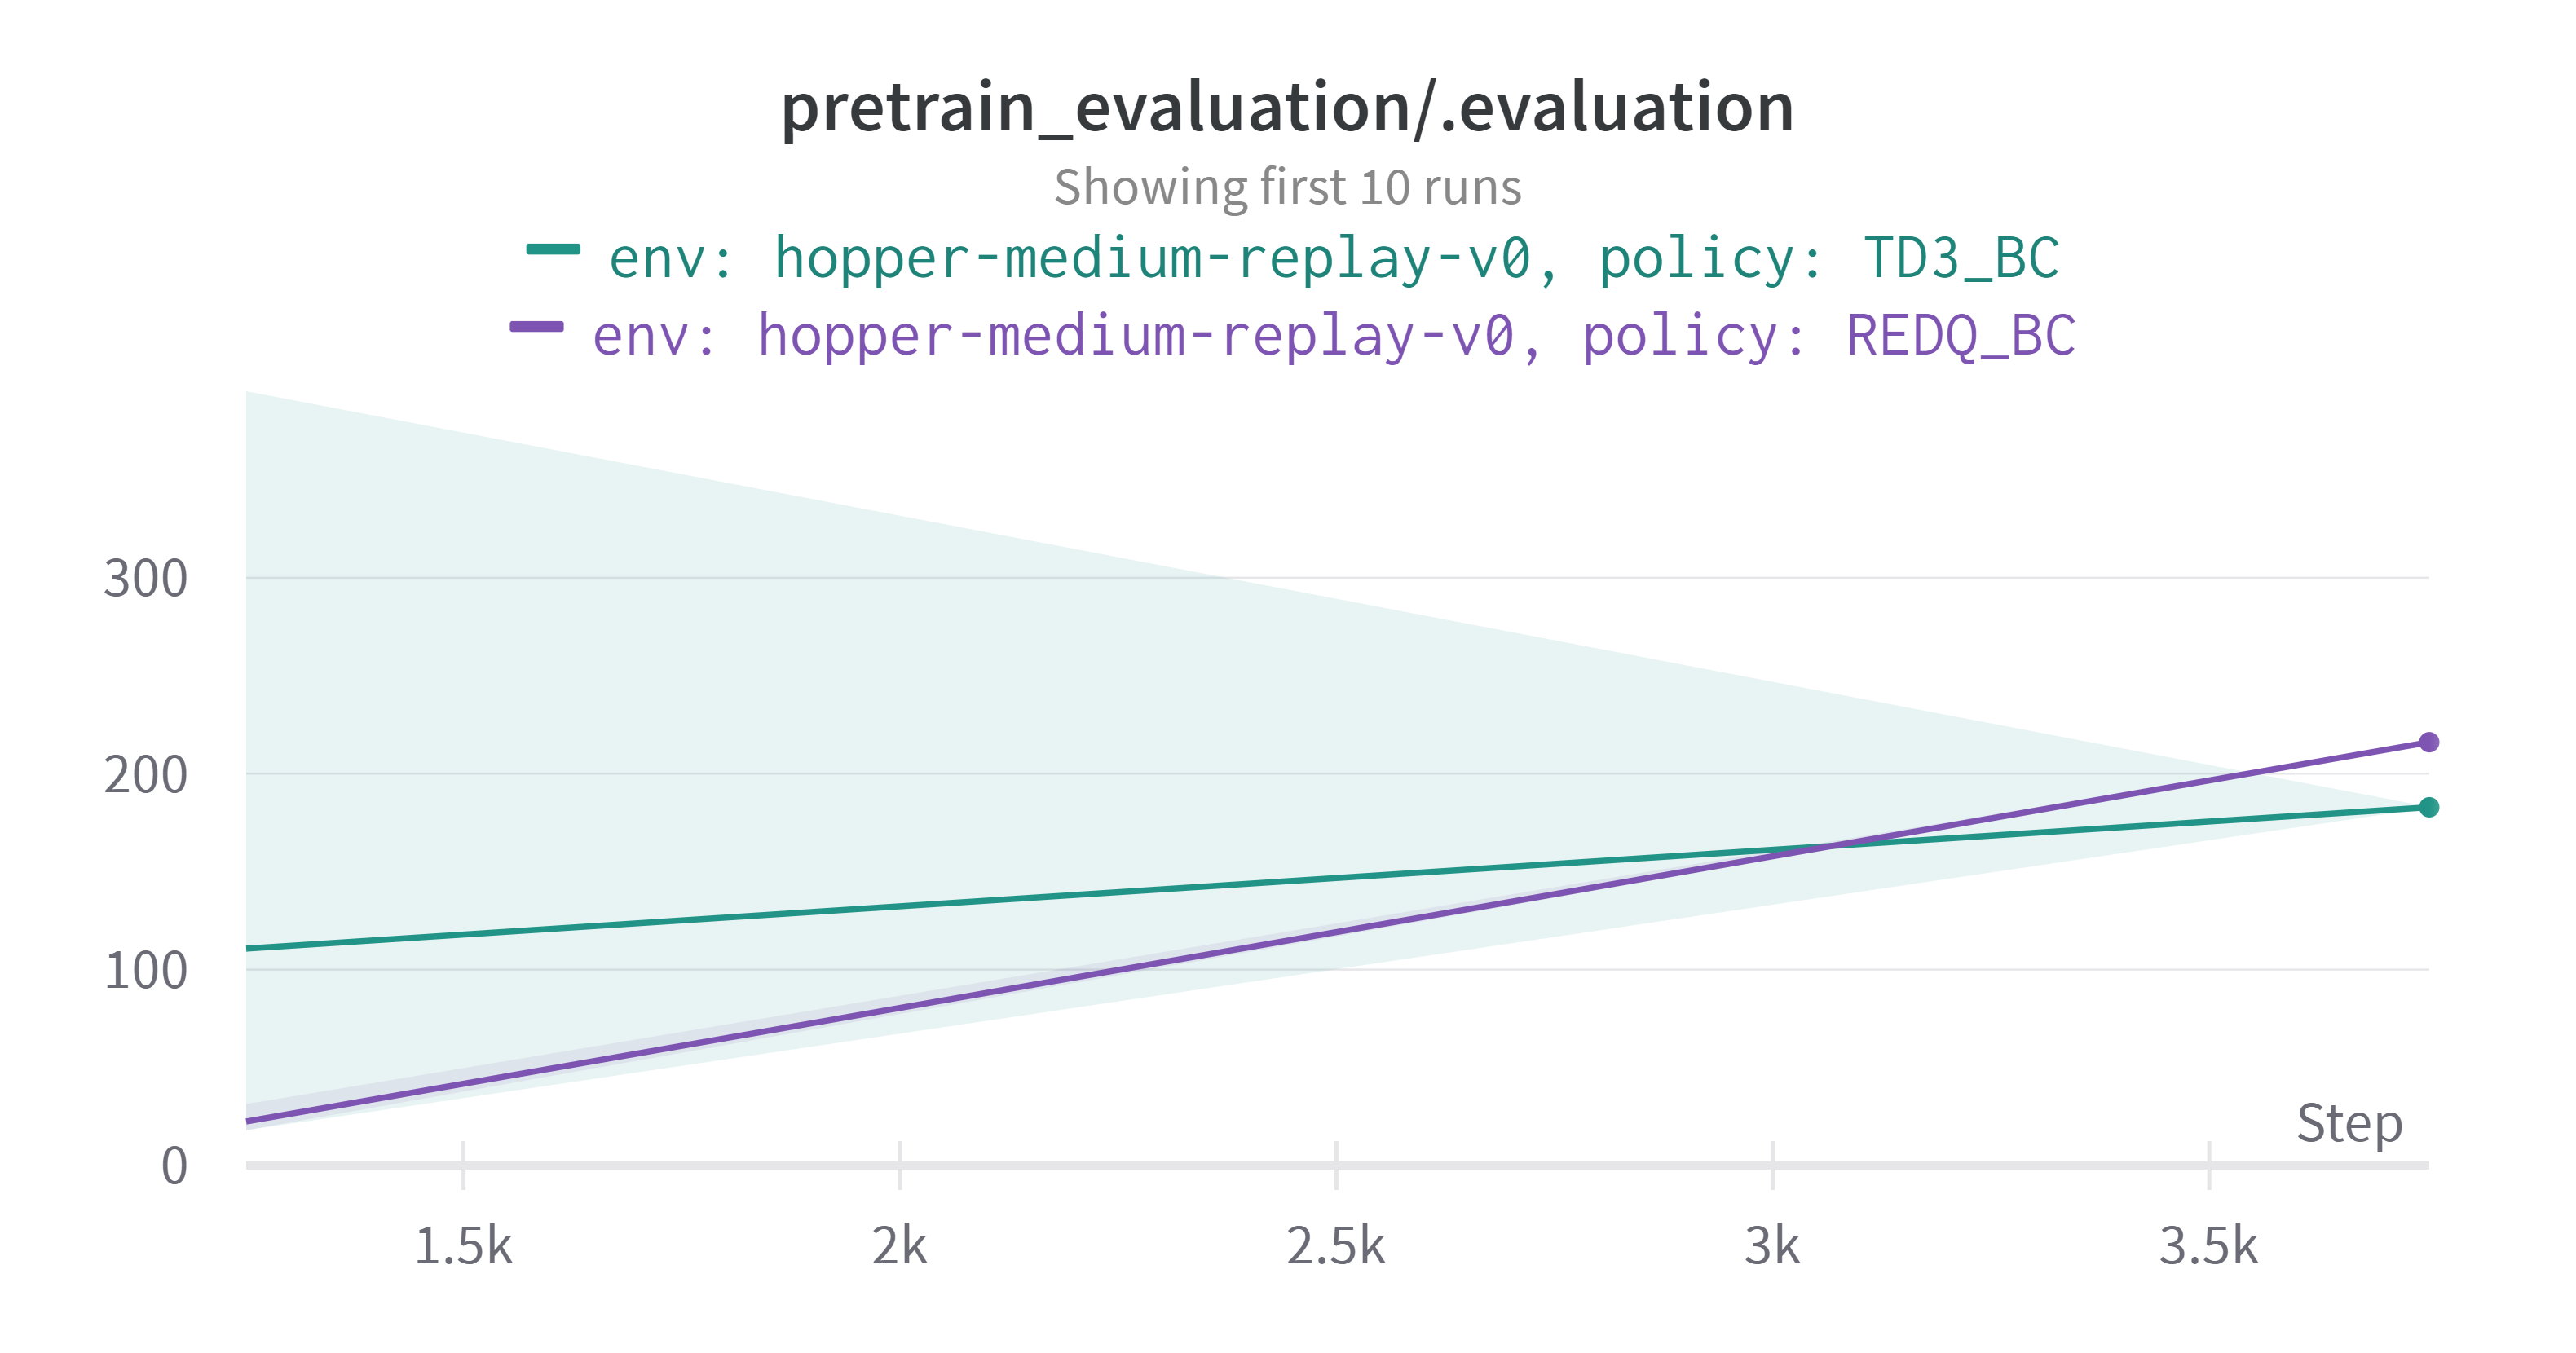

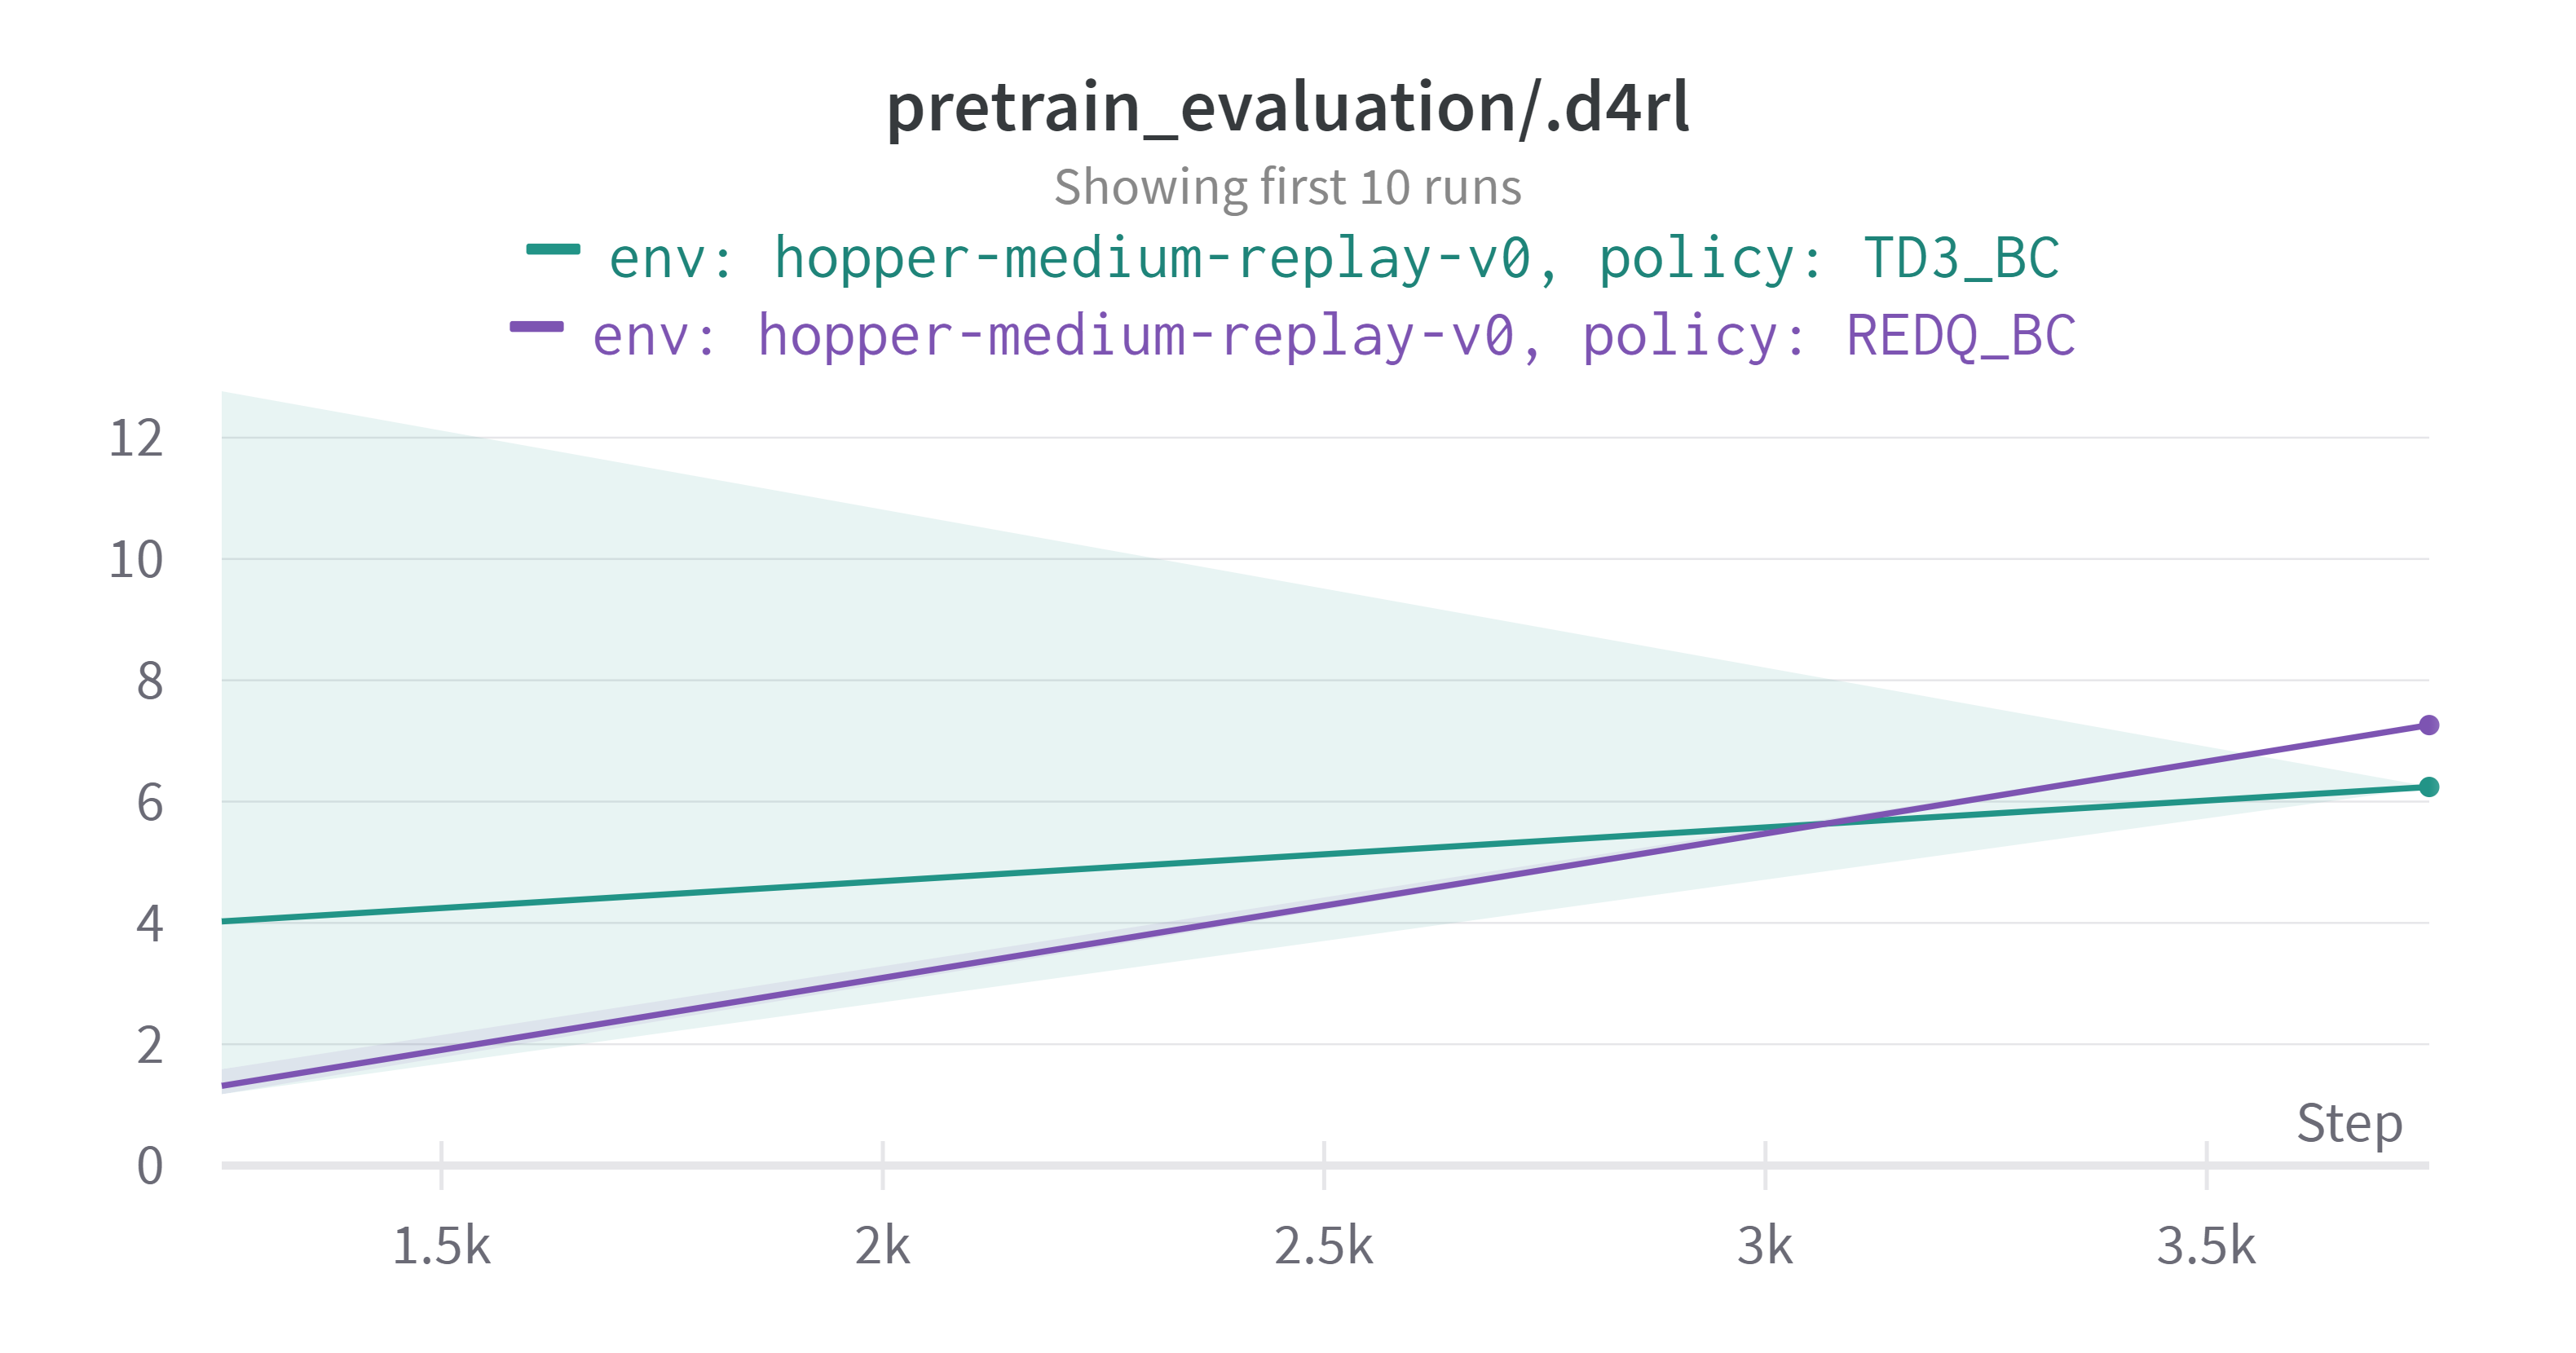

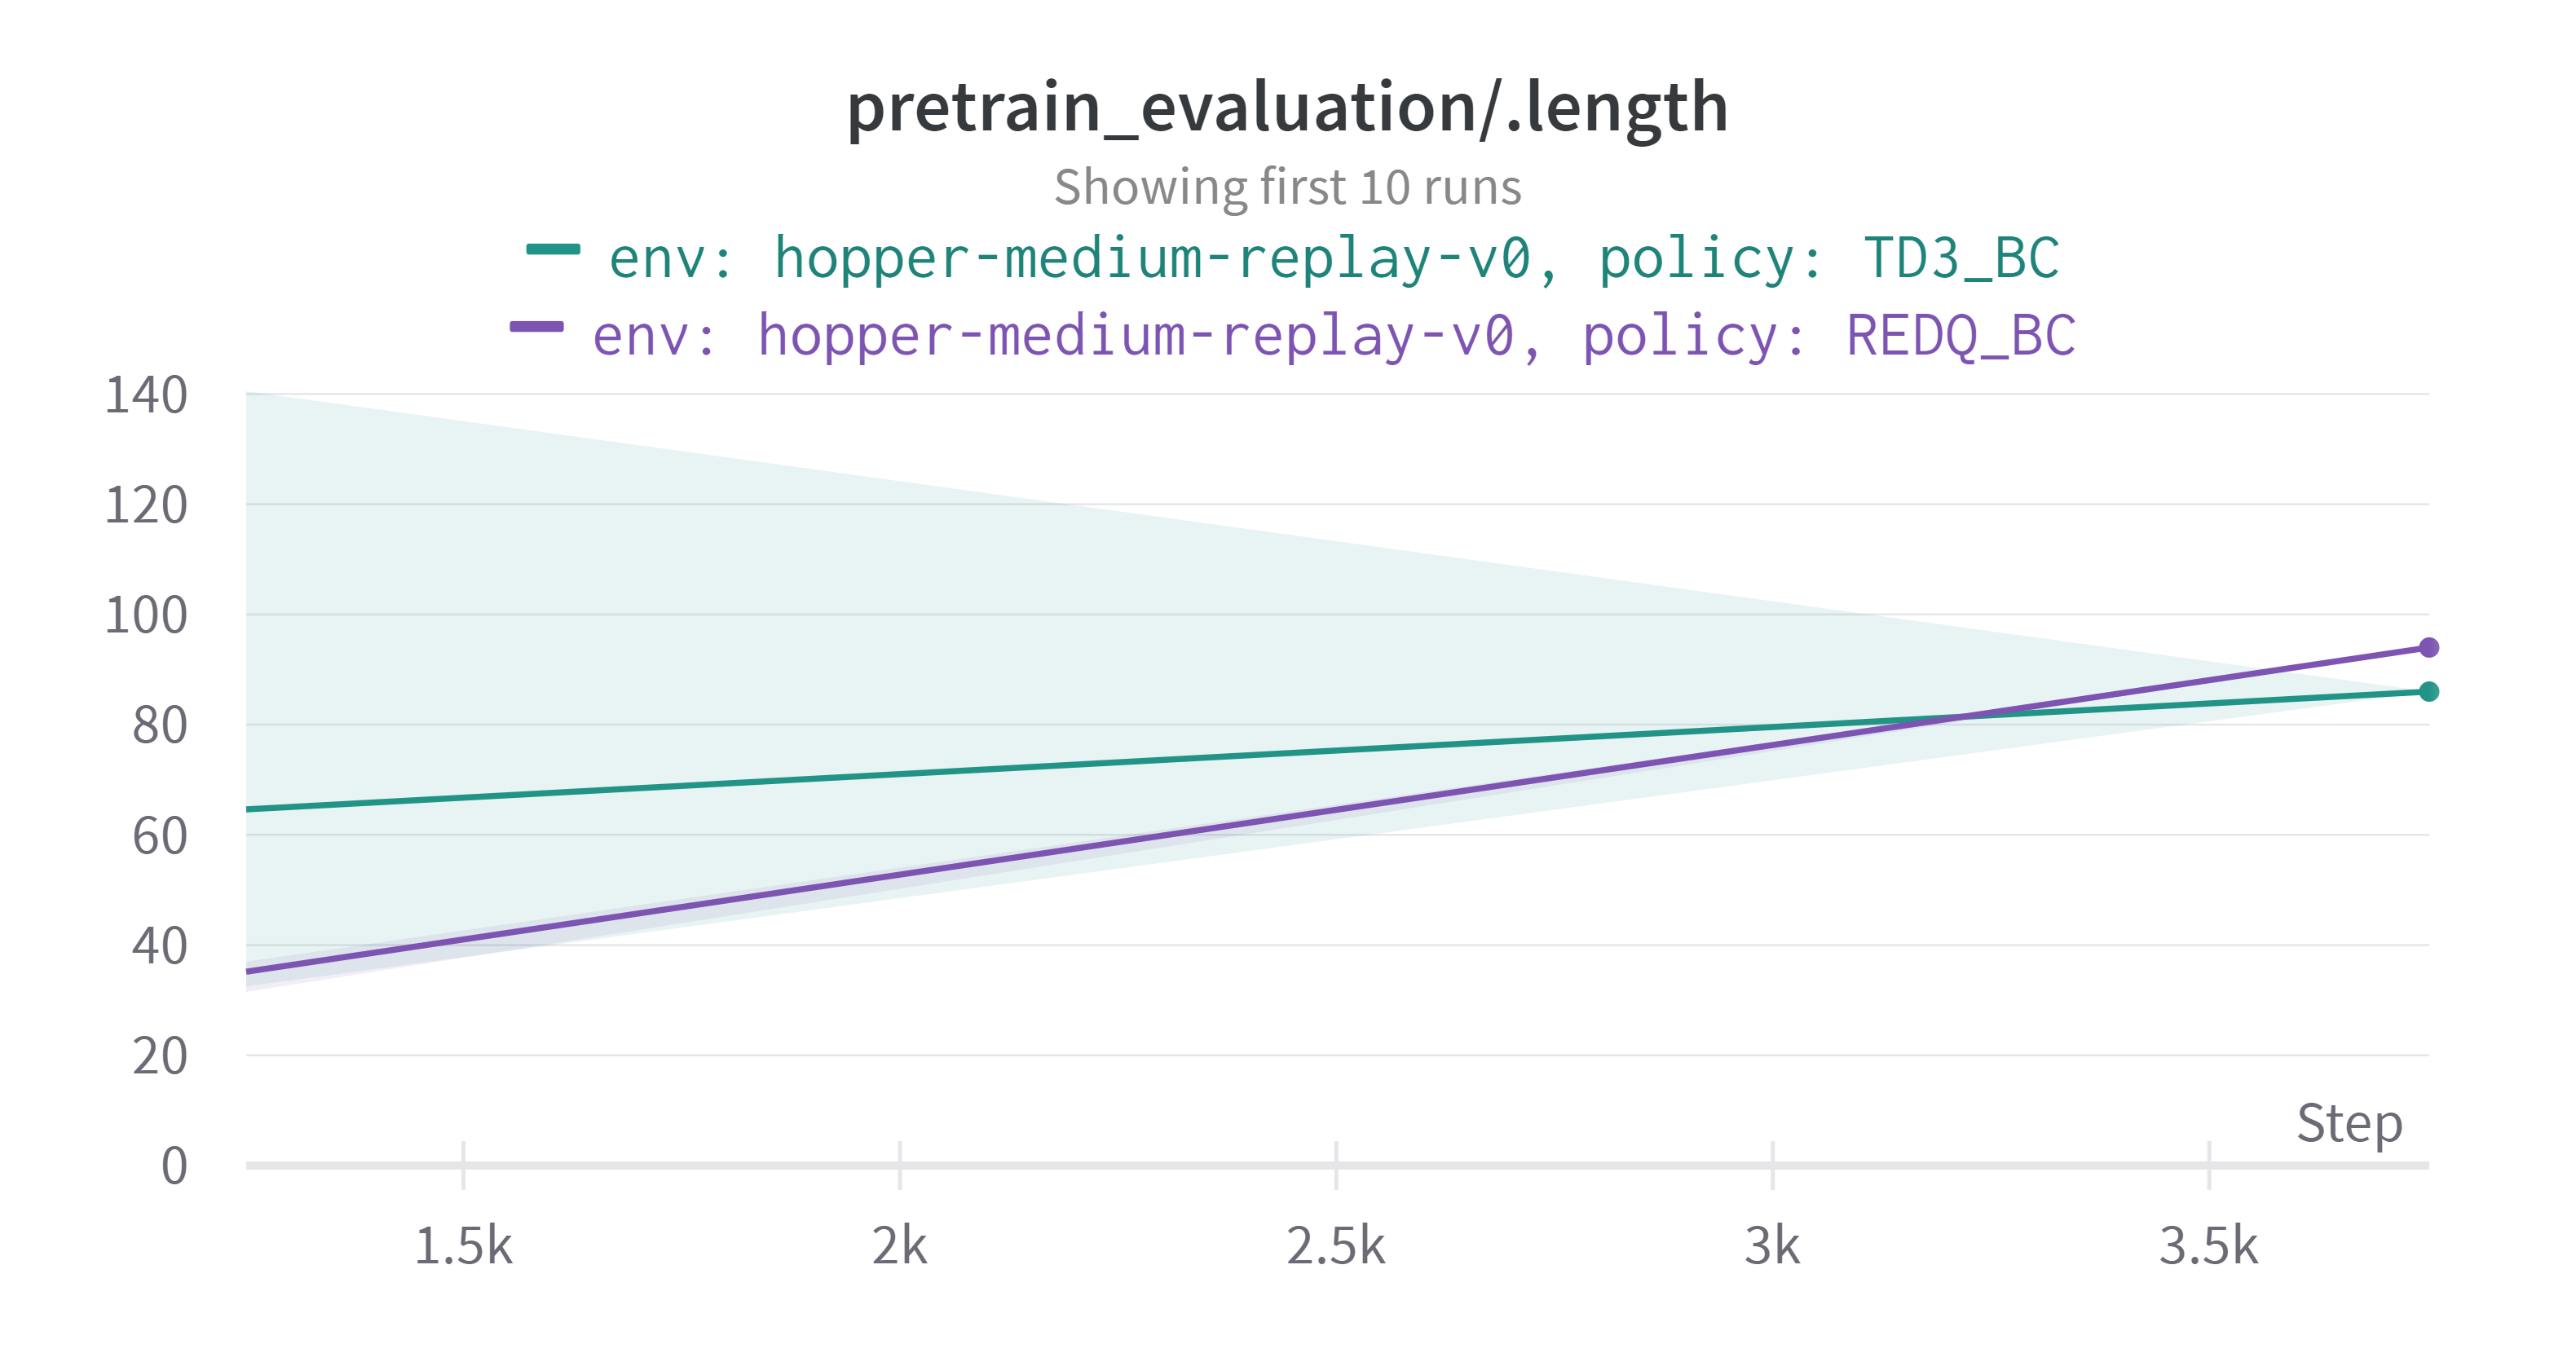

Из графиков видим, что по итогу REDQ-BC опять дает более высокое качество обучение, что подтверждает выводы сделанные на основе функции потерь выше.

Теперь перейдем к сравнению методов при онлайн-обучении. Опять сначала воспользуемся функцией потерь и значениями Q-функции.

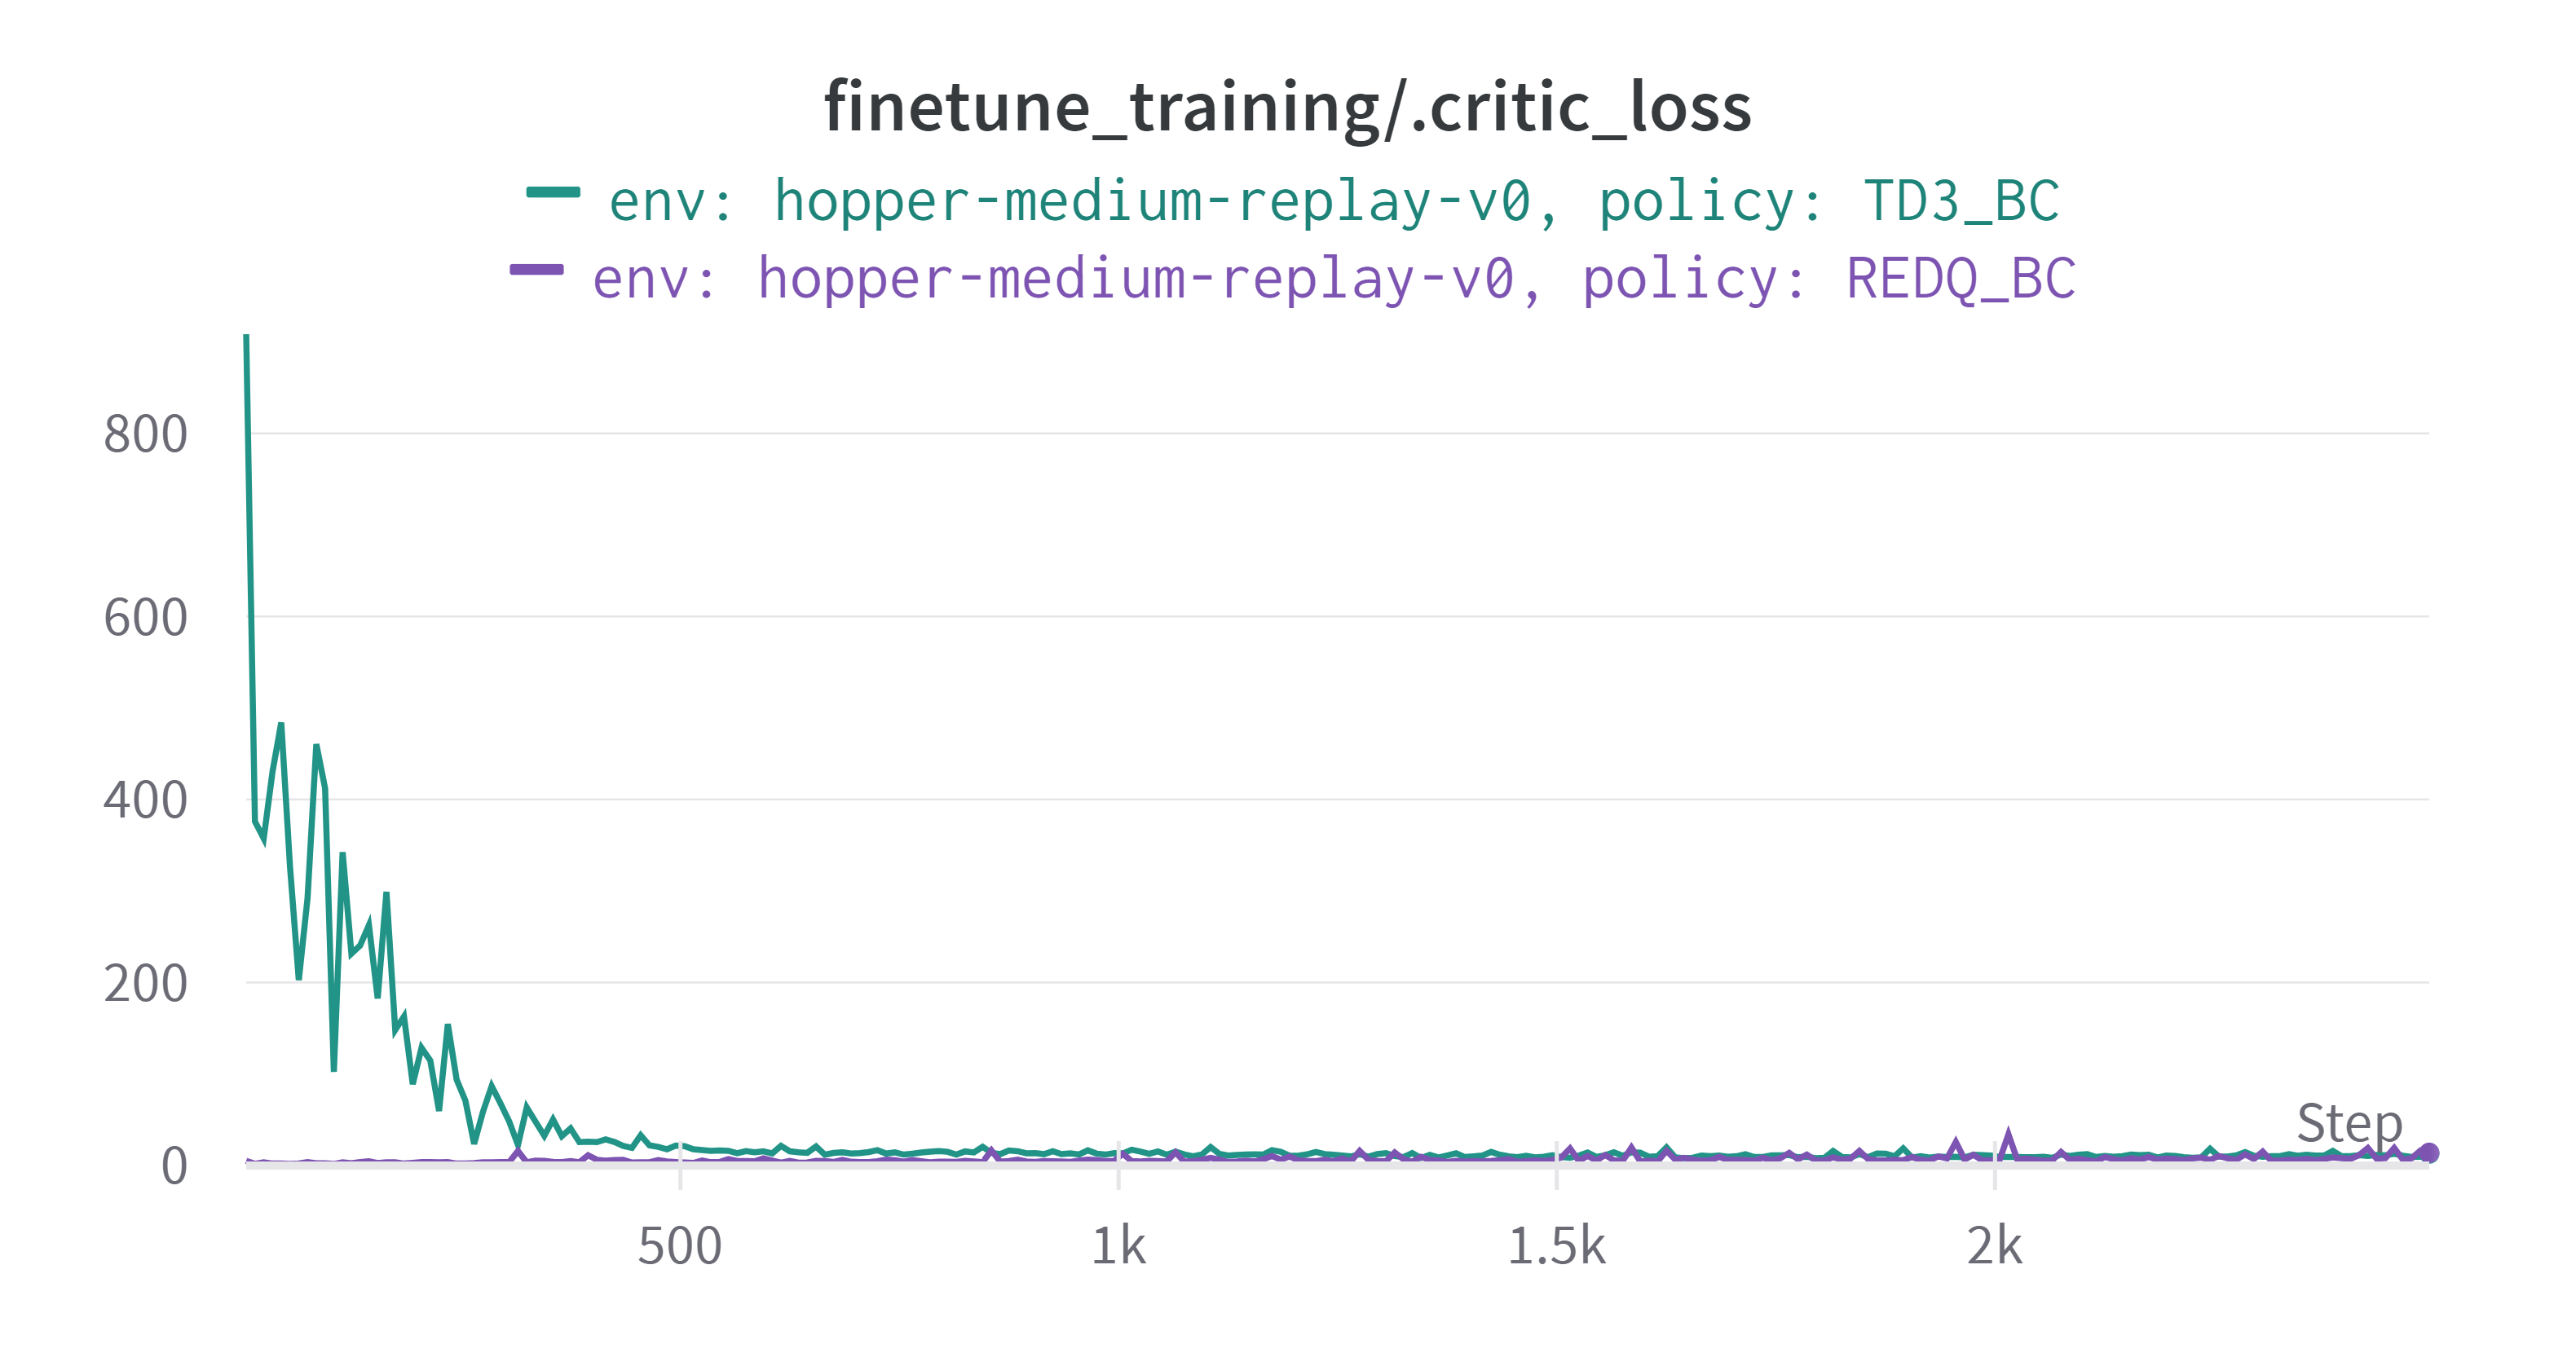

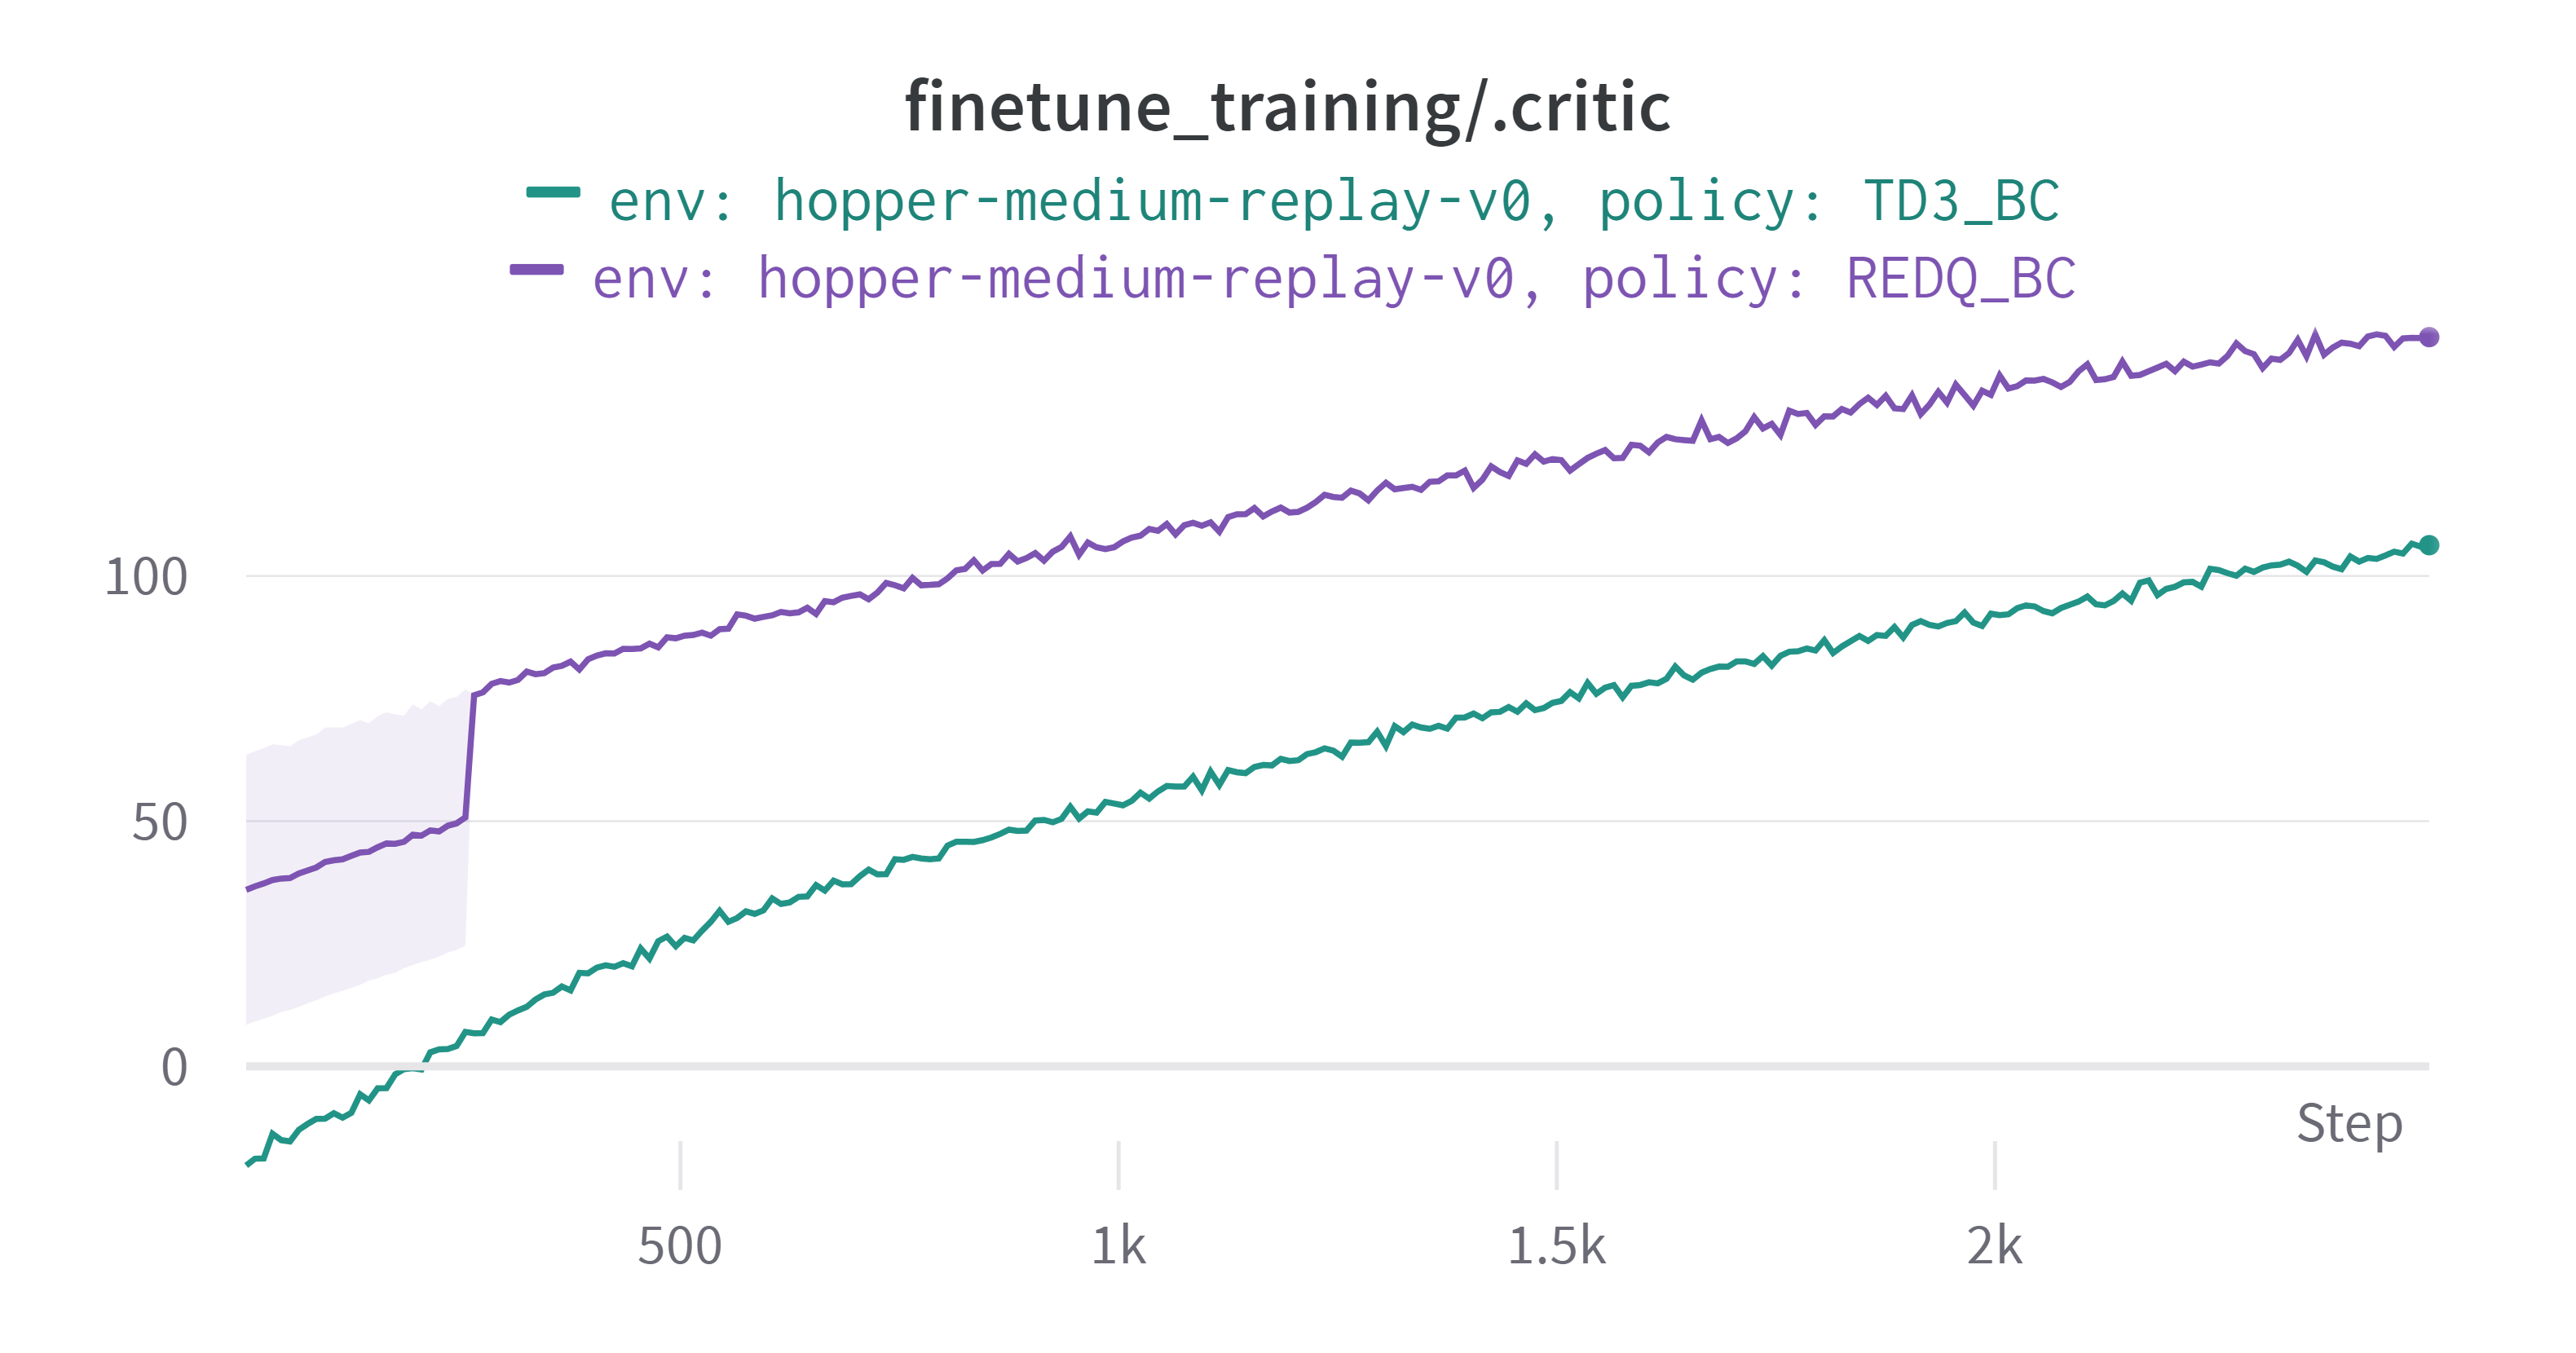

Наиболее важным фактом при анализе critic_loss мне кажется, то что в начале обучения функция потерь TD3-BC на порядки хуже чем функция для REDQ-BC. Это означает, что перестройка от оффлайн к онлайн обучению несравнимо лучше у второго (фиолетового) метода. Позже обе кривые становятся достаточно близки друг к другу. Но как можно видеть уже из графика critic REDQ-DC во время всего процесса обучения остается лучше. А также значение Q-функции метода TD3-BC практически не приближаются ко второй Q-функции, представленной на этом графике.

Теперь перейдем к анализу среднего вознаграждения и нормализованного оценочного балла при онлайн обучении


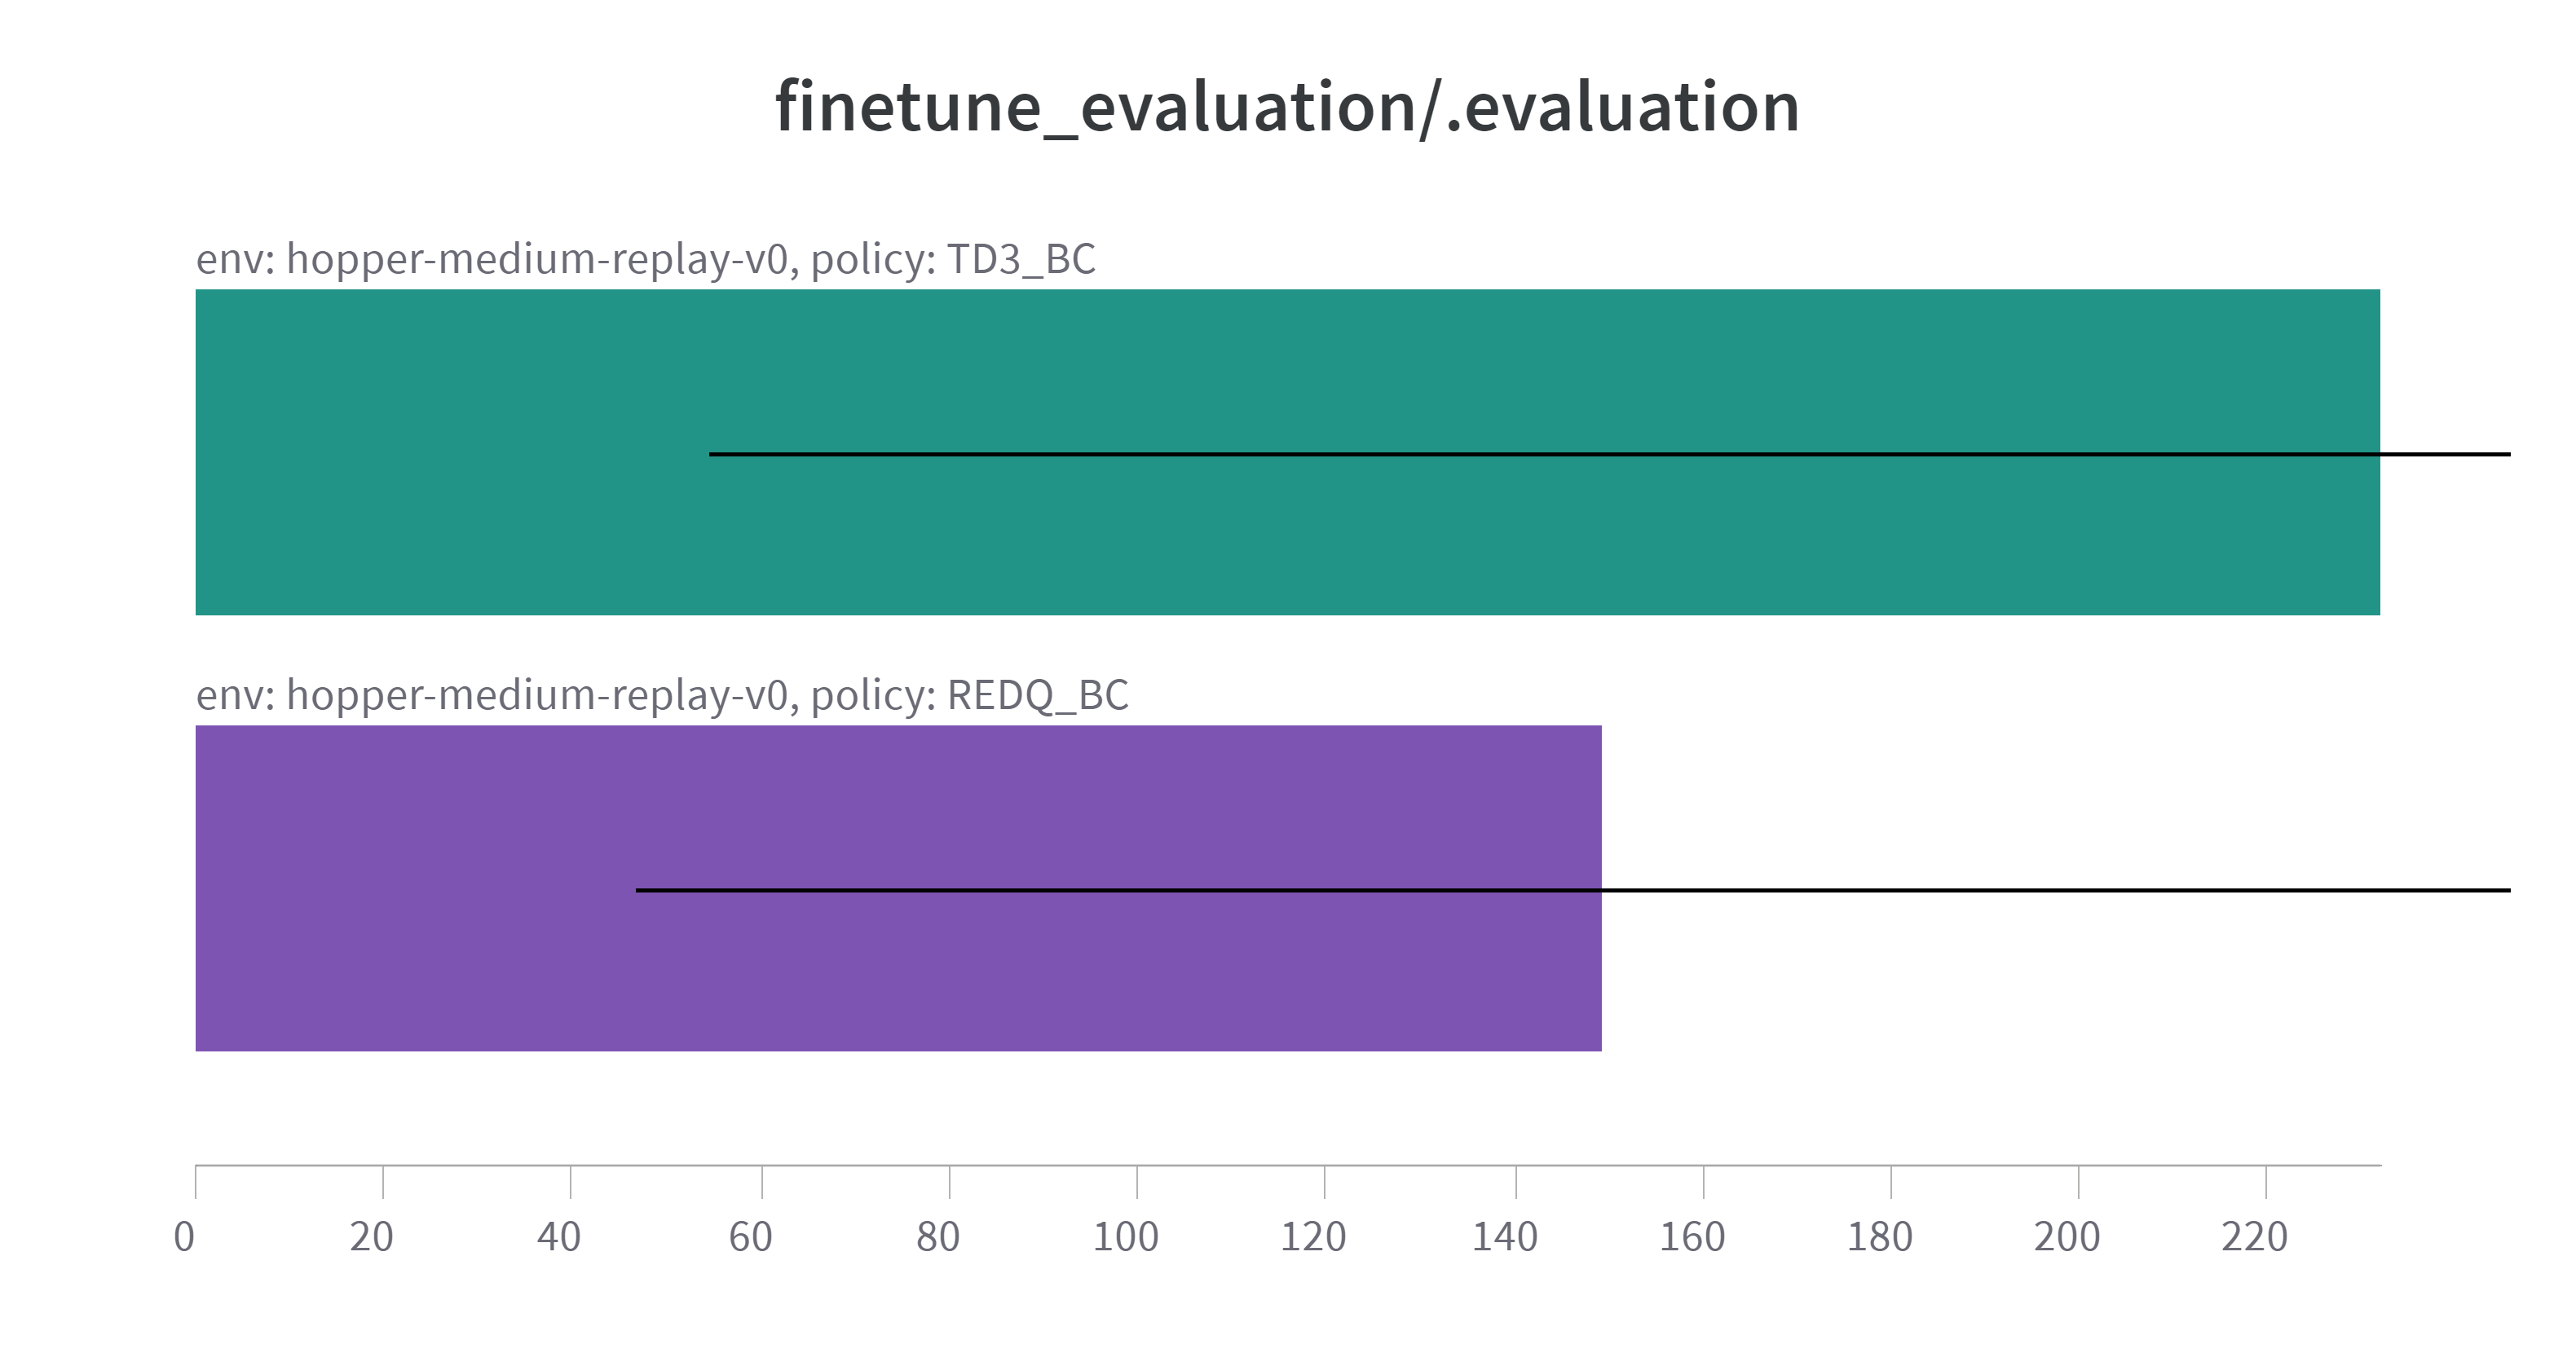

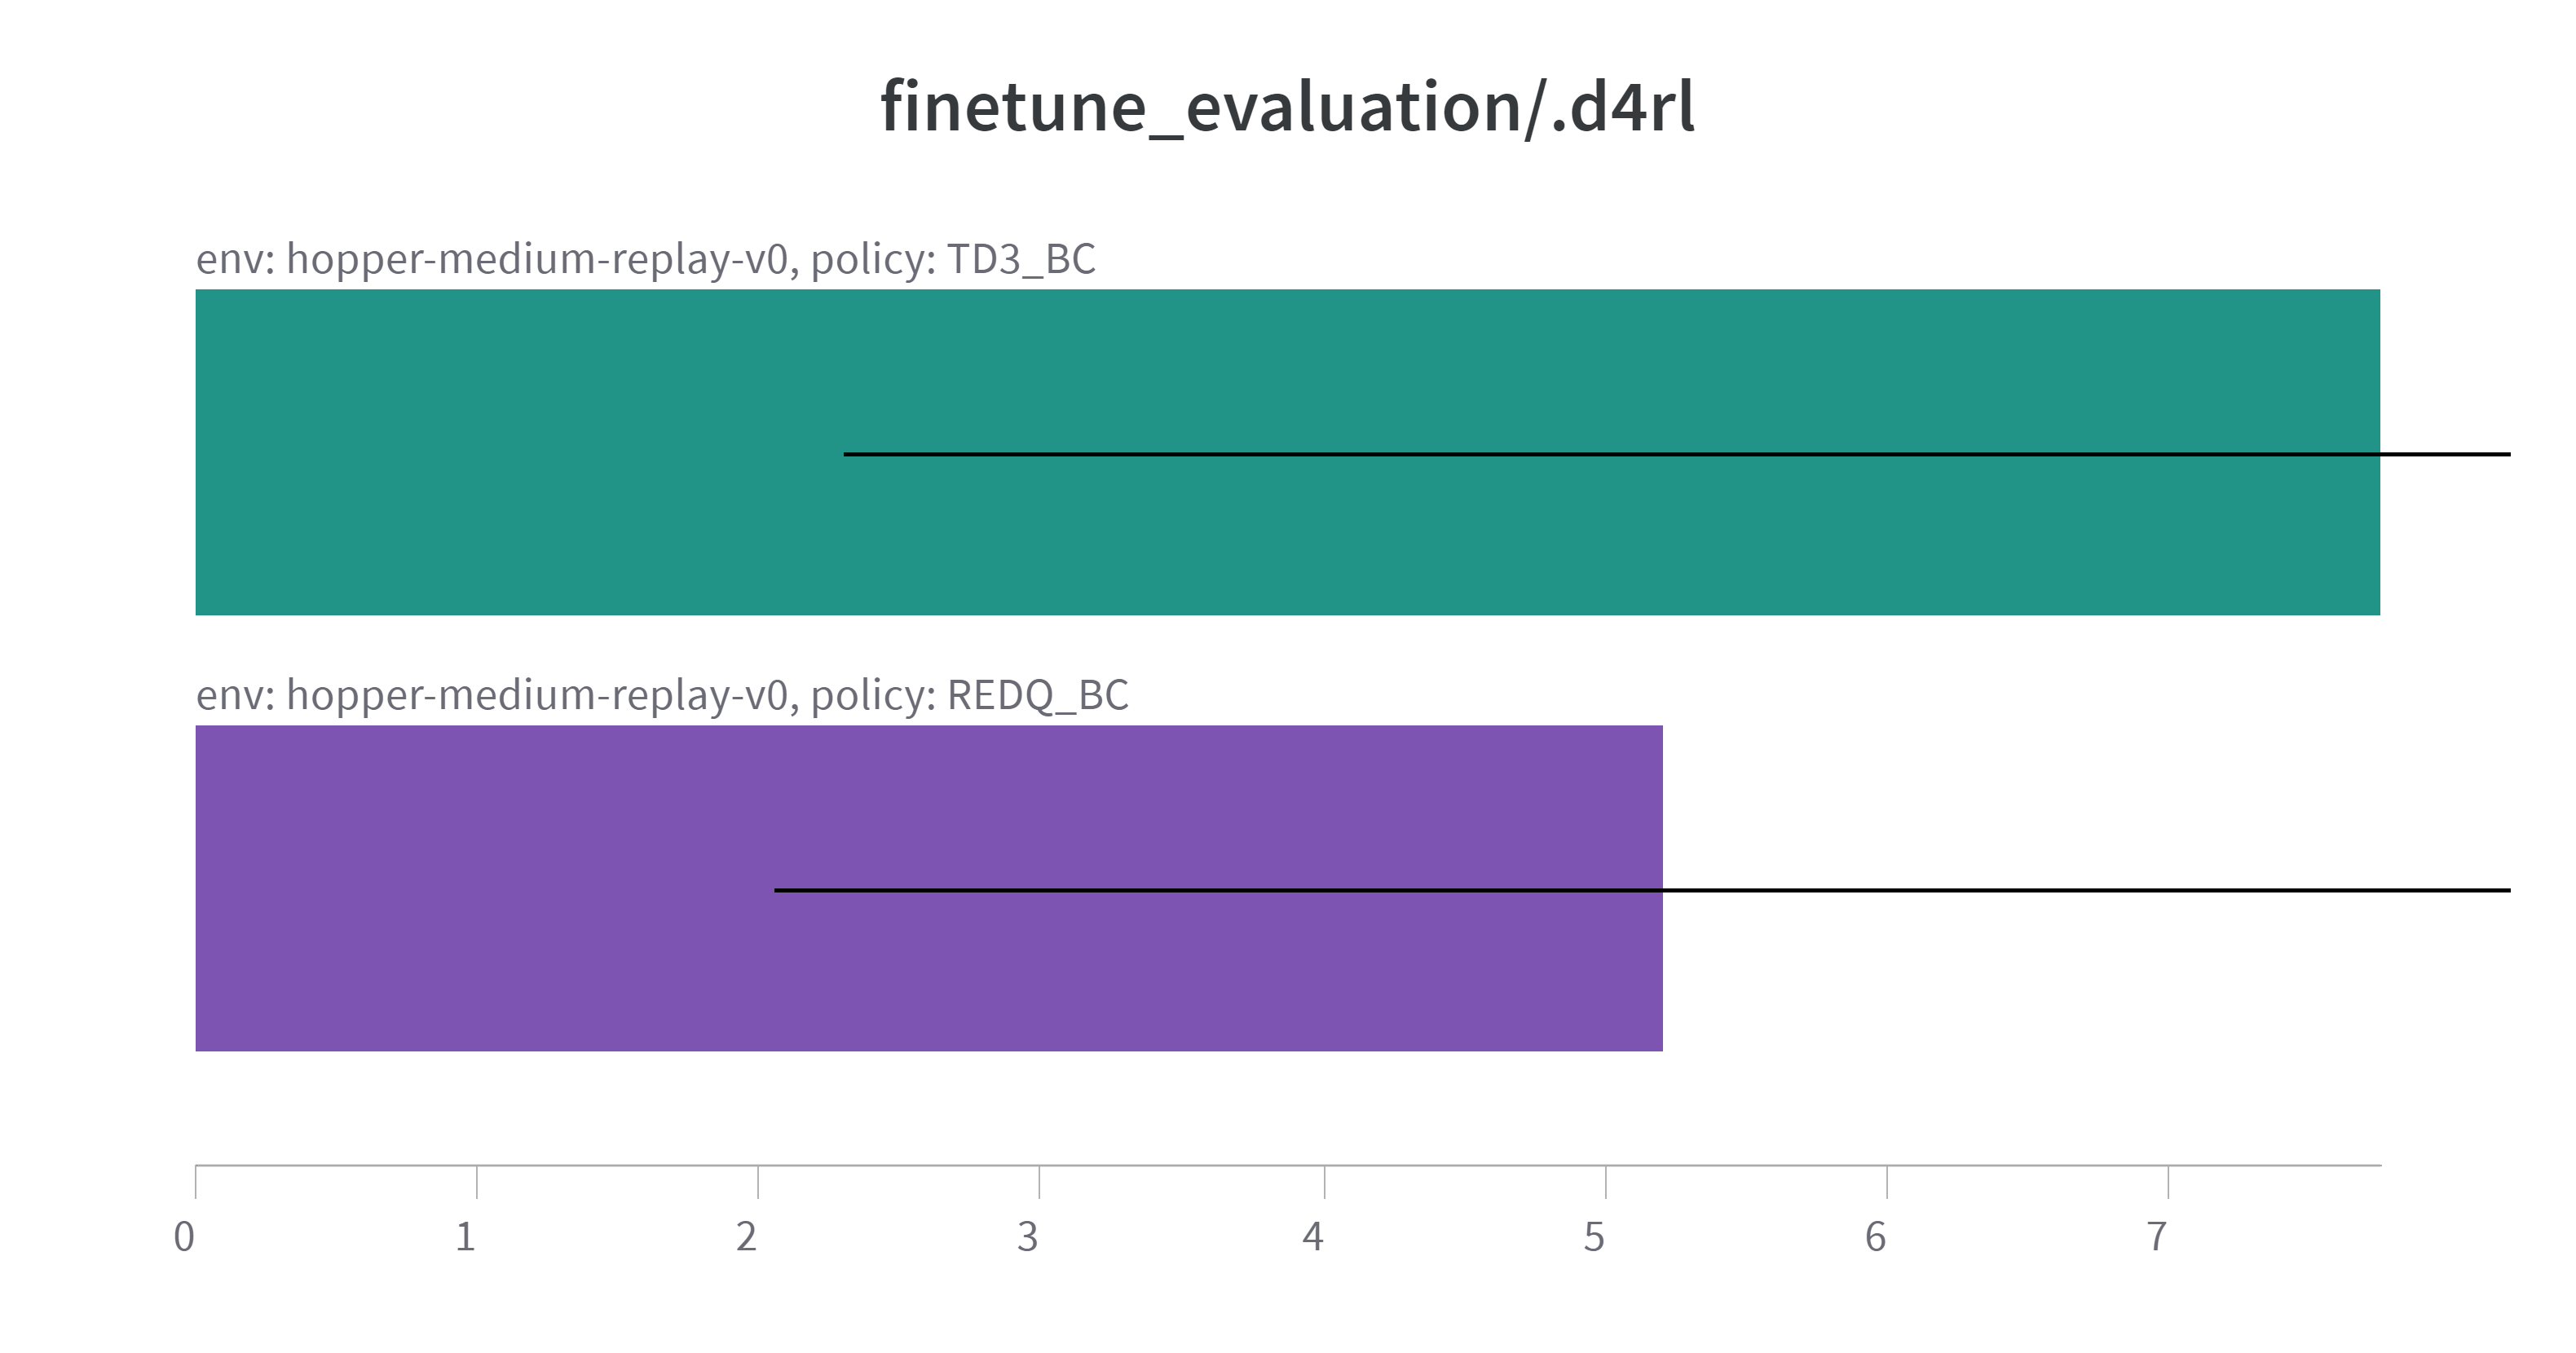

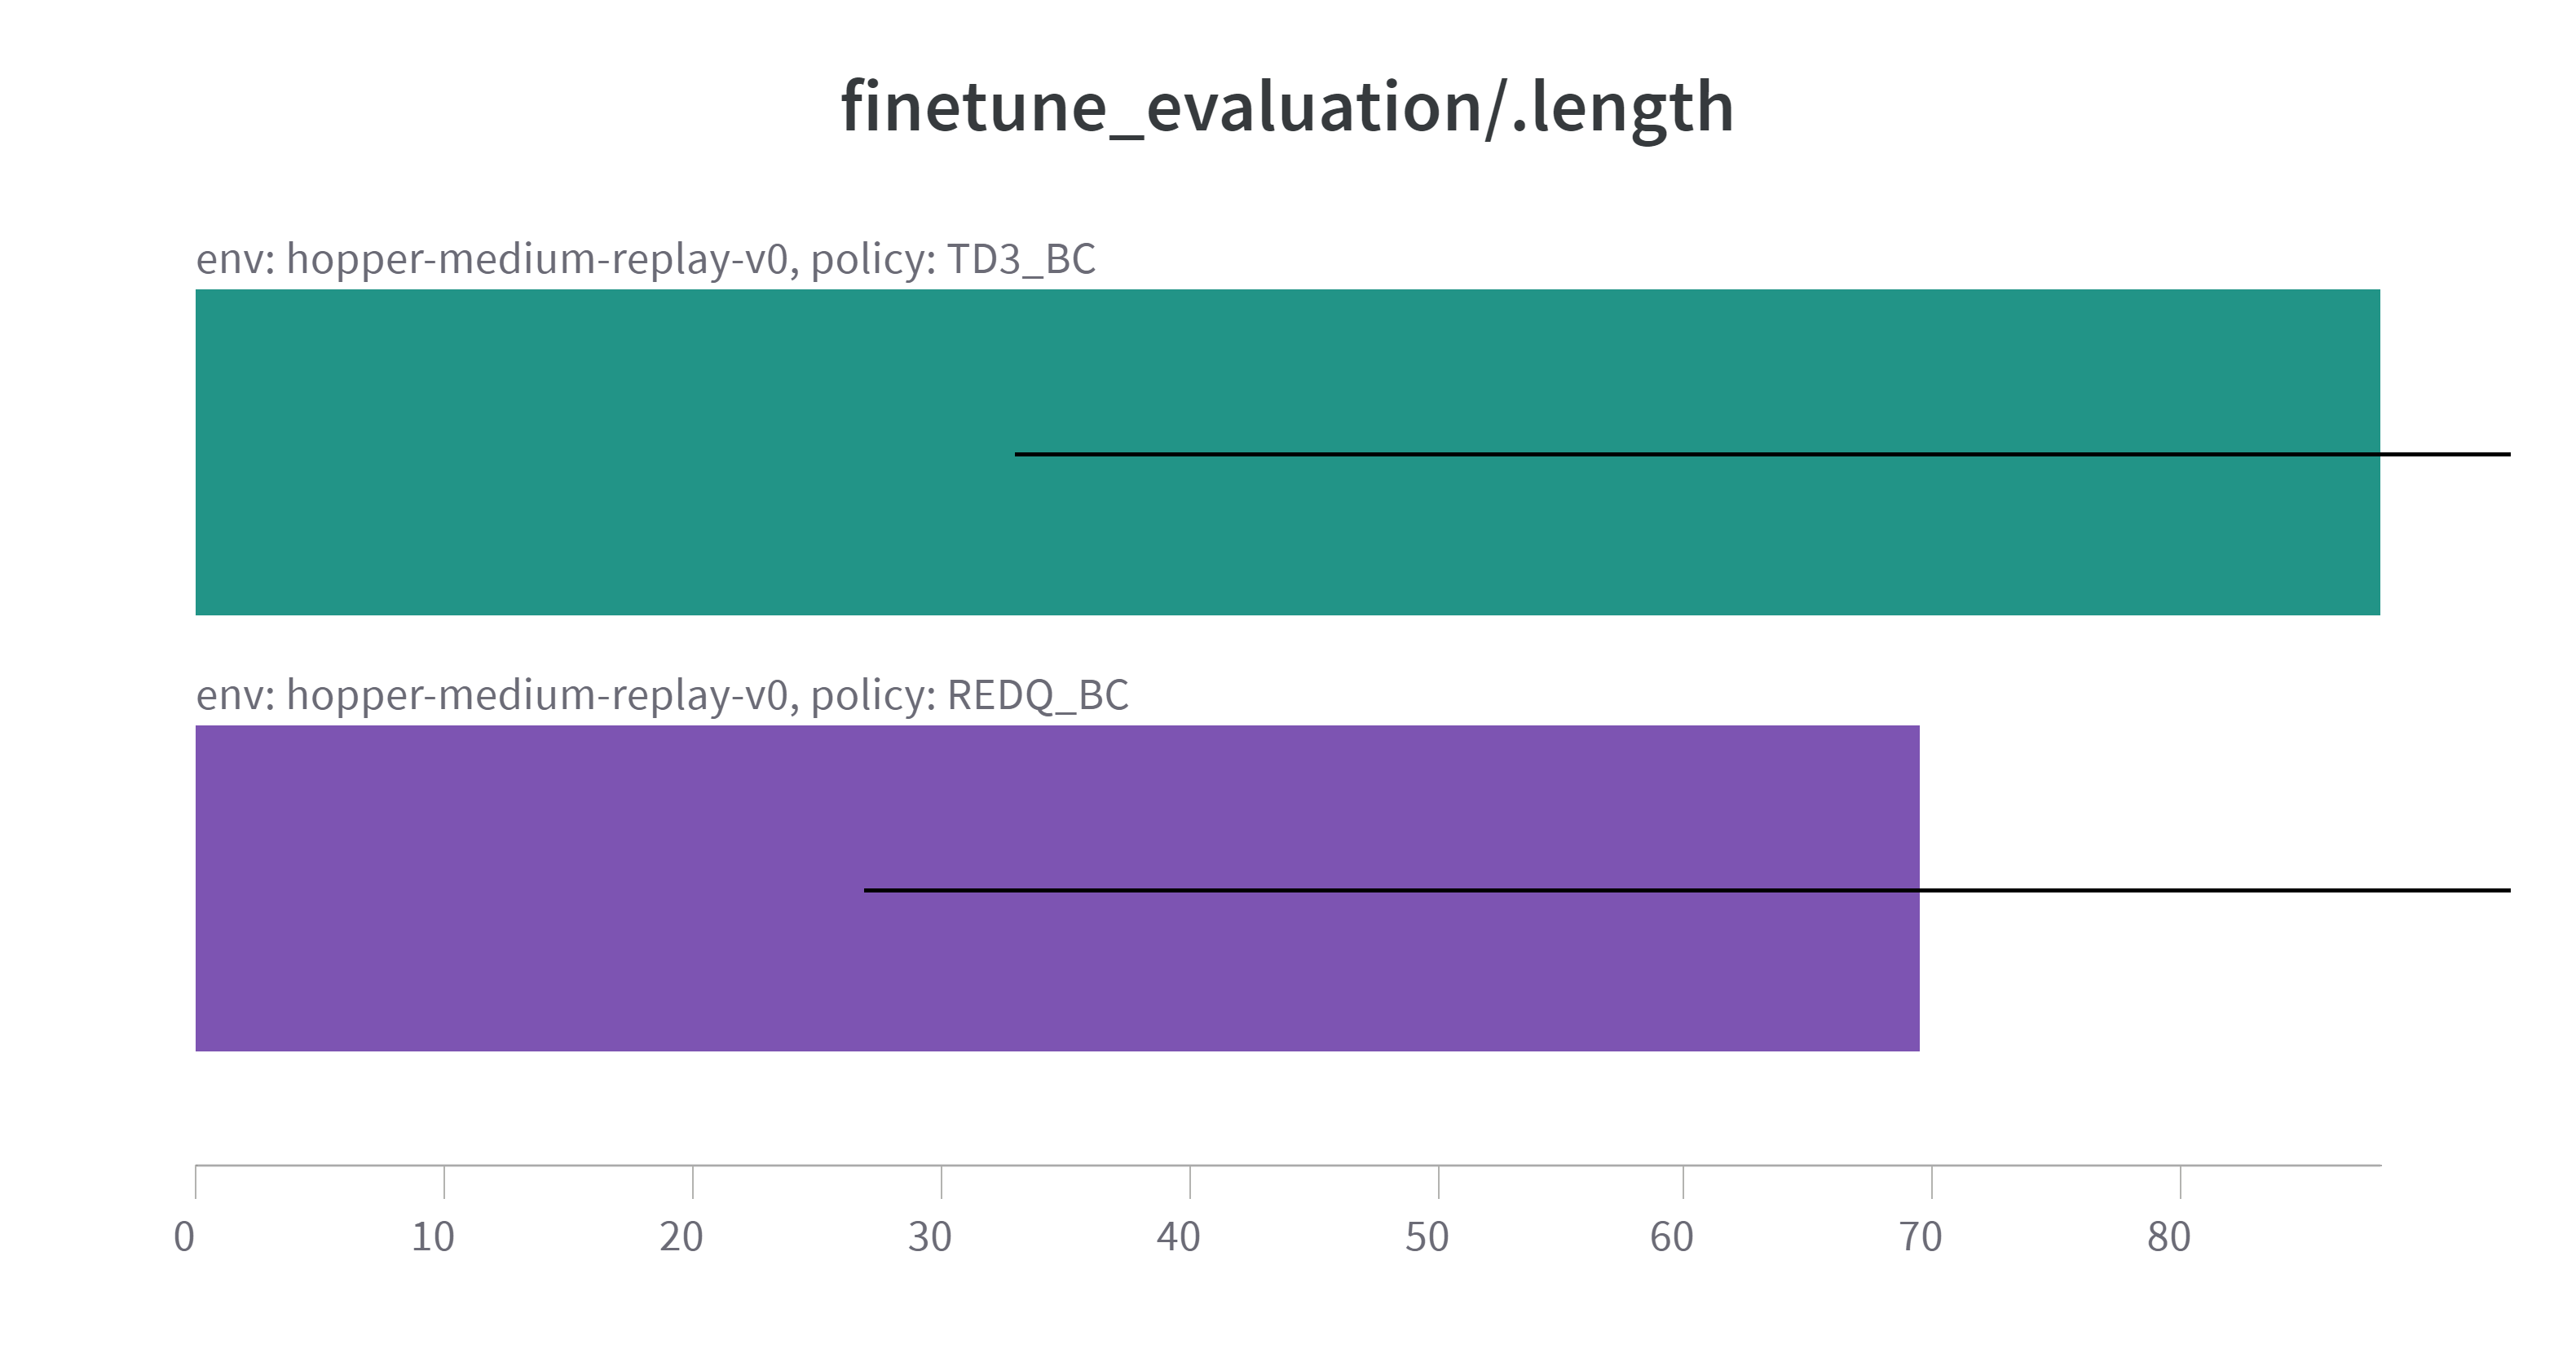

Здесь мы наблюдаем довольно неожиданные результаты. Ведь как обсуждалось ранее, чем выше показатели evaluation и d4rl, тем обучение качественнее. Тогда выходит, что результаты не сходятся с тем, что мы видели на finetune_training

Можем выдвинуть предлопожение, что такие итоги в первую очередь связаны с тем, что здесь данные усредняются за все время обучения и тогда **в среднем** действительно TD3-BC может оказаться лучше относительно рассматриваемых в finetune_evaluation параметров.

В этой работе же нам интерсно сравнить эволюцию качества обучения во времени (и в частности преход от автономного к онлайн обучению). В этом случае имеетт смысл делать выводы на основе графиков critic и critic-loss.

Таким образом REDQ-BC превосходит TD3-BC и в онлайн-обучении.

2. Теперь перейдем к сравнению моделей *на датасете walker2d-medium-replay*

Так как многие особенности полученных данных мы уже обсудили в предыдущем пункте, то здесь подробно обсудим только отличия обучения моделей на этих датасетах.

Как и в прошлый раз начнем с оффлайн-обучения

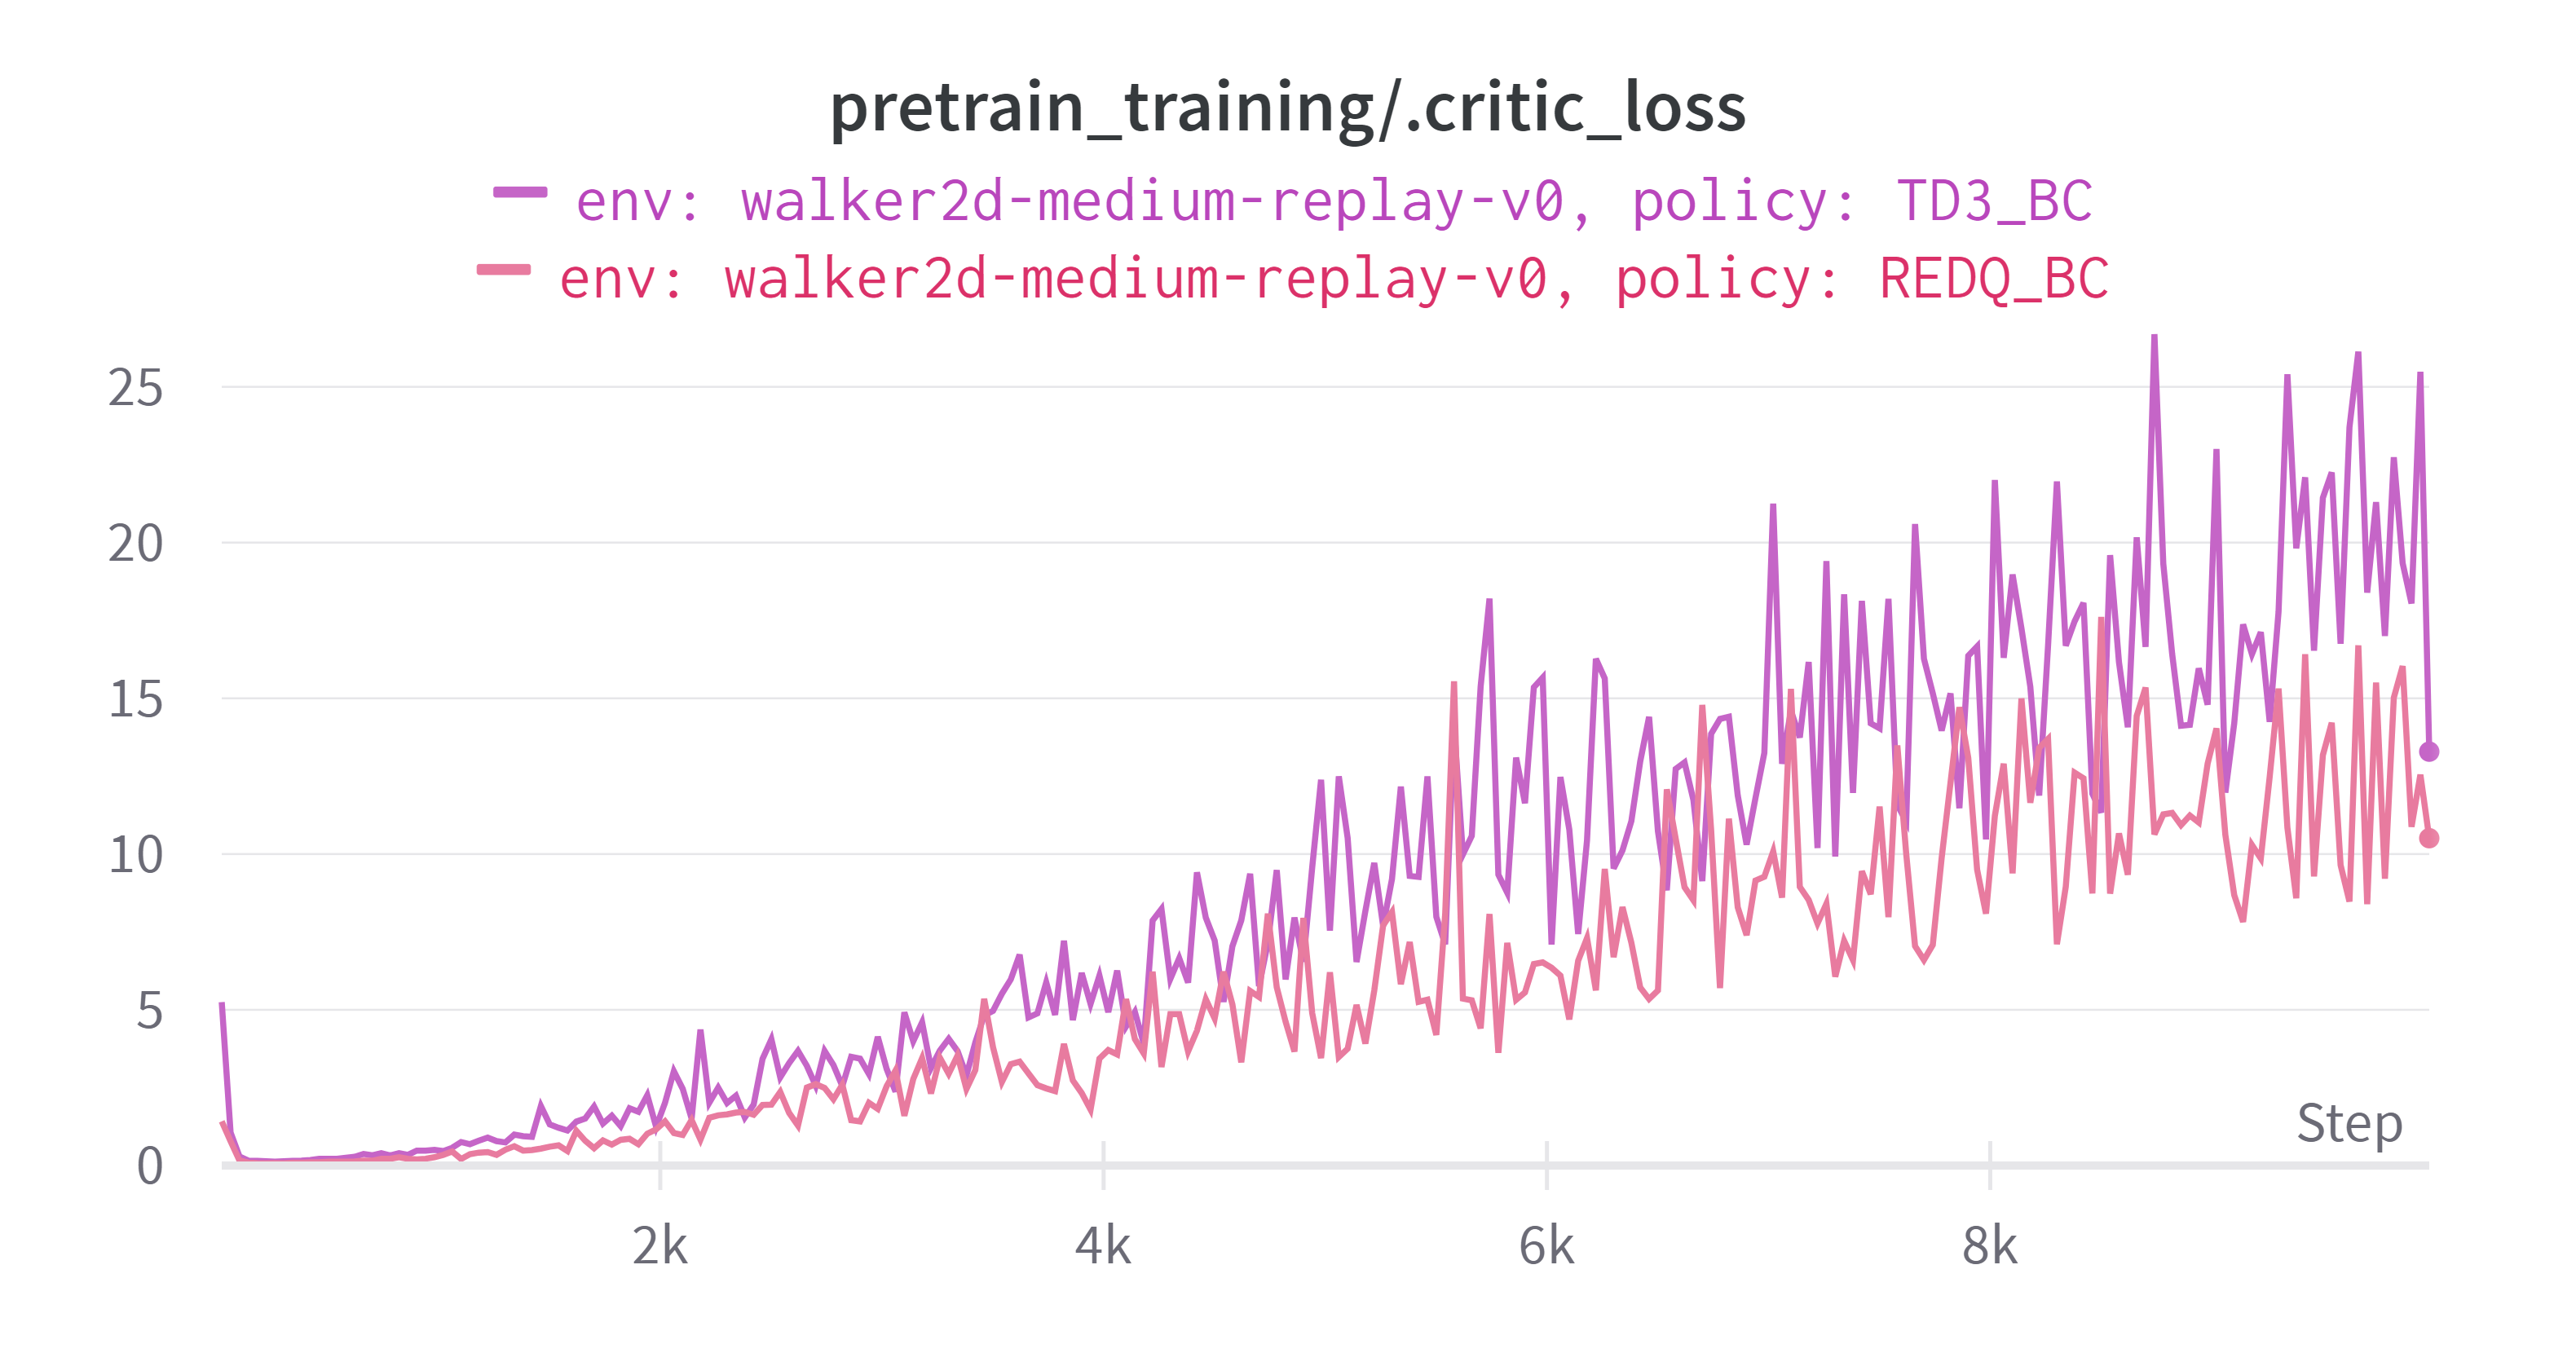

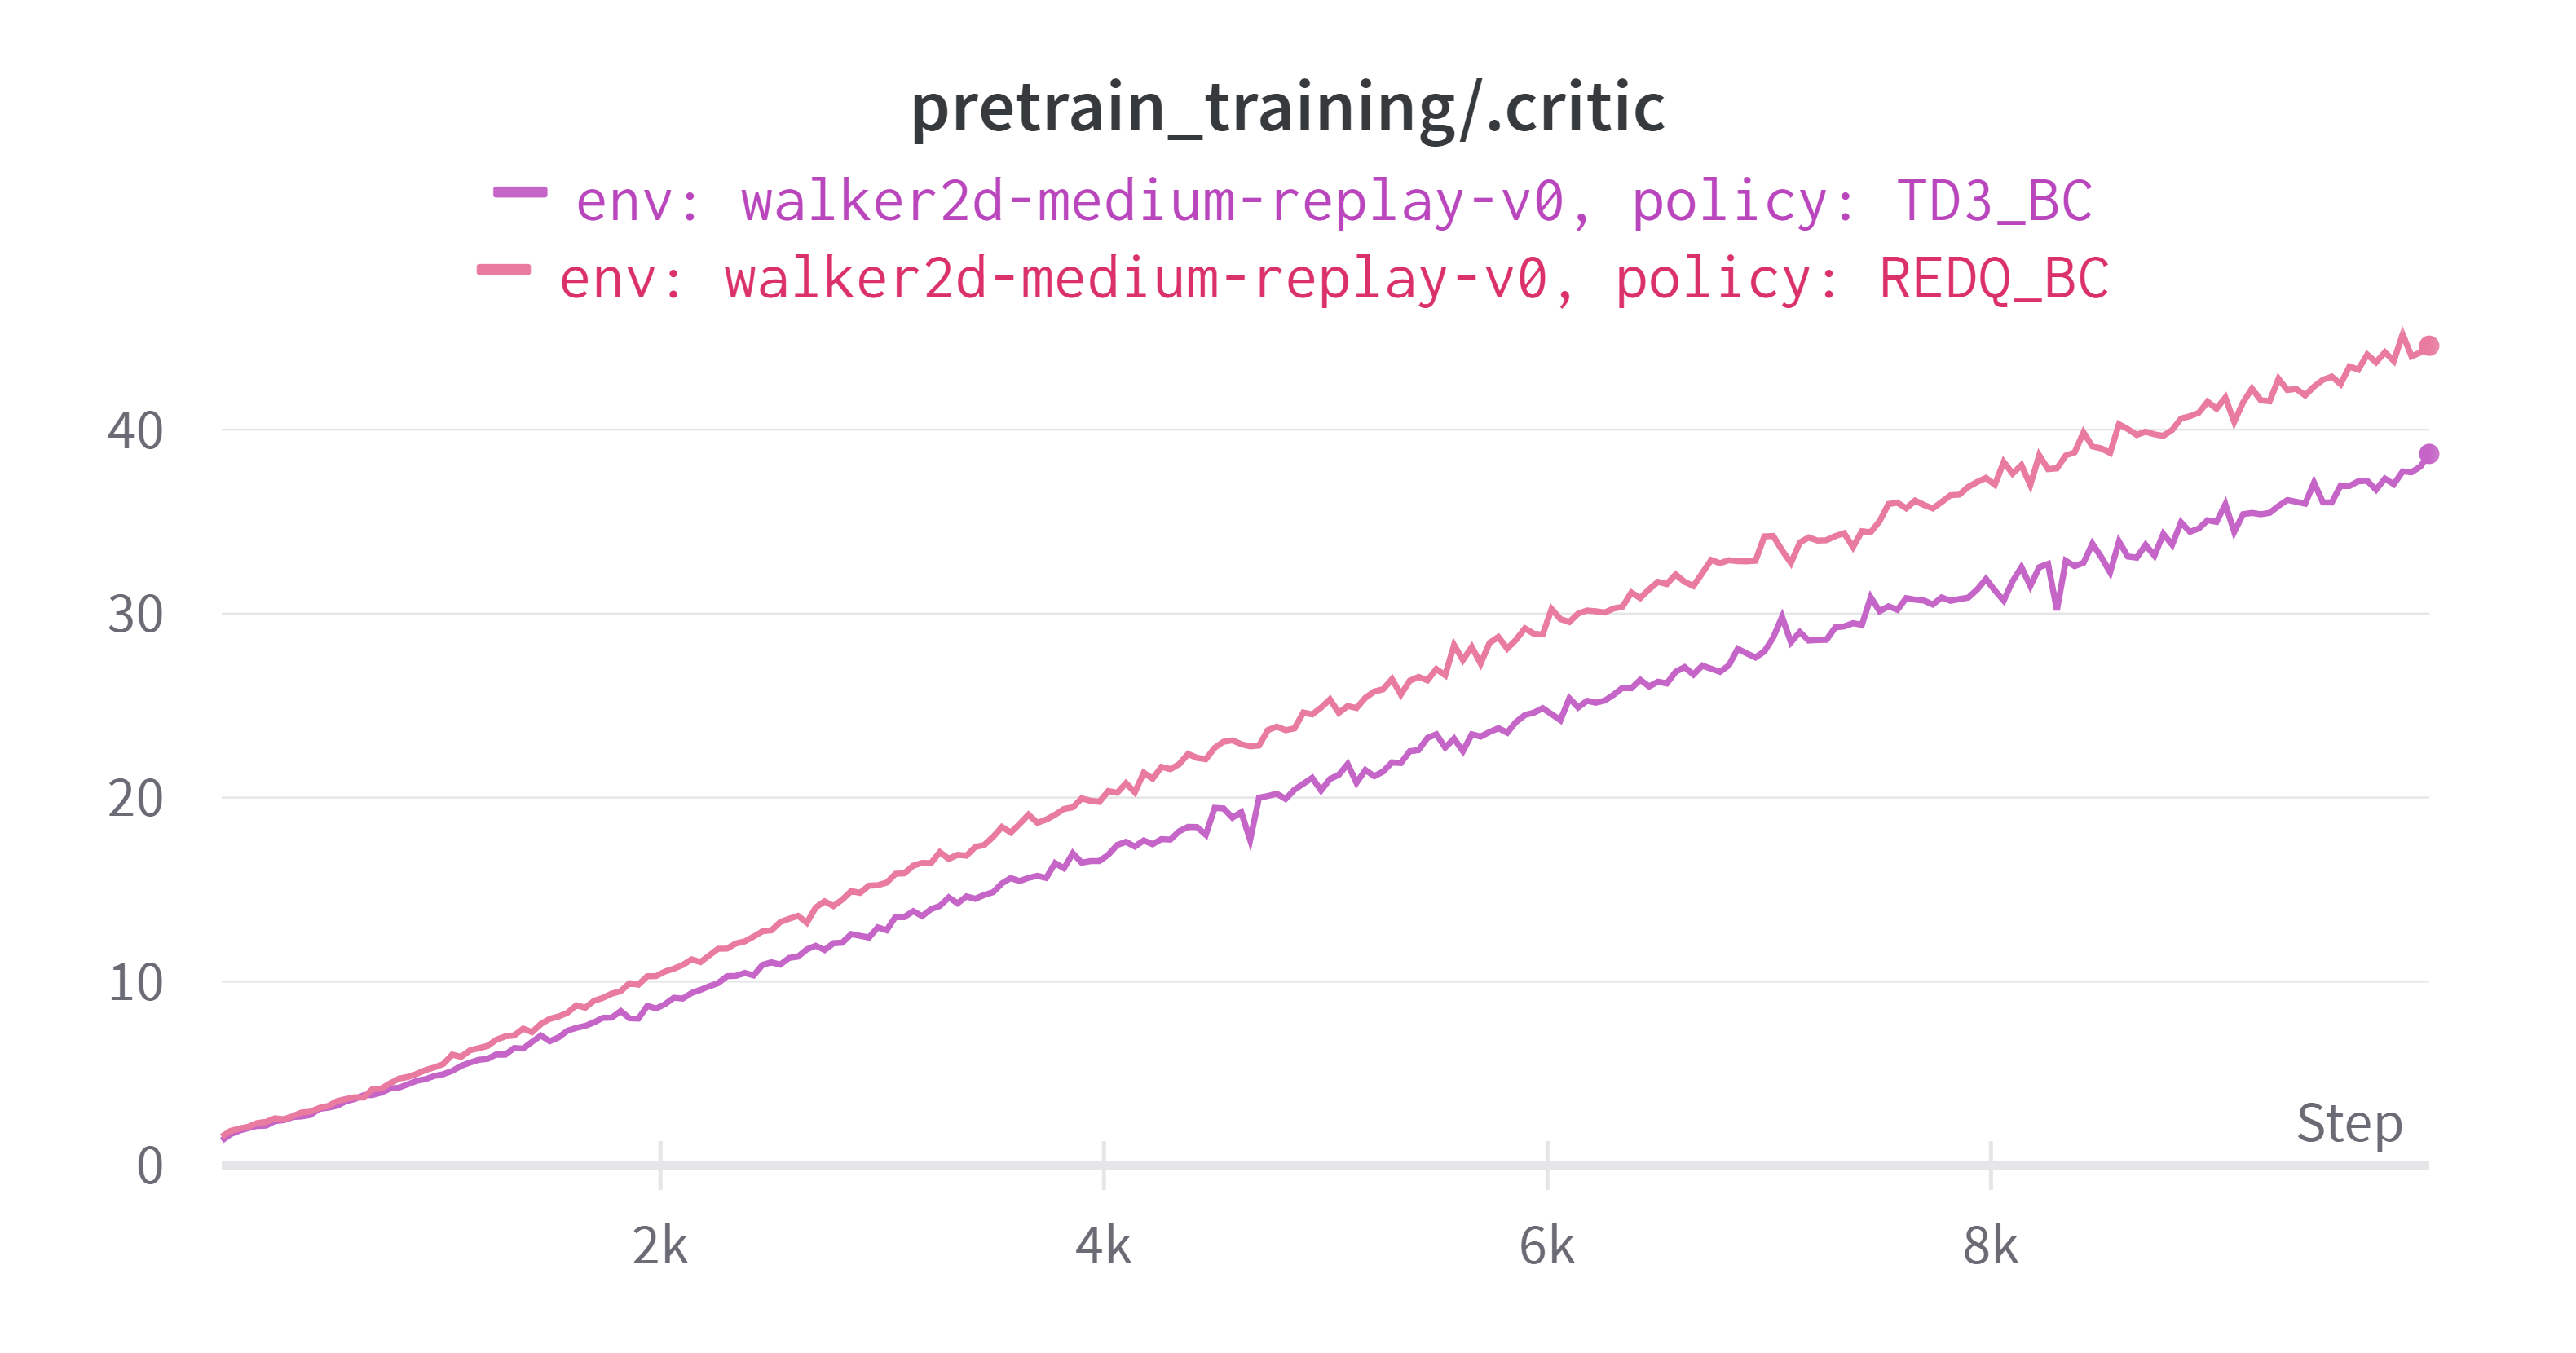

Результаты очень схожи с полученными для датасета hopper-medium-replaу. Разве что превосходство REDQ-BC в critic стало еще лучше видно.

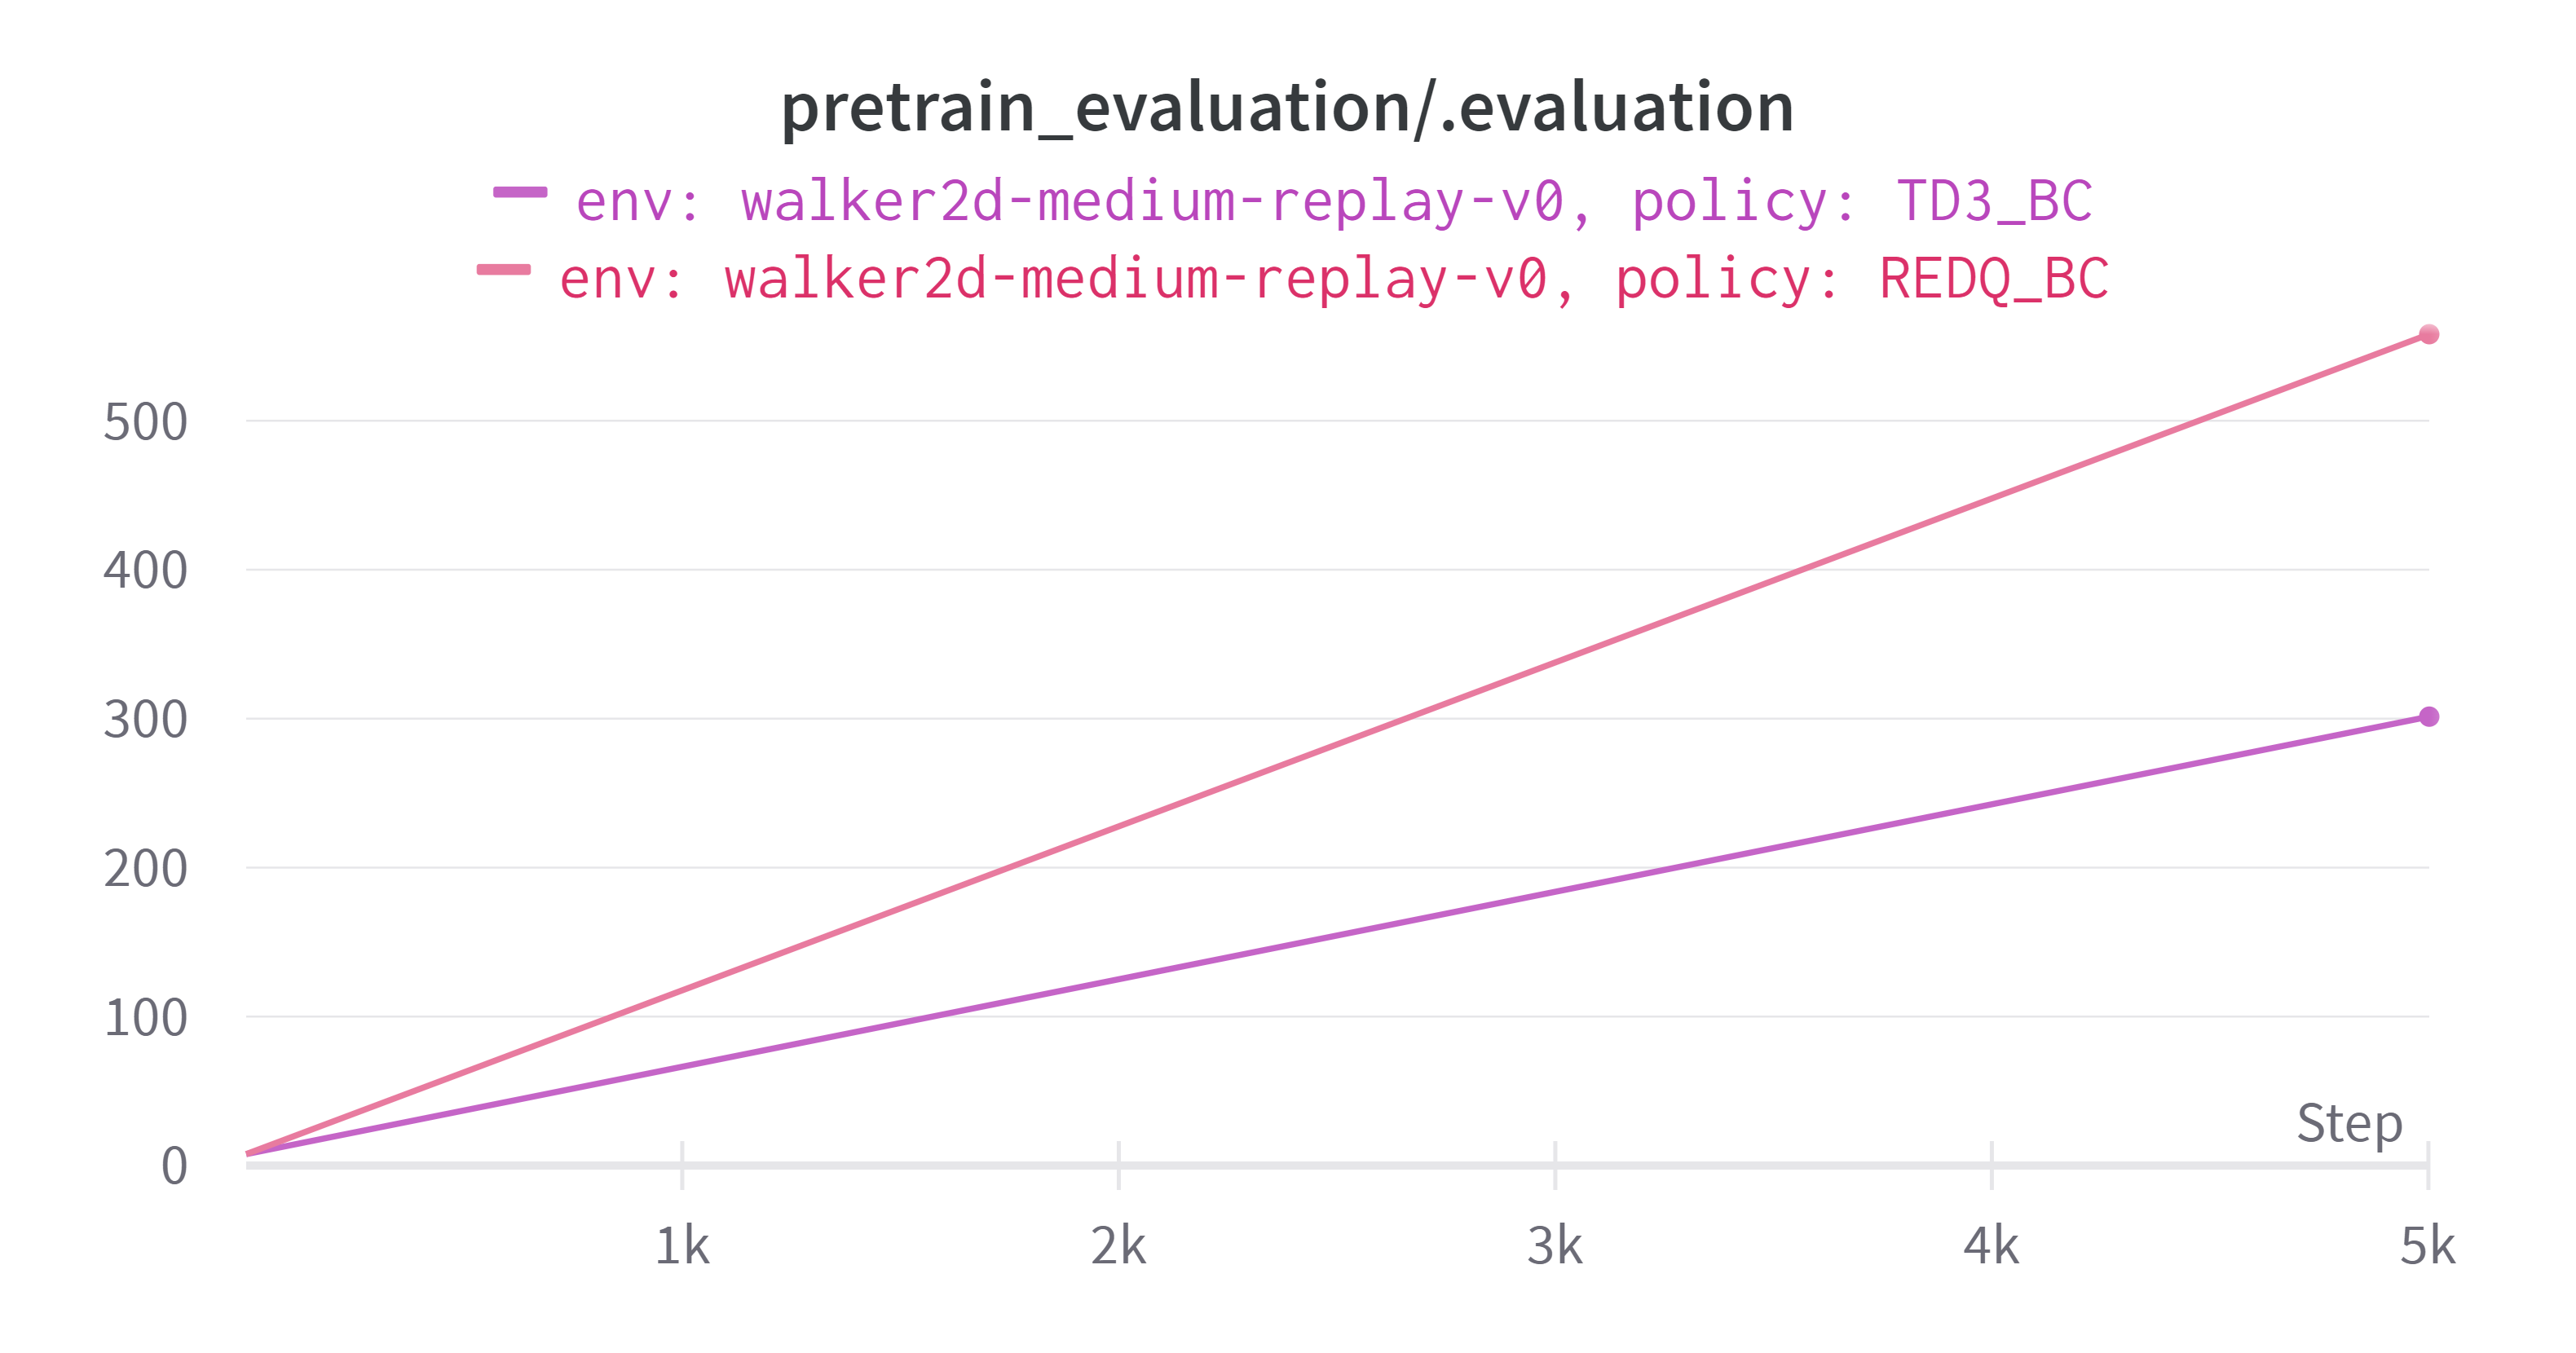

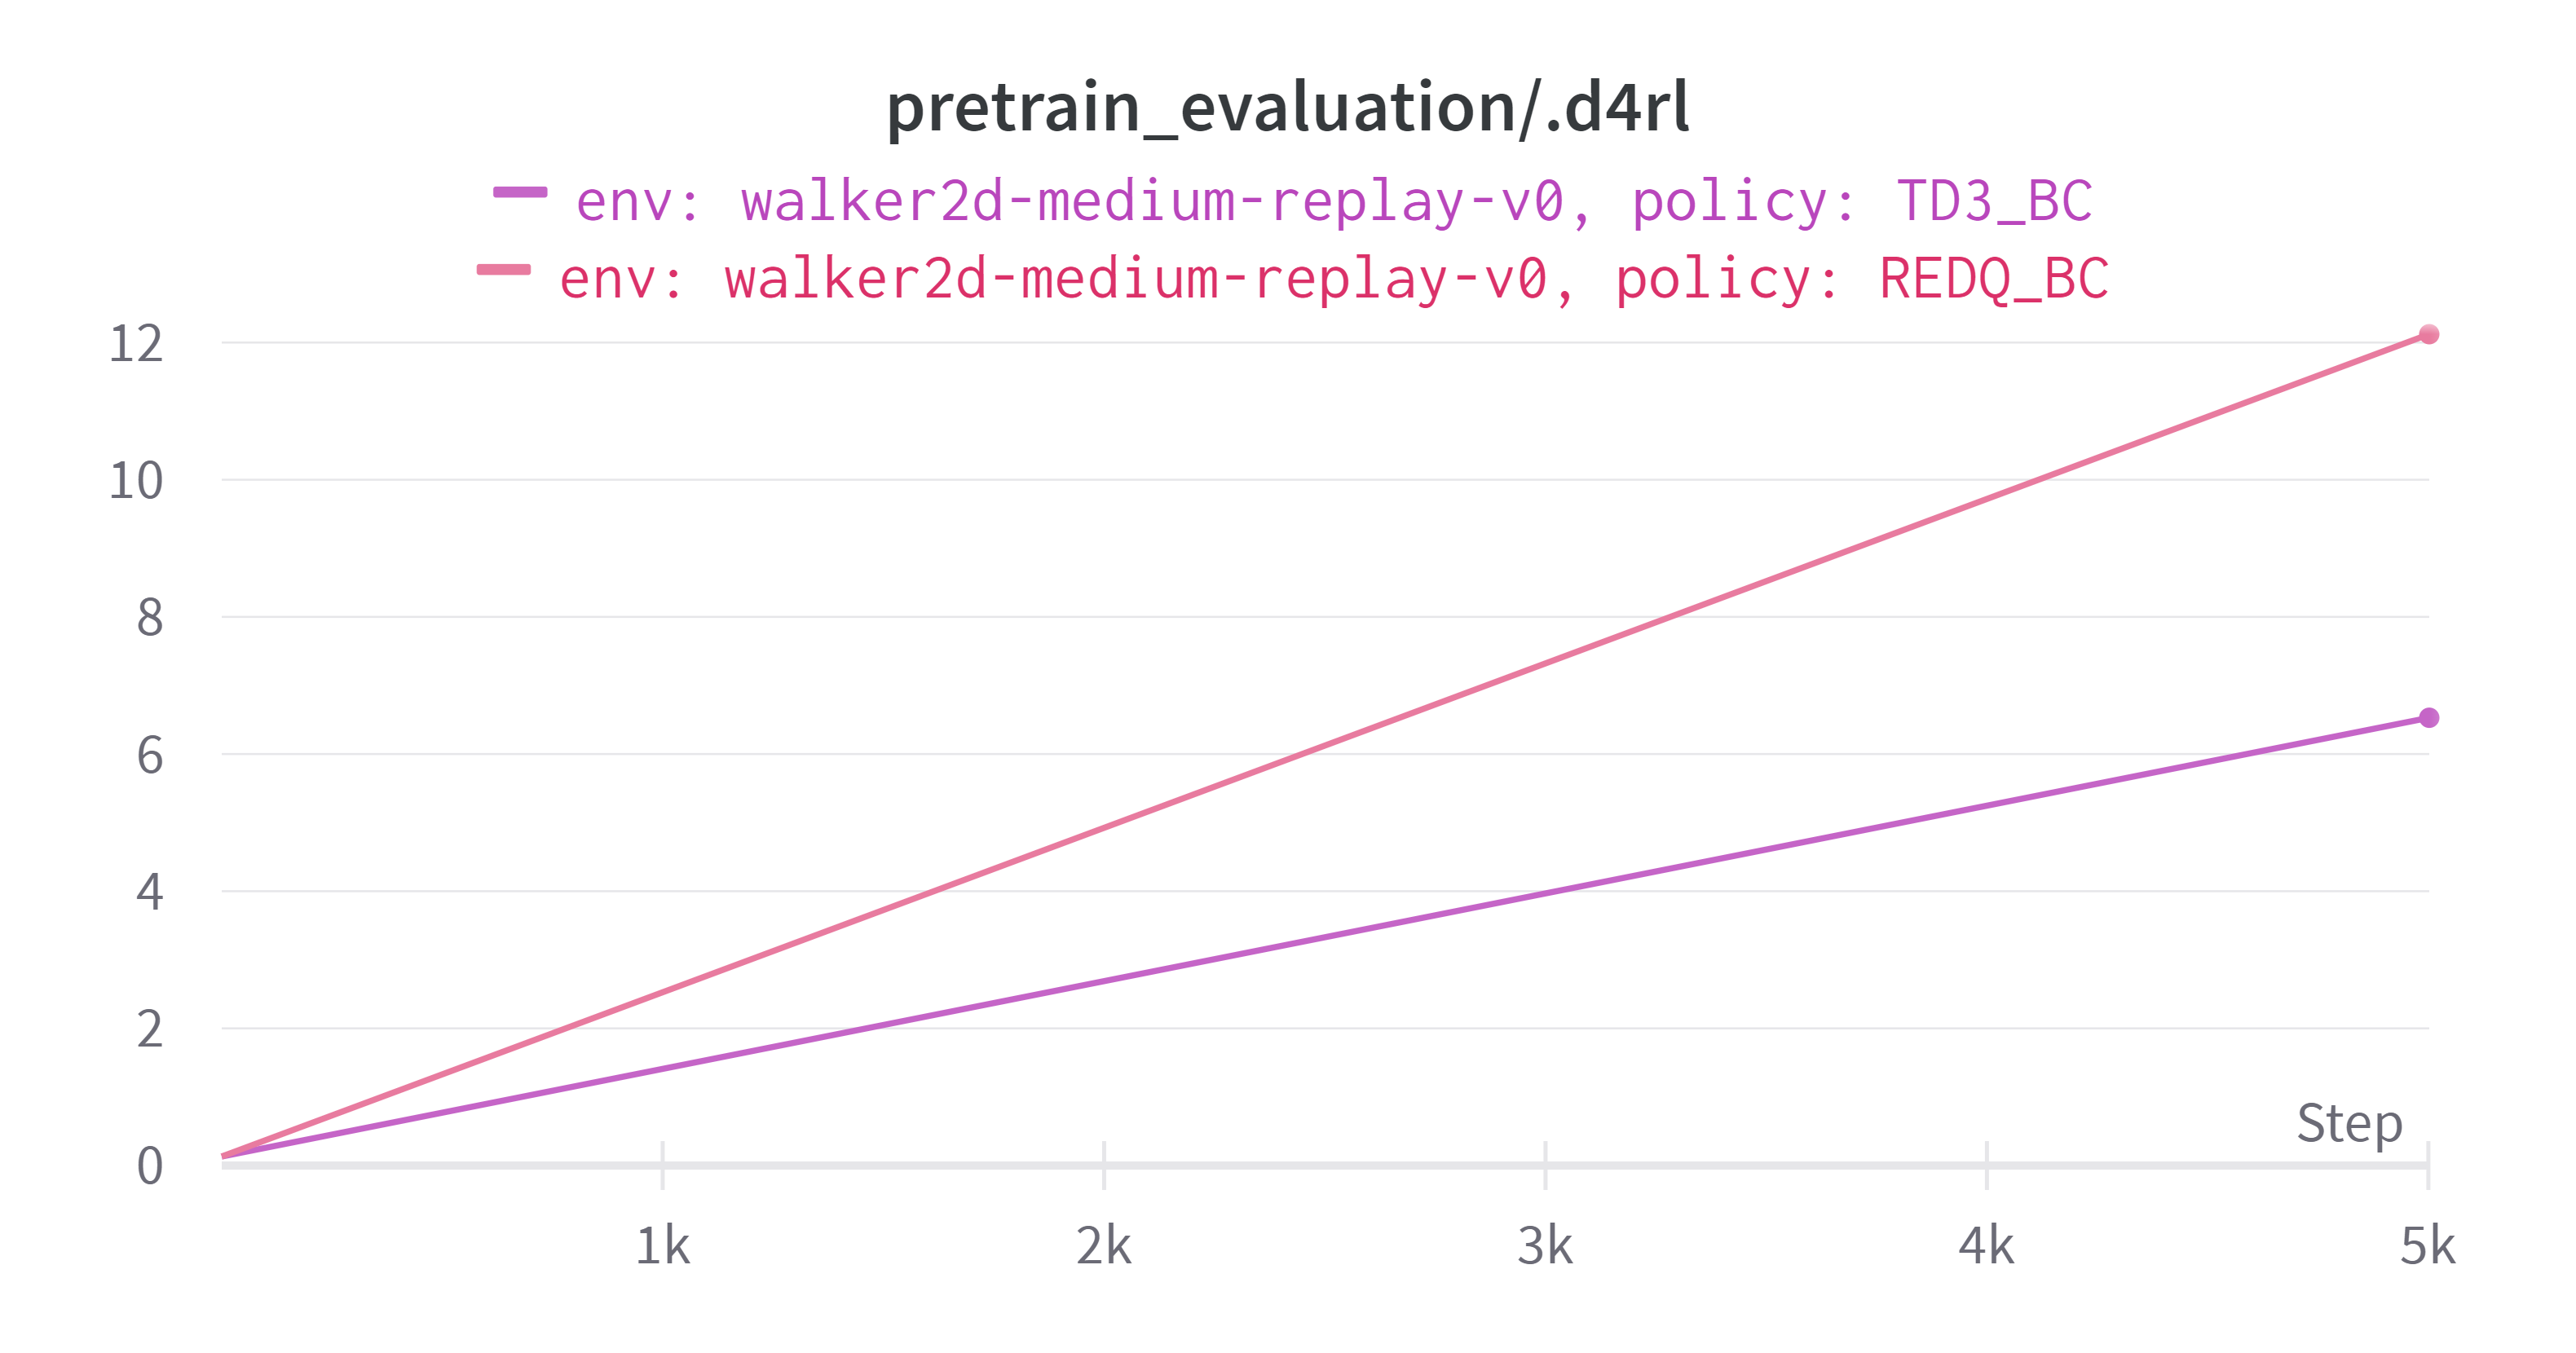

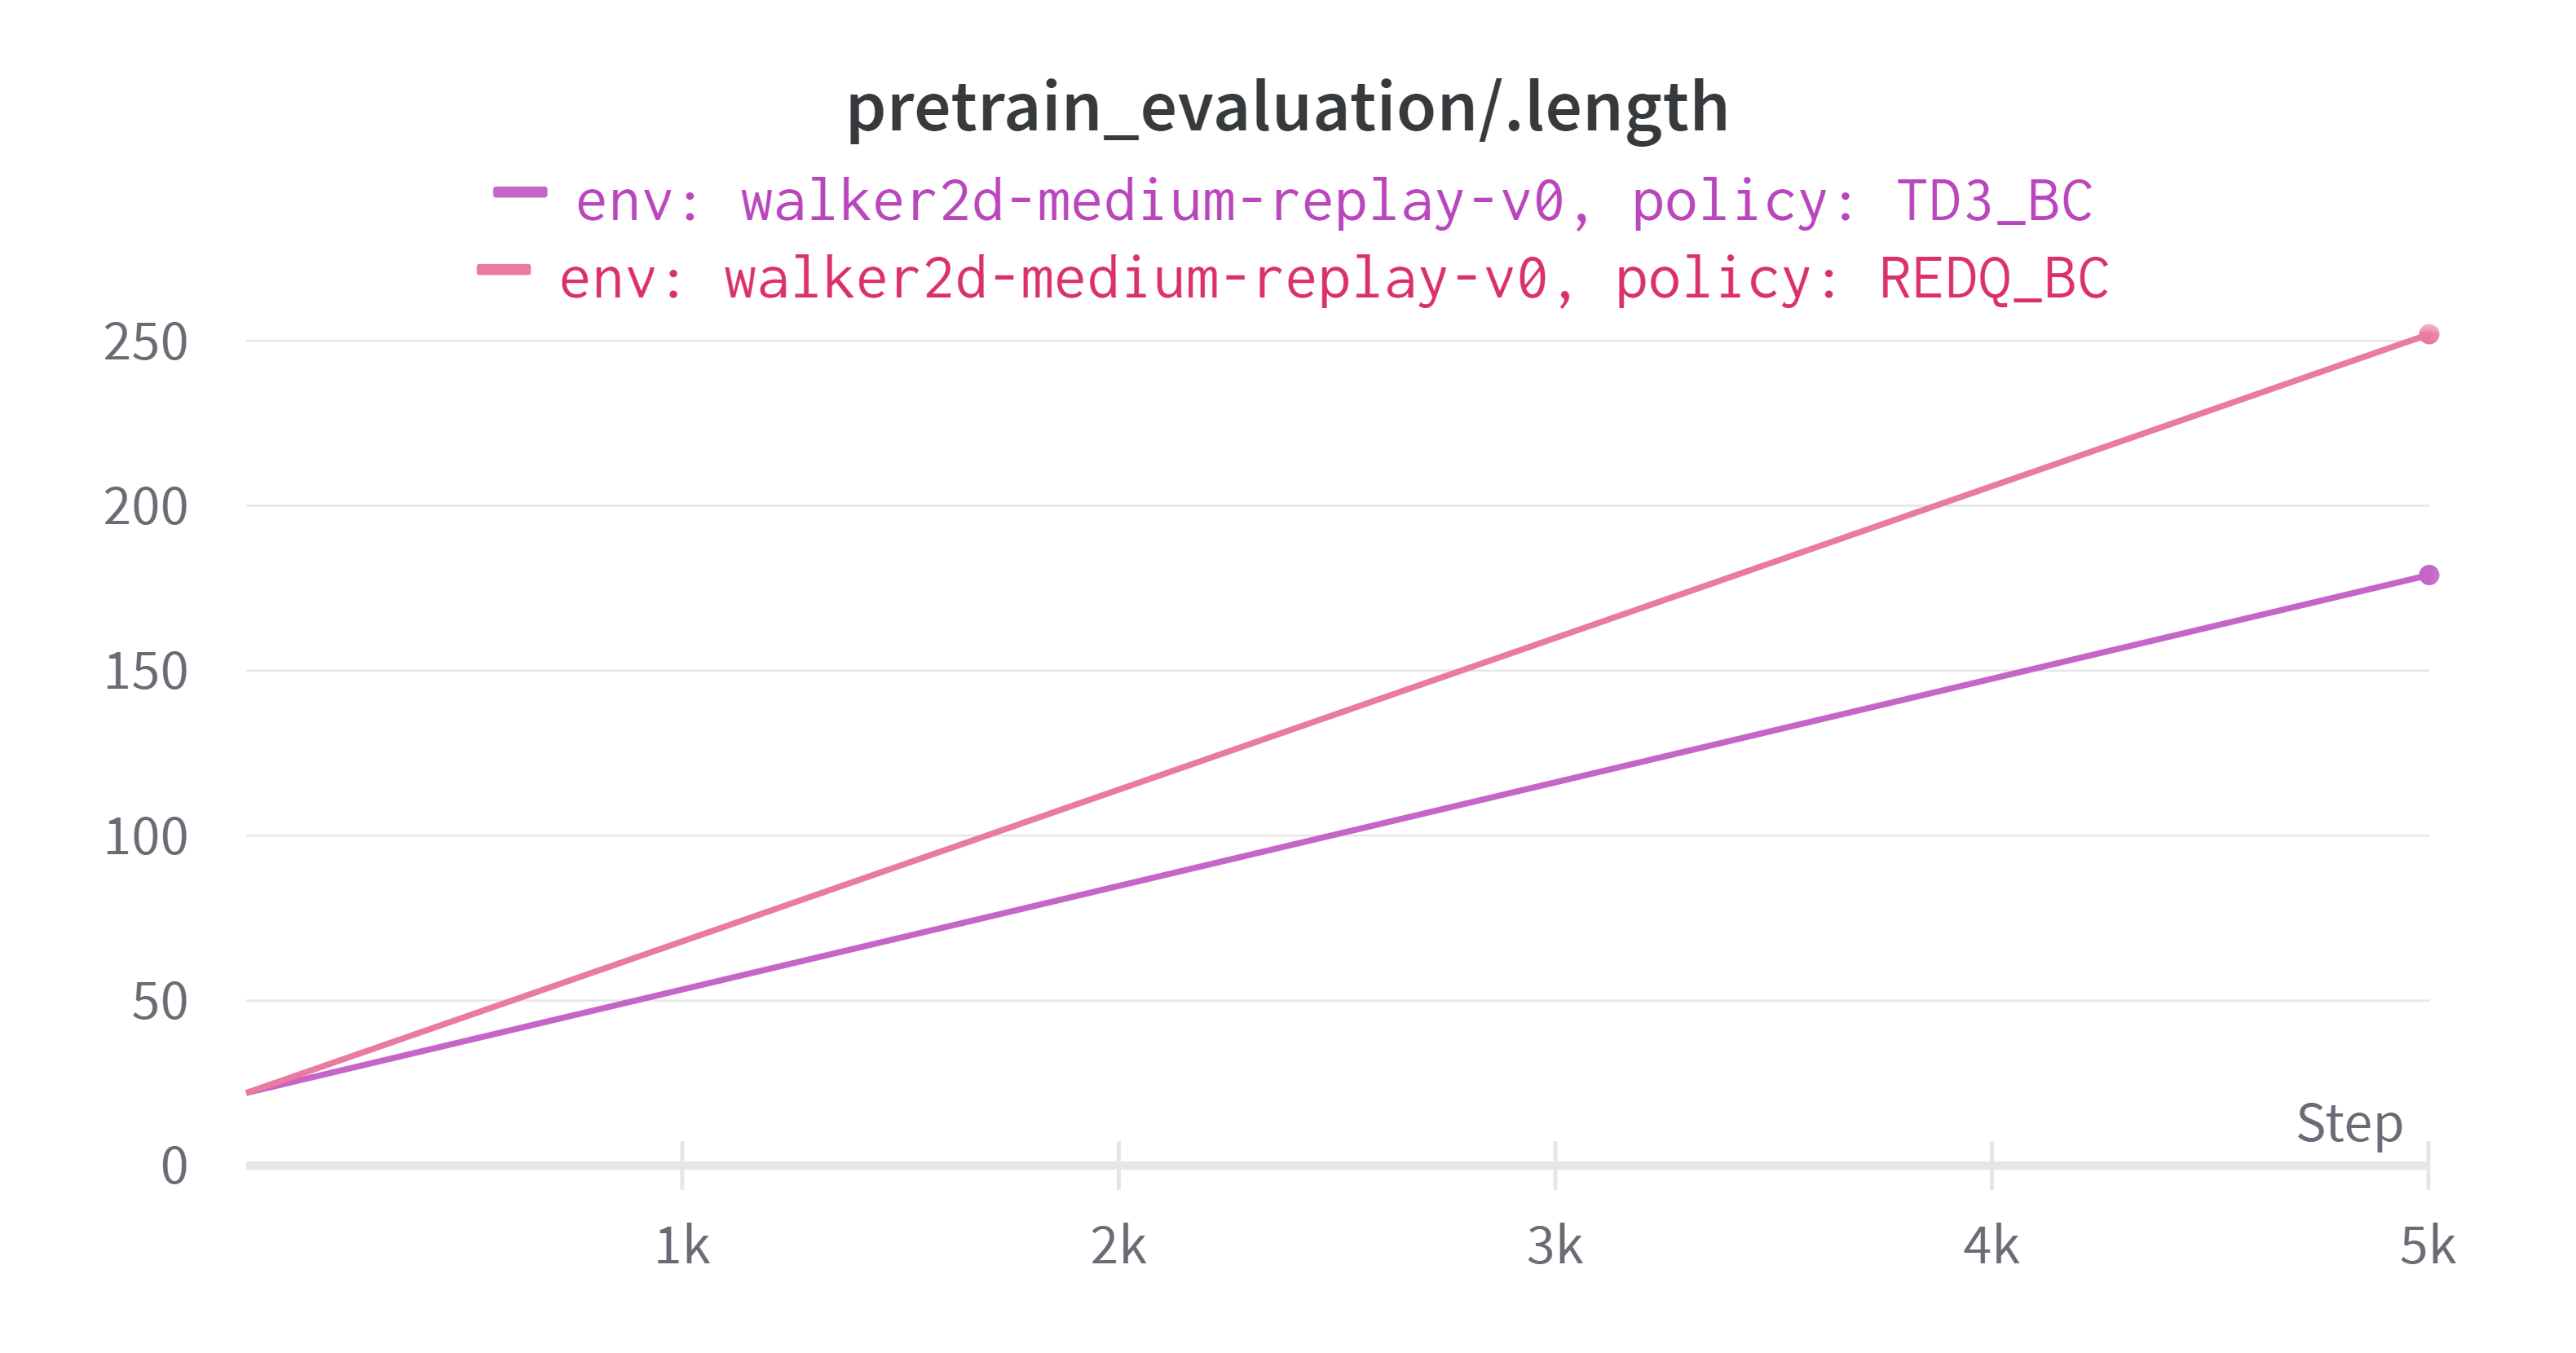

Также явно видим, что качество обучения TD3-BС хуже

Теперь рассмотрим онлайн

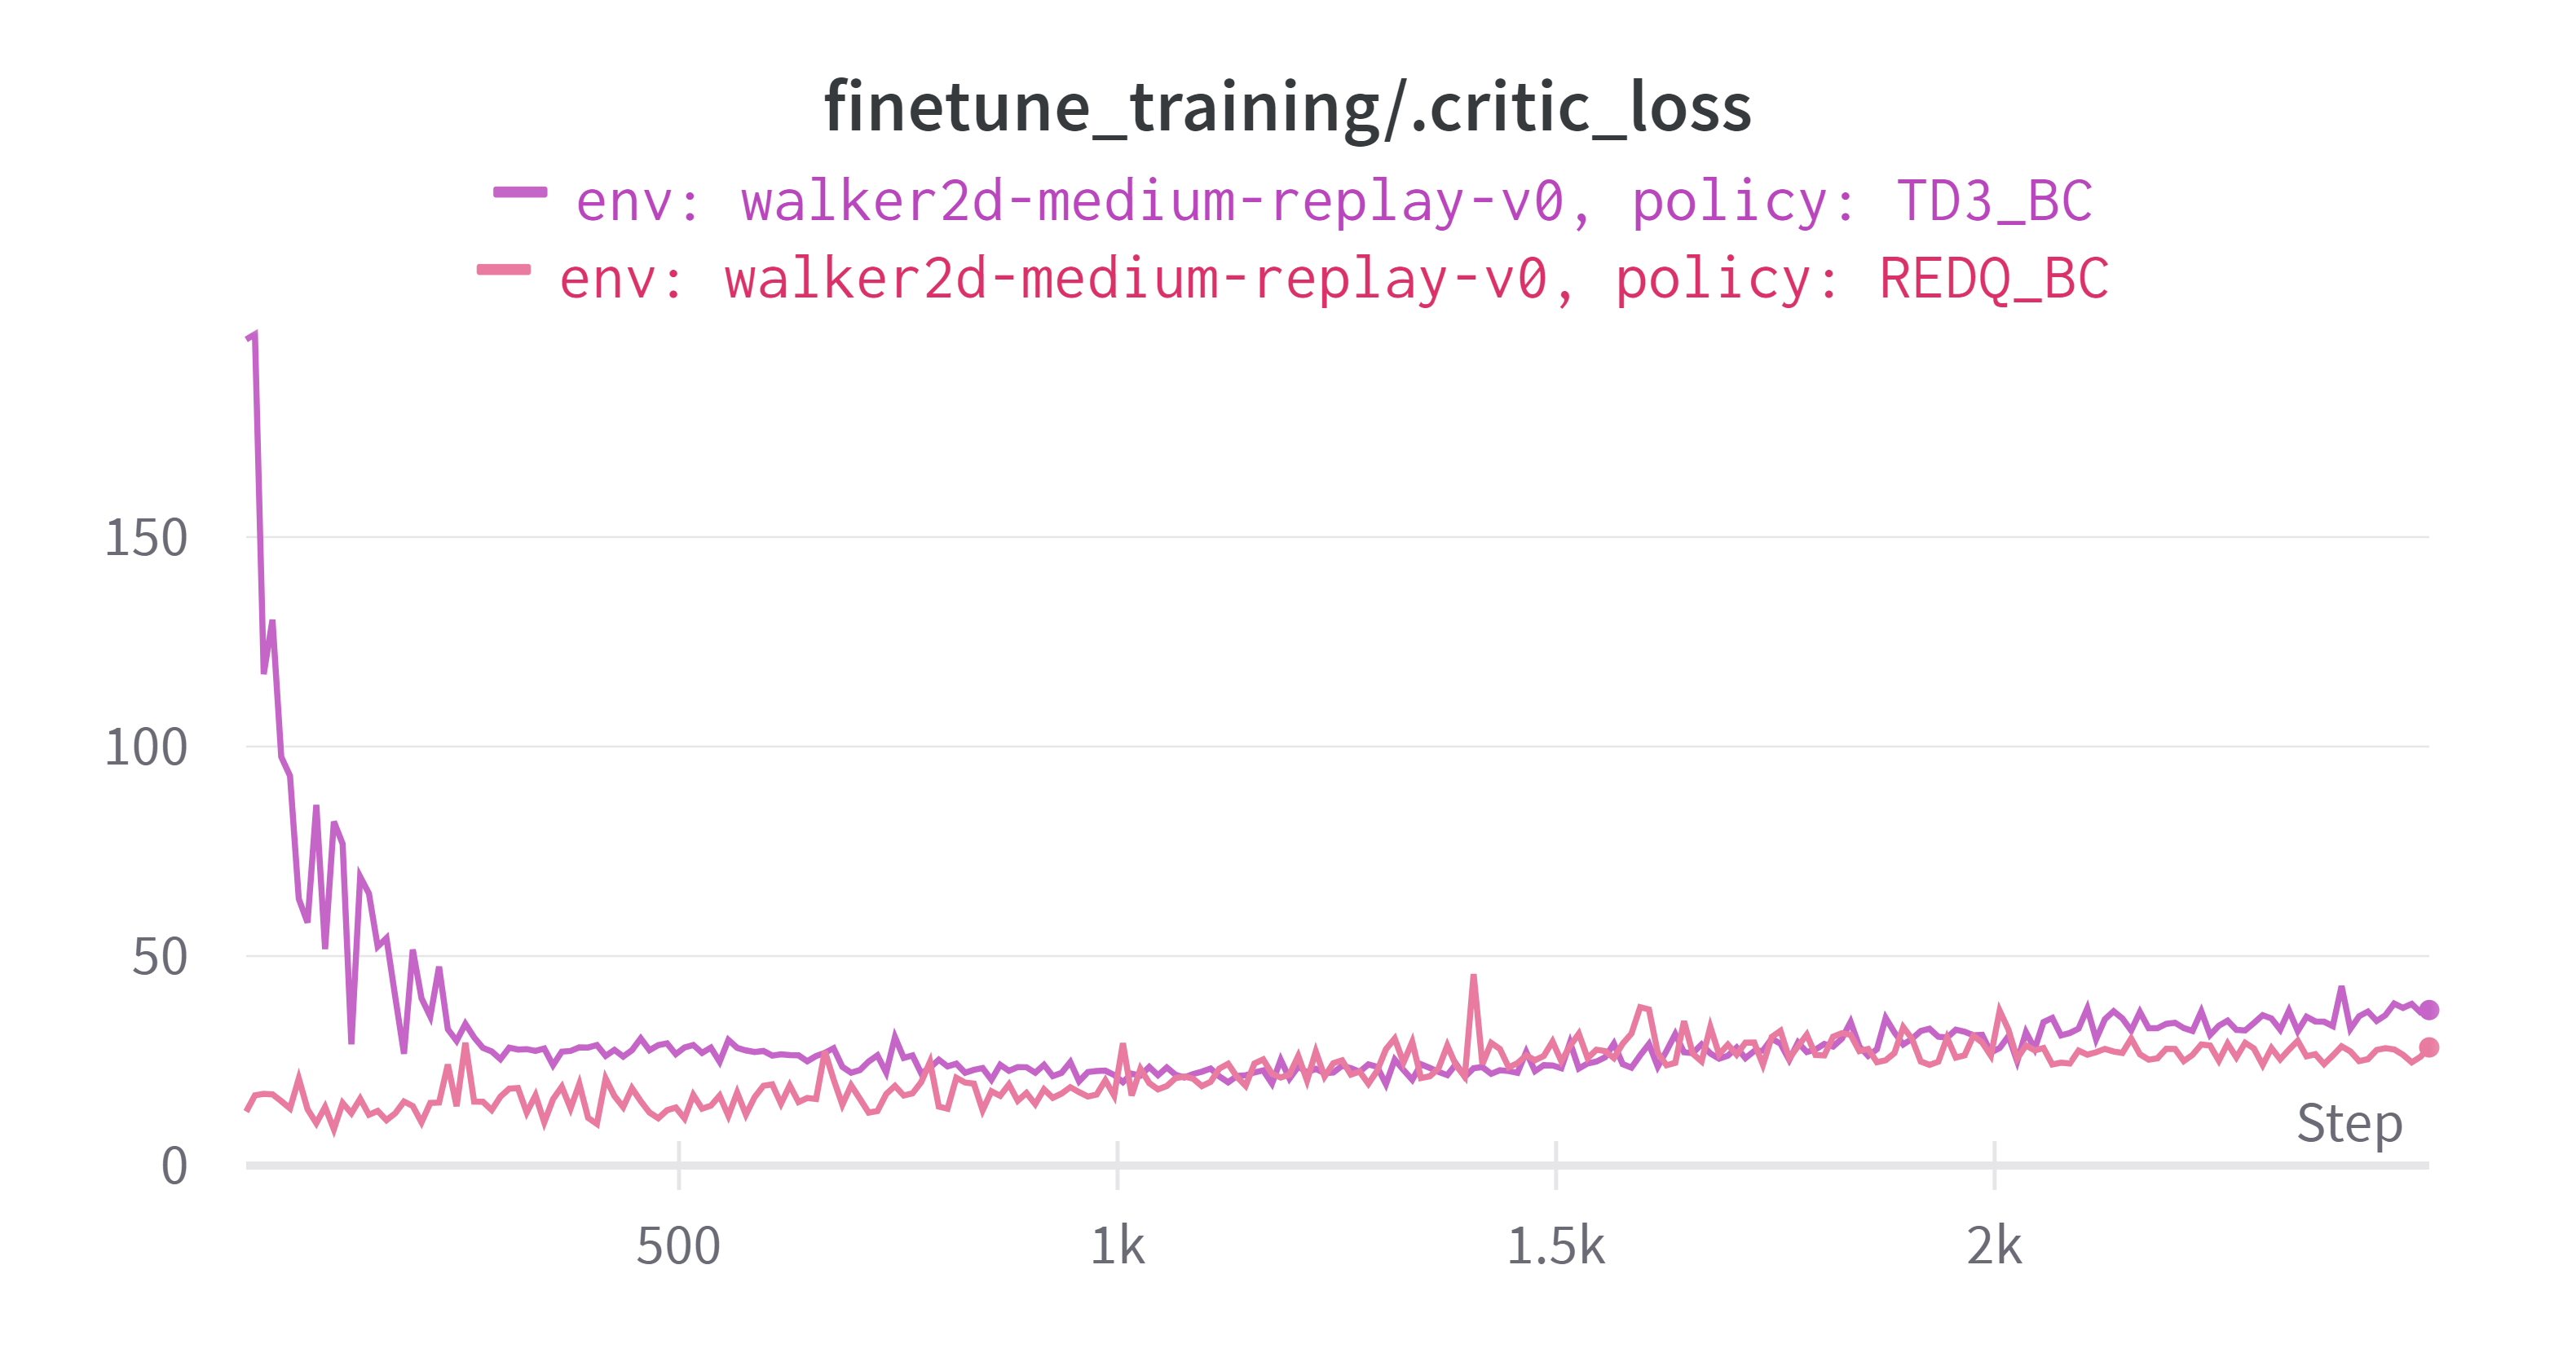

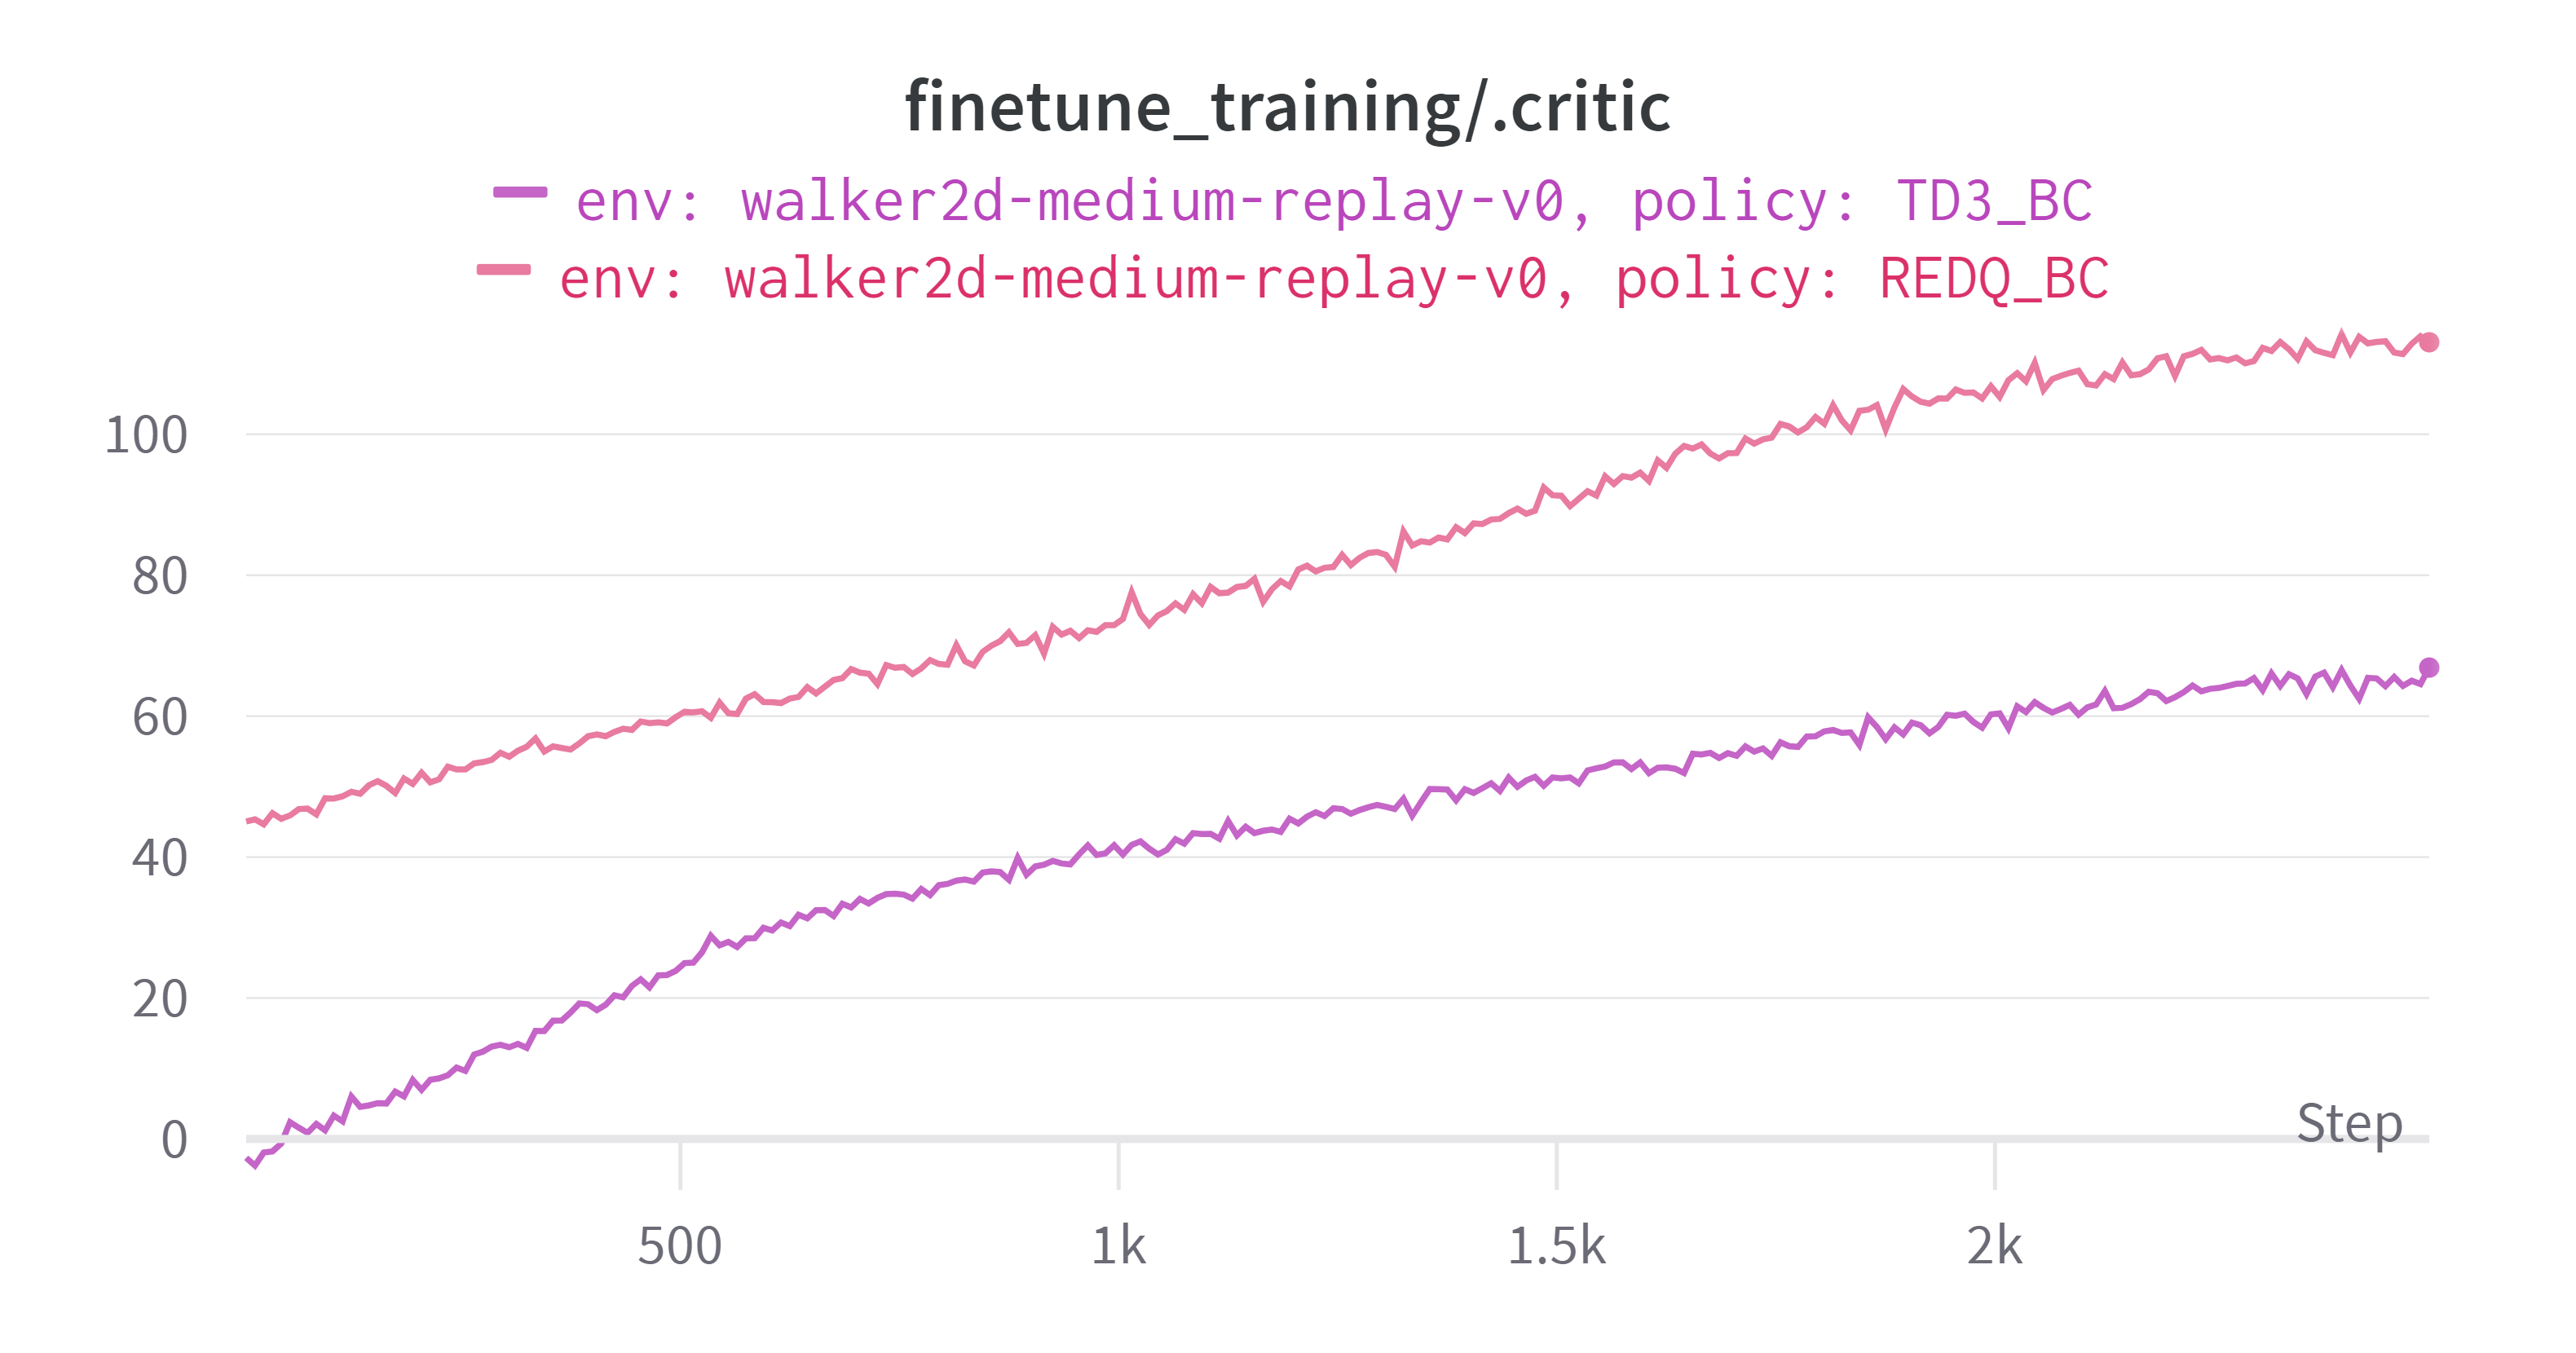

Уже ожидаемо получаем, что метод Adaptive Behavior Cloning Regularization обучился намного лучше. Опять-таки стоит отметить, что и при переходе от одного вида обучения у другому, он не испытывает больших трудностей в отличие от Twin Delayed DDPG и мы не наблюдаем сильного скачка в critic-loss

И наконец рассмотрим среднее вознаграждение и нормализованный оценочный балл (а также среднюю длину эпизода)

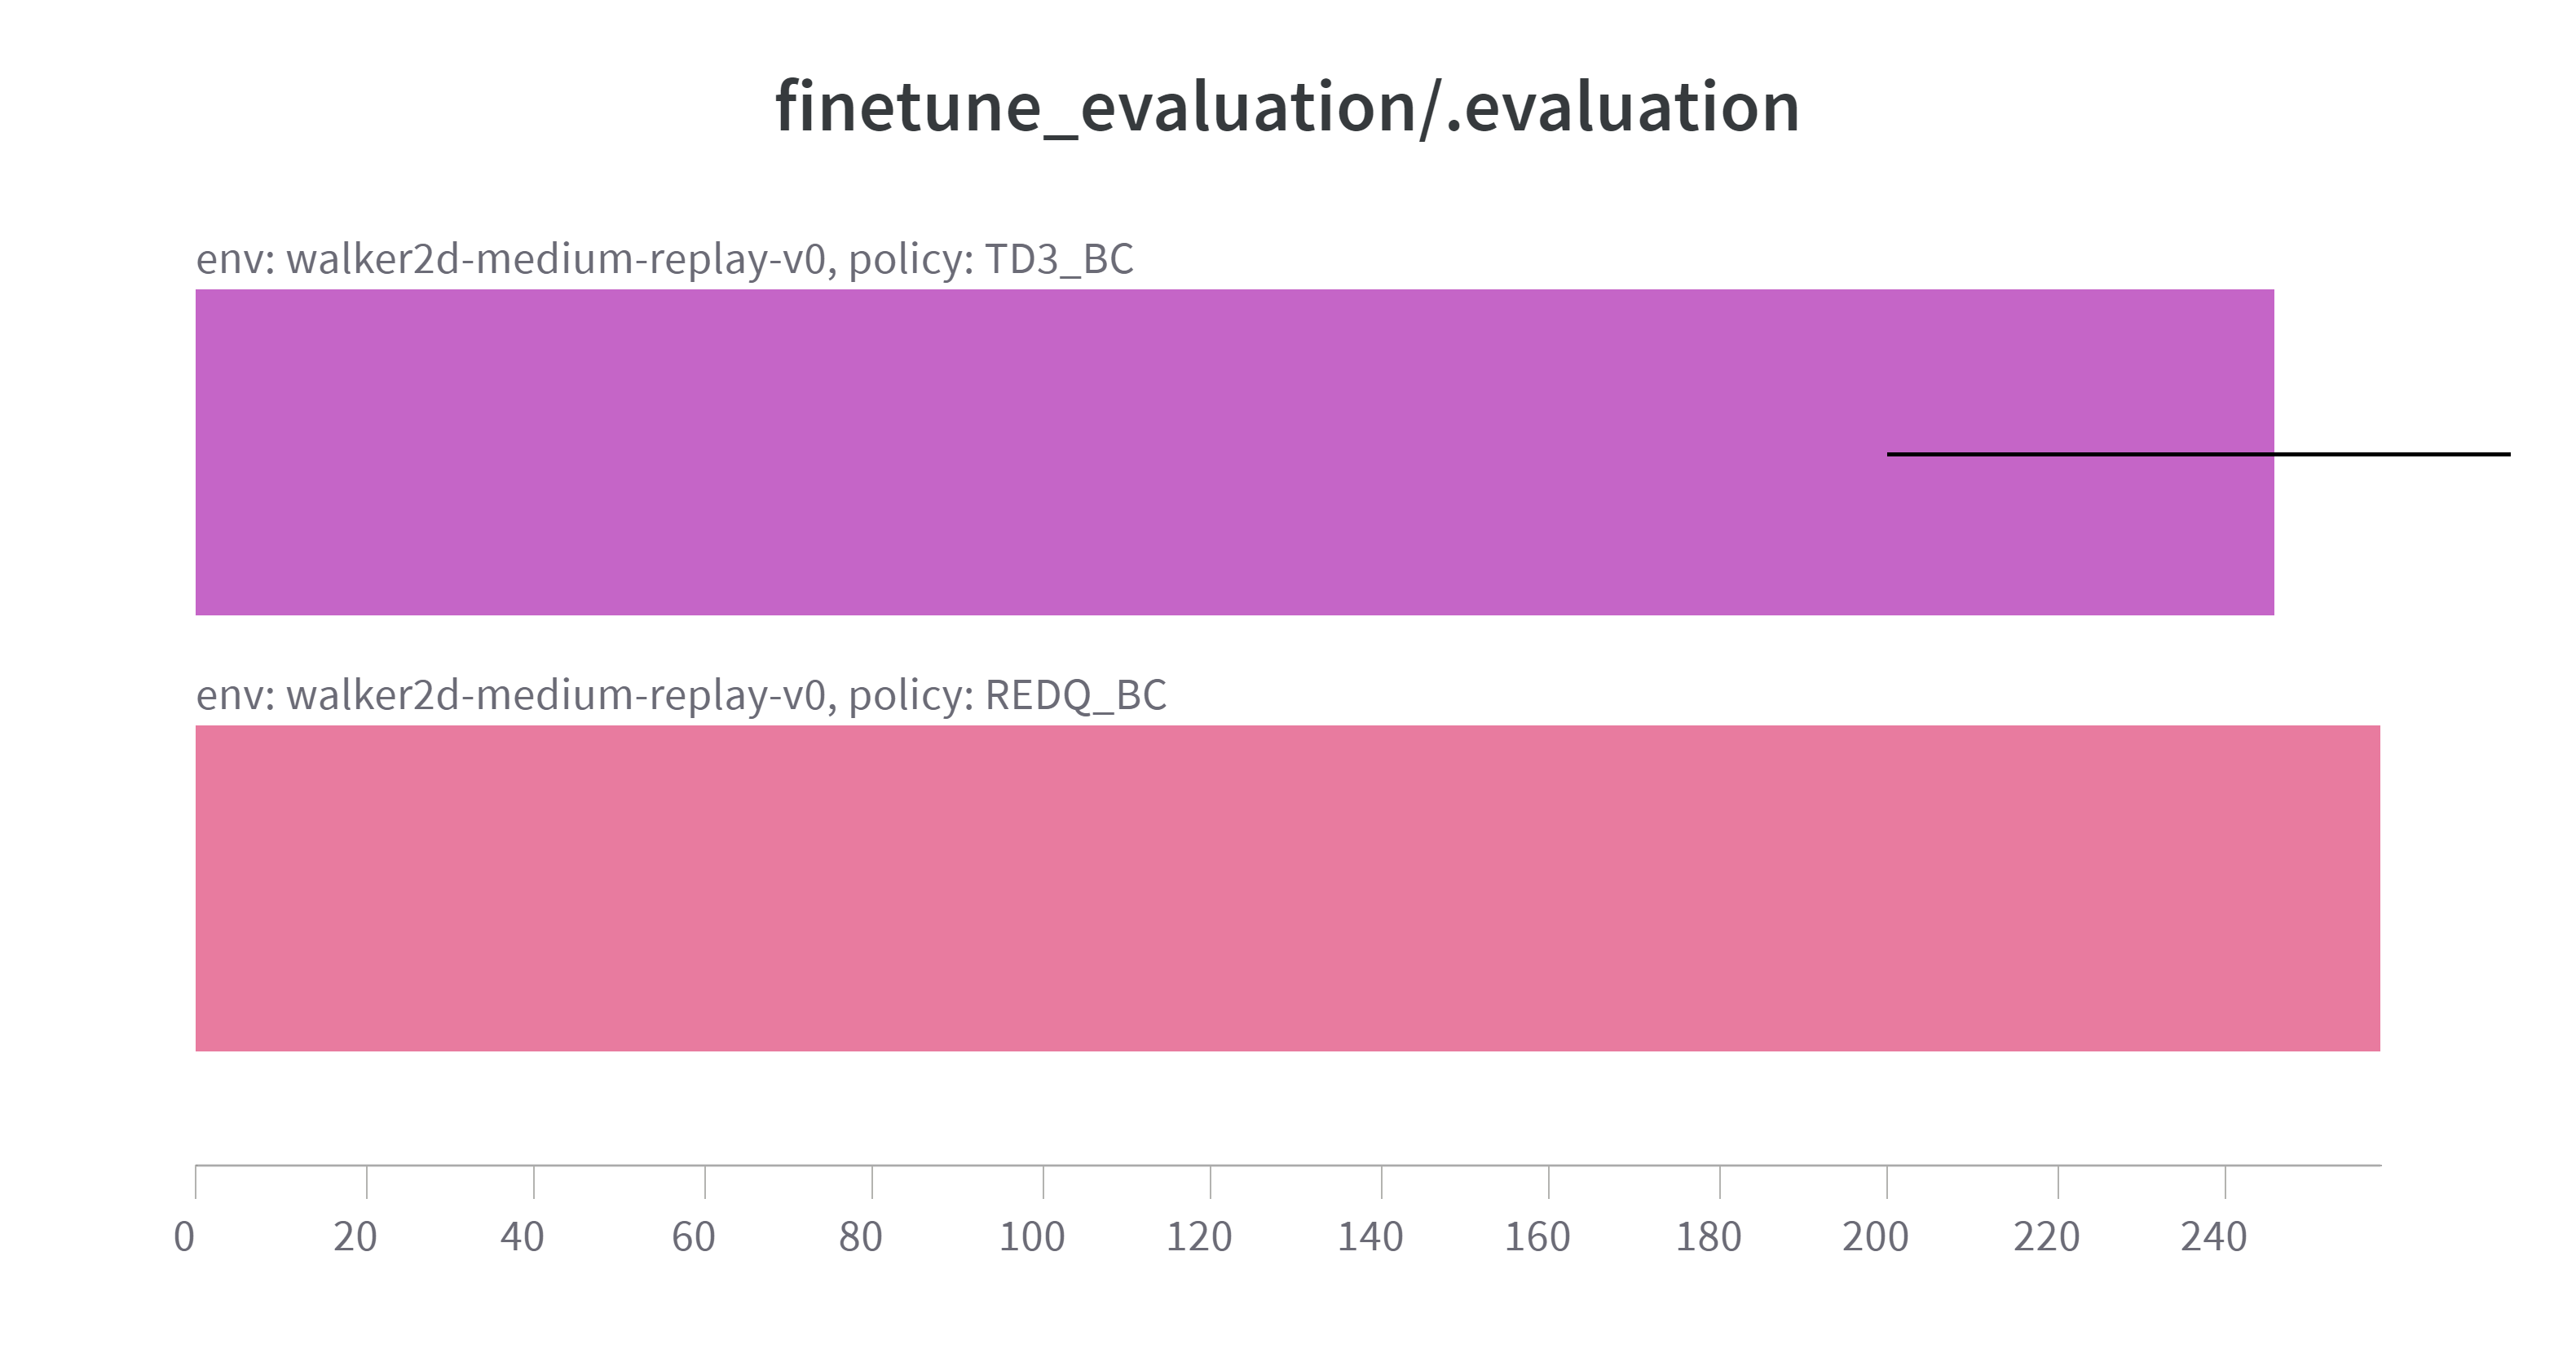

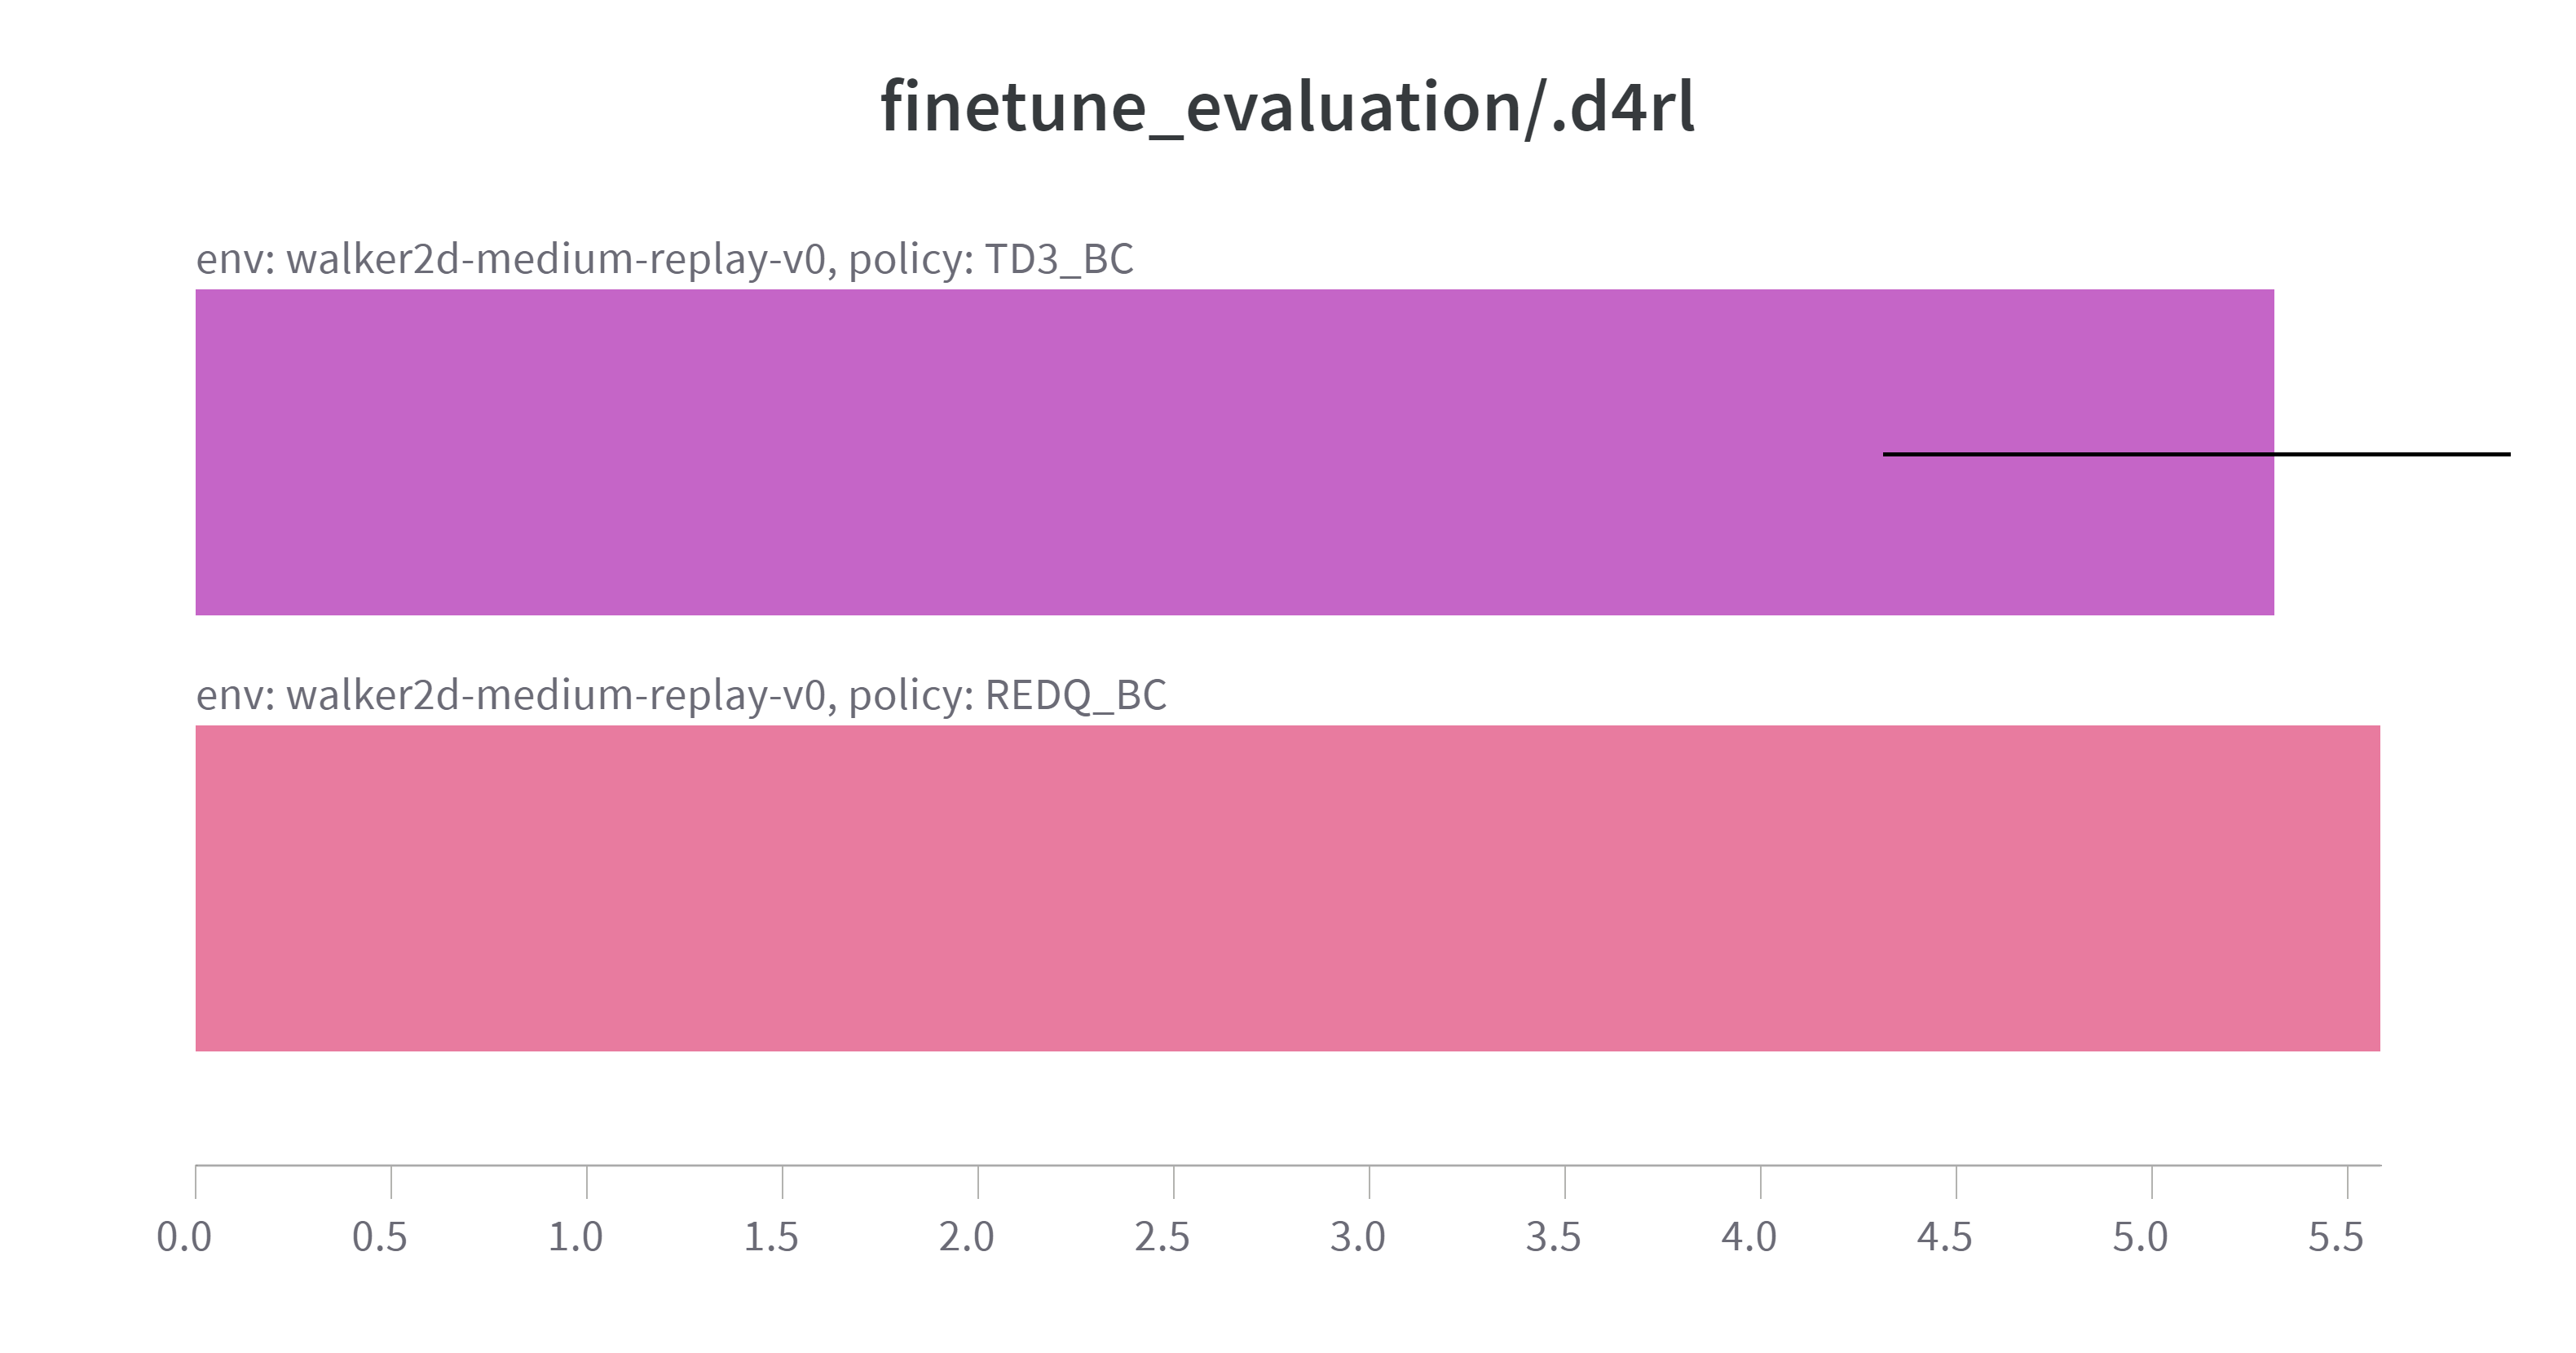

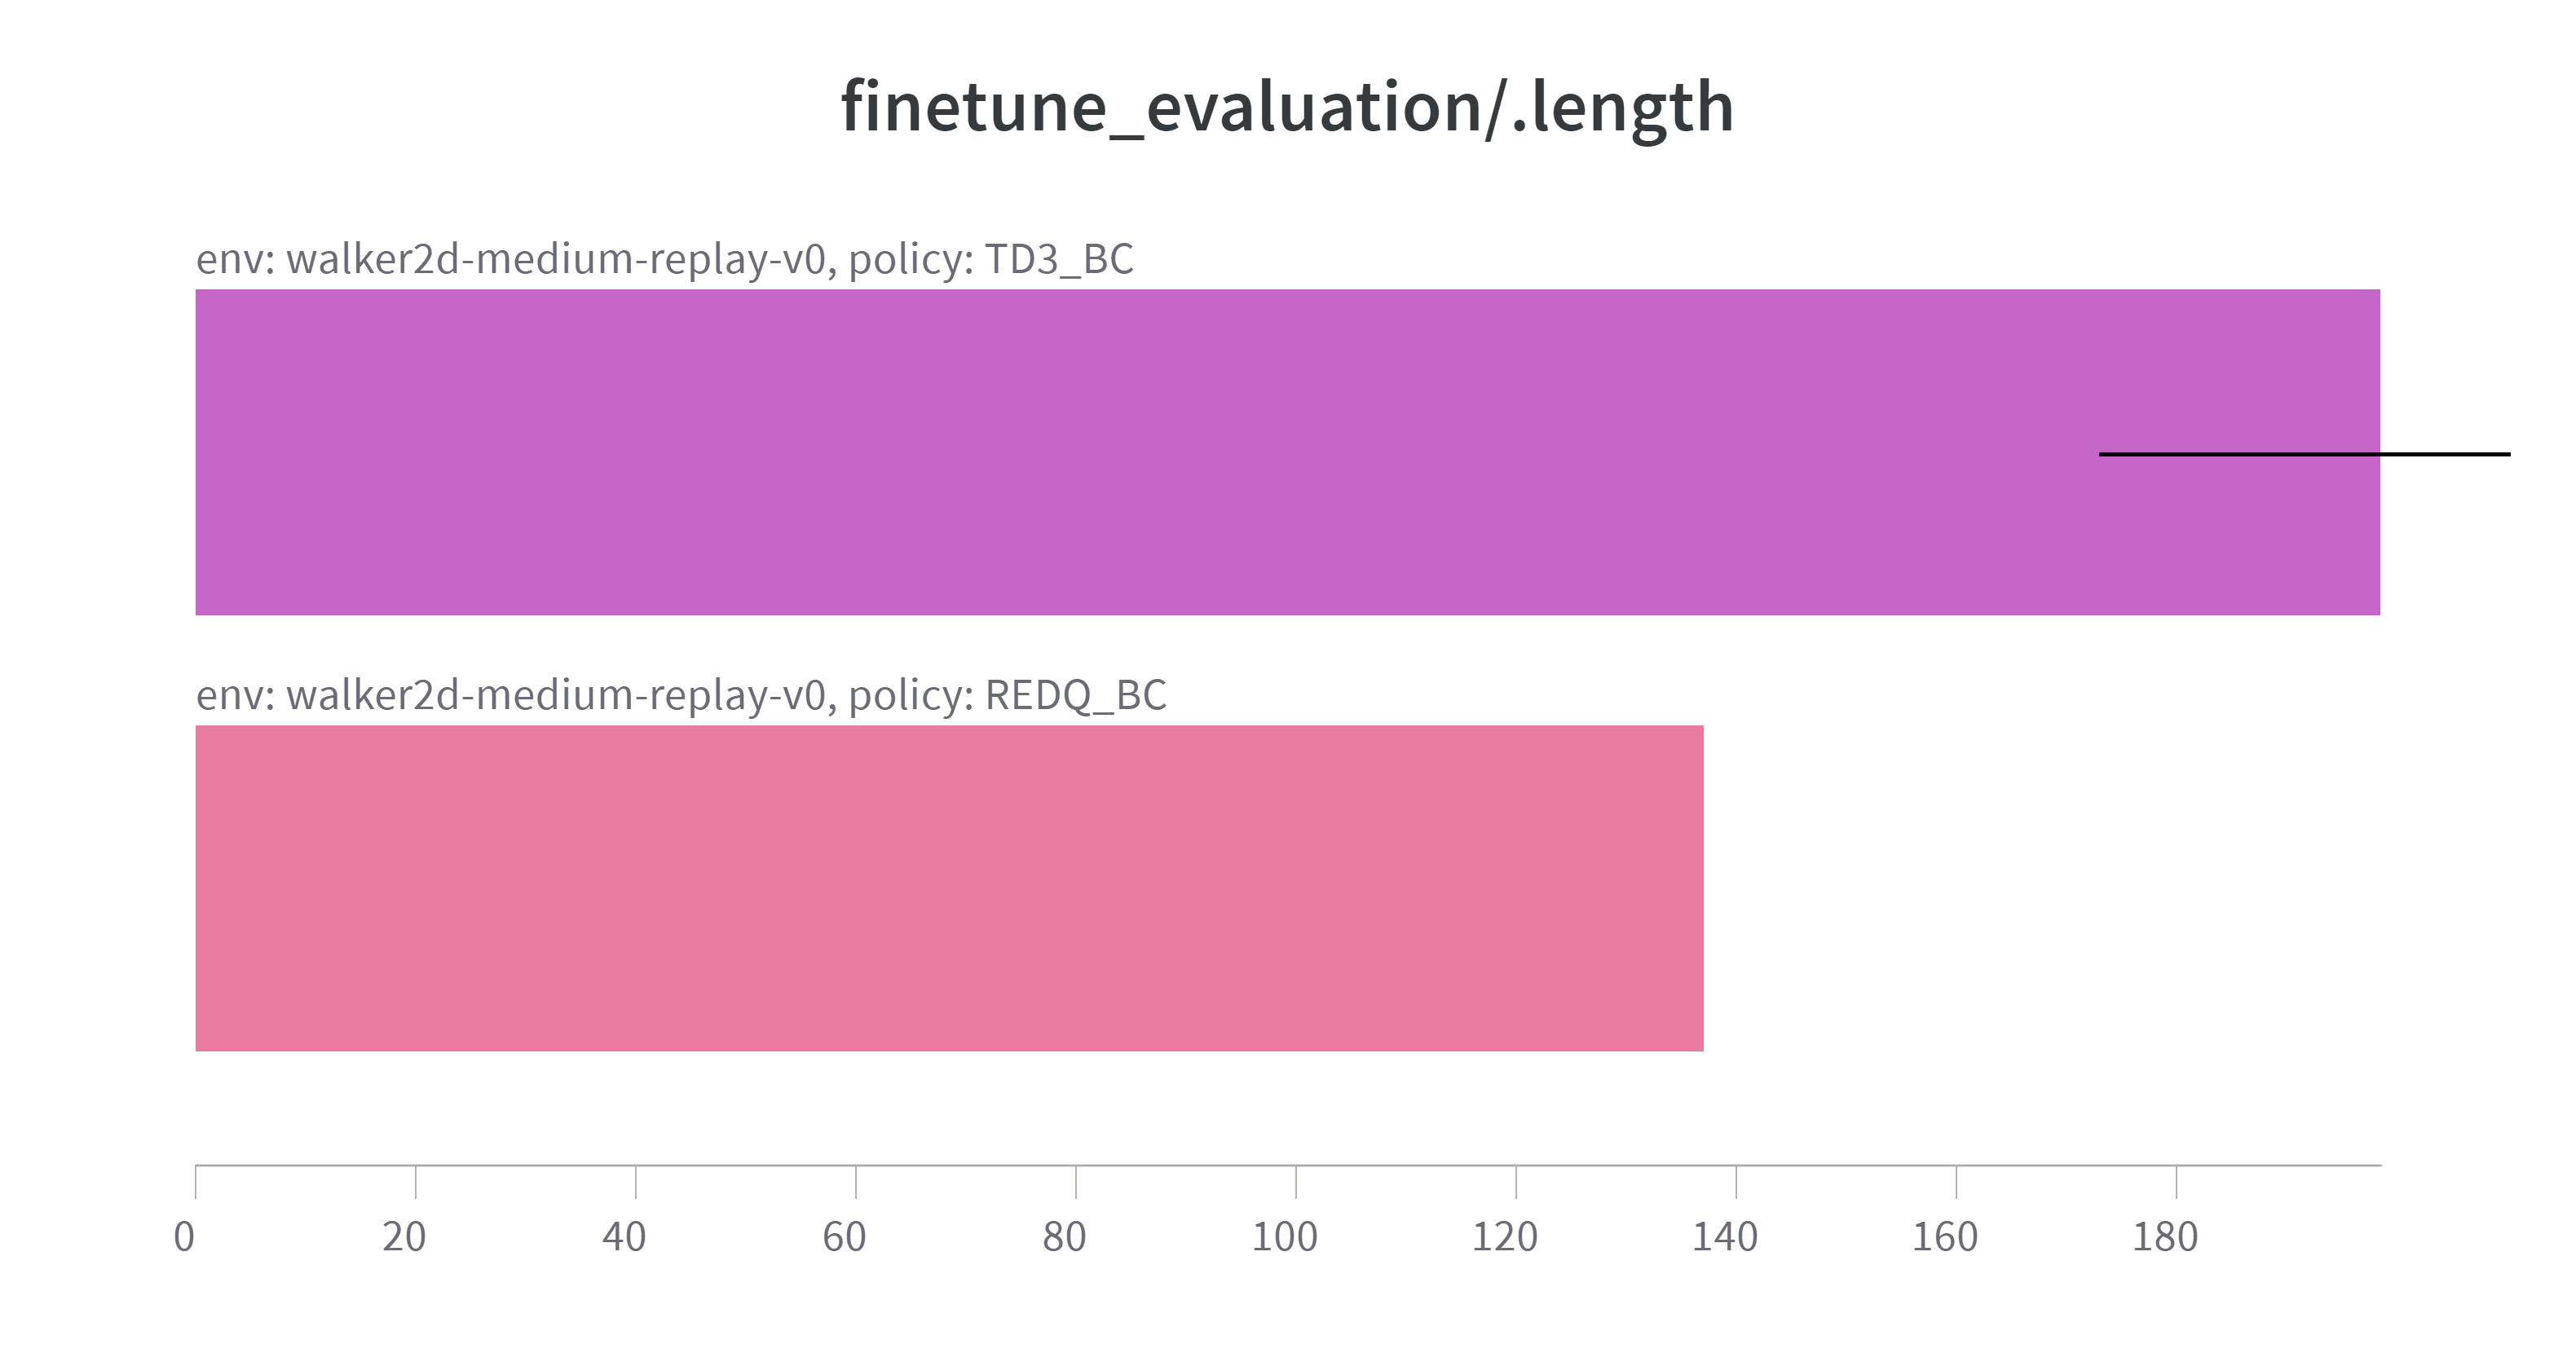

В отличие от результатов, полученных на датасете hopper-medium-replay, здесь можем видеть, что adaptive BC и в среднем дает лучшее качество. 

Отсюда делаем вывод, что на walker2d-medium-replay REDQ-BC работает качественнее. Но на обоих датасетах он проявил себя лучше

Также стоит добавить, что такие результаты были более чем ожидаемы. Ведь adaptive RL в том числе опирается на TD3-BC при своей реализации и стремится улучшить его. Более того основая проблема, которую первый метод стремится решить- это неустойчивый переход от оффлайн к онлайн-обучению. Это мы также пронаблюдали в ходе сравнения

Отсюда можем сделать вывод, что в реализации меодов грубых ошибок не допущено и результатам работы можно доверять 

# Выводы

В данной работе я реализовала 2 метода из статей [Adaptive Behavior Cloning Regularization for Stable Offline-to-Online Reinforcement Learning](https://arxiv.org/abs/2210.13846) и [A Minimalist Approach to Offline Reinforcement Learning](https://arxiv.org/abs/2106.06860) на датасетах из библиотеки D4RL: hopper-medium-replay и walker2d-medium-replay. И проанализировав данные, полученные в ходе оффлайн- и онлайн-обучения, пришла к выводам, что первый метод значительно превосходит TD3-BC. Наиболее ярко разницу можно заметить в качестве обучения и перехода между его типами. Полученный результат более чем согласуется с публикациями, на которые я опиралась при реализации.

Единственный отличный от представленных в статье результат- это то, что REDQ-BC лучше проявил себя при обучении на walker2d-medium-replay. Скорее всего это связано с тем, что я уменьшила размеры датасетов на несколько порядков (для ускорения процесса обучения), из-за чего не могла не пострадать точность. Соответвенно, при использовании таких датасетов говорить о сравнении качества работы методов не совсем корректно.
